# Script to generate the different plots

## Functions used for plotting

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from matplotlib.transforms import offset_copy
import matplotlib.patches as mpatches

def column_mapping(cores):
    return {'finalTick' : 'finalTick',
                  'benchmark' : 'benchmark',
                  'experiment' : 'experiment',
                  f'board.processor.cores{cores}.core.ipc': 'ipc',
                  f'board.processor.cores{cores}.core.branchPred.mispredictDueToBTBMiss_0::total': 'btb_mispredicts',
                  f'board.processor.cores{cores}.core.branchPred.mispredictDueToPredictor_0::DirectCond' : 'cond_mispredicts',
                  f'board.processor.cores{cores}.core.branchPred.mispredictDueToPredictor_0::total': 'bp_mispredicts',
                  f'board.processor.cores{cores}.core.branchPred.mispredicted_0::total' : 'total_mispredicts',
                  f'board.processor.cores{cores}.core.TopDownL1.frontendBound' : 'TopDownL1_frontendBound',
                  f'board.processor.cores{cores}.core.TopDownL1.badSpeculation' : 'TopDownL1_badSpeculation',
                  f'board.processor.cores{cores}.core.TopDownL1.backendBound' : 'TopDownl1_backendBound',
                  f'board.processor.cores{cores}.core.TopDownL1.retiring' : 'TopDownl1_retiring',
                  f'board.processor.cores{cores}.core.rename.serializeStallCycles' : 'serializingStallCycles',
                  f'board.processor.cores{cores}.core.rename.ROBFullEvents' : 'rob_full',
                  f'board.processor.cores{cores}.core.rename.IQFullEvents':'iq_full',
                  f'board.processor.cores{cores}.core.rename.LQFullEvents' : 'lq_full',
                  f'board.processor.cores{cores}.core.rename.SQFullEvents' : 'sq_full',
                  f'board.processor.cores{cores}.core.rename.fullRegistersEvents' : 'register_full',
                  f'board.processor.cores{cores}.core.fetchStats0.icacheStallCycles' : 'icache_stall_cycles',
                  f'board.processor.cores{cores}.core.iew.memOrderViolationEvents' : 'memOrderViolations',
                  f'board.processor.cores{cores}.core.TopDownL2_BackendBound.serializeStalls' : 'TopDownL2_serializingStalls',
                  f'board.processor.cores{cores}.core.TopDownL2_BackendBound.memoryBound' : 'TopDownL2_memoryBound',
                  f'board.processor.cores{cores}.core.TopDownL2_BackendBound.coreBound' : 'TopDownL2_coreBound',
                  f'board.processor.cores{cores}.core.TopDownL2_BadSpeculation.machineClears' : 'TopDownL2_machineClears',
                  f'board.processor.cores{cores}.core.TopDownL2_BadSpeculation.branchMissPredicts' : 'TopDownL2_Mispredicts',
                  f'board.processor.cores{cores}.core.issueRate' : 'issueRate',
                  f'board.processor.cores{cores}.core.fetchStats0.fetchRate' : 'fetchRate',
                  f'board.processor.cores{cores}.core.commitStats0.numInsts' : 'insts',
                  f'board.processor.cores{cores}.core.cpi' : 'cpi',
                  f'board.processor.cores{cores}.core.idleCycles' : 'idleCycles',
                  f'board.processor.cores{cores}.core.numCycles' : 'numCycles', 
                  f'board.processor.cores{cores}.core.robOccupancy::mean' : 'ROB mean occupancy',
                  f'board.cache_hierarchy.l1icaches{cores}.demandMshrMisses::total' : 'l1icacheMisses',
                  f'board.cache_hierarchy.l1dcaches{cores}.demandMshrMisses::total' : 'l1dcacheMisses',
                  f'board.processor.cores{cores}.core.bac.ftSizeDist::mean' : 'mean_ftSize',
                  f'board.processor.cores{cores}.core.bac.ftNumber::mean' : 'mean_ftNumber',
                  f'board.processor.cores{cores}.core.numIssuedDist::mean' : 'mean_issuedInsts',
                  f'board.processor.cores{cores}.core.iew.dispInstDist::mean' : 'mean_dispatchedInsts',
                  f'board.processor.cores{cores}.core.iew.wbRate' : 'wbRate',
                  f'board.processor.cores{cores}.core.ftq.occupancy::mean' : 'Mean FTQ Occupancy',
                  f'board.processor.cores{cores}.core.instSquashedAexperimenttIssueDist::mean' : 'mean_squashedInstsAtIssue',
                  f'board.processor.cores{cores}.core.lsq0.blockedByCache' : 'lsqBlockebByCache',
                  f'board.processor.cores{cores}.core.rob.robSquashCycles' : 'robSquashCycles',
                  f'board.processor.cores{cores}.core.rob.independentInstDelta::mean' : 'independentInstDelta',
                  f'board.processor.cores{cores}.core.rob.independentInst' : 'independentInst'
           }



def loadAndPrepare(fileNames, cores=[], experiment_marker = []):
    dfs = []
    for idx, fileName in enumerate(fileNames):
        tmp_df = pd.read_csv(fileName).fillna(0)
        if len(experiment_marker) > idx:
            tmp_df['set'] = experiment_marker[idx]    
        tmp_df.rename(columns=column_mapping(cores[idx] if len (cores) > 0 else ""), inplace=True)    
        dfs.append(tmp_df)
    df = pd.concat(dfs , ignore_index=True)
    
    
    #df.drop(columns=[col for col in df.columns if not (col.startswith('board.processor.cores1.core') or col in column_mapping.values())], inplace=True)

    new_cols = {
    'mpki': df['total_mispredicts'] * 1000 / df['insts'],
    'btb_mpki': df['btb_mispredicts'] * 1000 / df['insts'],
    'cond_mpki': df['cond_mispredicts'] * 1000 / df['insts'],
    'bp_mpki': df['bp_mispredicts'] * 1000 / df['insts'],
    'icache_mpki': df['l1icacheMisses'] * 1000 / df['insts'],
    'IPC': df['insts'] / (df['numCycles'] - df['idleCycles']),
    'm_cpi': 1 / (df['insts'] / (df['numCycles'] - df['idleCycles'])),
    'L1IStallCycleRate': df['icache_stall_cycles'] / (df['numCycles'] - df['idleCycles']),
    'fetchRate' : df['fetchRate'] * df['numCycles'] / (df['numCycles'] - df['idleCycles']),
    'serializingStallCycleRate': df['serializingStallCycles'] / (df['numCycles'] - df['idleCycles']),
    'ppc' :  df["experiment"].str.extract(r"(ppc\d*)")   
}
   
    df['benchmark'] = df['benchmark'].replace('502.gcc_r.gcc-pp.opts-O3_-finline-limit_36000', '502.gcc_r')
    df = df.assign(**new_cols)
    
    
    return df

def removeWarmup(df):
    n = 2
    mask = df.groupby(['benchmark', 'experiment']).cumcount() >= n
    df = df[mask].reset_index(drop=True)
    return df


def filterBenchExperiment(df, experiment_like, exclude_benchs = [] , only_benchs = []):
    if len(only_benchs) > 0:
        df = df[df['benchmark'].isin(only_benchs)]
    else:    
        df = df[~df['benchmark'].isin(exclude_benchs)]
        
    df = df[df['experiment'].str.contains(experiment_like, regex = True, na = False)]
    return df

def plotYoverTime(df, y, experiment_like = '', exclude_benchs = [], only_benchs = []):
    x = 'finalTick'
    
    df = filterBenchExperiment(df, experiment_like, exclude_benchs , only_benchs)

    for benchmark, group in df.groupby('benchmark'):
        plt.figure(figsize=(8, 5))
        plt.title(f"Benchmark: {benchmark}")
    
        # Group by experiment within the benchmark group
        for experiment, subgrp in group.groupby('experiment'):
            plt.plot(subgrp[x], subgrp[y], label=experiment)      # Line
            plt.scatter(subgrp[x], subgrp[y])                      # Scatter points
    
        plt.xlabel(x)
        plt.ylabel(y)
        plt.legend(title="Experiment")
        plt.grid(True)
        plt.tight_layout()
        plt.show()



def barPlotY_B(
    dfs,
    y,
    label=None,
    experiment_like='',
    exclude_benchs=[],
    only_benchs=[],
    save_as="",
    ylim=None,
    legend_out=False,
    show_means=False,  # mean bars across benchmarks
    ref_value=None     # percentage ref value
):
    # --- If a single df is passed instead of list, wrap it ---
    if isinstance(dfs, pd.DataFrame):
        dfs = [dfs]

    # --- Concatenate with explicit set ordering preserved ---
    df = pd.concat(dfs, ignore_index=True)

    # --- Maintain set order as provided ---
    ordered_sets = []
    for d in dfs:
        for s in d['set'].unique():
            if s not in ordered_sets:
                ordered_sets.append(s)

    df = filterBenchExperiment(df, experiment_like, exclude_benchs, only_benchs)

    # --- Group by benchmark, set, ppc ---
    grouped = df.groupby(['benchmark', 'set', 'ppc'])[y].mean().reset_index()

    # --- Optionally add "Mean" row across benchmarks ---
    if show_means:
        mean_rows = (
            grouped.groupby(['set', 'ppc'])[y]
            .mean()
            .reset_index()
            .assign(benchmark="Mean")
        )
        grouped = pd.concat([grouped, mean_rows], ignore_index=True)

    # --- Plot ---
    benchmarks = grouped['benchmark'].unique()
    sets = ordered_sets  # use preserved order
    ppcs = grouped['ppc'].unique()

    x = np.arange(len(benchmarks))
    width = 0.8 / len(sets)  # width per set group

    hatch_patterns = ["//" , "...", "\\\\", "xx", "++"]  # extend if needed
    colors = sns.color_palette("tab10", len(ppcs))

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, s in enumerate(sets):
        for j, p in enumerate(ppcs):
            vals = []
            for b in benchmarks:
                row = grouped[(grouped['benchmark'] == b) & (grouped['set'] == s) & (grouped['ppc'] == p)]
                vals.append(row[y].values[0] if not row.empty else 0)

            bars = ax.bar(
                x + i * width + j * (width / len(ppcs)),
                vals,
                width / len(ppcs),
                color=colors[j],
                hatch=hatch_patterns[i % len(hatch_patterns)],
                edgecolor="black"
            )

            # --- Add percentage labels if ref_value is given ---
            if ref_value is not None:
                for bar in bars:
                    height = bar.get_height()
                    if height > 0:
                        perc = (height / ref_value) * 100
                        ax.text(
                            bar.get_x() + bar.get_width() / 2,
                            height + (ylim * 0.01 if ylim else height * 0.01),
                            f"{perc:.1f}%",
                            ha="center", va="bottom", fontsize=8
                        )

    # --- Beautify ---
    ax.set_xticks(x + (len(sets) - 1) * width / 2)
    ax.set_xticklabels(benchmarks, rotation=45, ha="right")

    if ylim:
        plt.ylim(0, ylim)

    ax.set_title(f'{label if label else y} per Benchmark')
    ax.set_xlabel('Benchmark')
    ax.set_ylabel(f'{label if label else y}')

    # --- Single combined legend ---
    color_patches = [mpatches.Patch(color=colors[j], label=f"{p}") for j, p in enumerate(ppcs)]
    hatch_patches = [mpatches.Patch(facecolor="white", hatch=hatch_patterns[i % len(hatch_patterns)], edgecolor="black", label=f"{s}") for i, s in enumerate(sets)]

    all_handles = color_patches + hatch_patches

    ax.legend(
        handles=all_handles,
        title="Legend",
        loc="best",
        bbox_to_anchor=(1.0, 0.5) if legend_out else None
    )

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    if len(save_as) > 0:
        plt.savefig(f"bar_plots/{save_as}.png", bbox_inches='tight')

    plt.show()




def barPlotY(
    df, 
    y, 
    label=None, 
    experiment_like='', 
    exclude_benchs=[], 
    only_benchs=[], 
    save_as="", 
    ylim=None, 
    legend_out=False,
    show_means=False,  # NEW flag for mean bars
    ref_value=None     # NEW: reference value for percentage
):

    df = filterBenchExperiment(df, experiment_like, exclude_benchs, only_benchs)
    
    # Mean per benchmark per experiment
    grouped = df.groupby(['benchmark', 'experiment'])[f'{y}'].mean().unstack()

    # Optionally add a "Mean" row across benchmarks
    if show_means:
        means = grouped.mean(axis=0)
        grouped.loc["Mean"] = means

    # Step 2: Plot as bar chart
    ax = grouped.plot(kind='bar', figsize=(10, 6))
    
    # Step 3: Beautify
    if ylim:
        plt.ylim(0, ylim)
    plt.title(f'{label if label else y} per Benchmark per Experiment')
    plt.xlabel('Benchmark')
    plt.ylabel(f'{label if label else y}')
    plt.legend(
        title='Experiment', 
        loc="best",
        bbox_to_anchor=(1.0, 0.5) if legend_out else None
    )
    plt.ylim(bottom=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Step 4: Add percentages if ref_value is given
    if ref_value is not None:
        for container in ax.containers:  # each experiment
            for bar in container:
                height = bar.get_height()
                if height > 0:
                    perc = (height / ref_value) * 100
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,
                        height + (ylim * 0.01 if ylim else height * 0.01),  # offset a bit above
                        f"{perc:.1f}%",
                        ha="center", va="bottom", fontsize=8
                    )

    if len(save_as) > 0:
        plt.savefig(f"bar_plots/{save_as}.png", bbox_inches='tight')
    plt.show()



def plotMeanY(df, y, experiment_like = '', exclude_benchs = [], only_benchs = [], save_as = ""):

    df = filterBenchExperiment(df, experiment_like, exclude_benchs , only_benchs)
    
    grouped = df.groupby(['benchmark', 'experiment'])[f'{y}'].mean().unstack()

    # Step 2: Plot as bar chart
    grouped.plot(kind='bar', figsize=(10, 6))
    
    # Step 3: Beautify
    plt.title(f'Mean of {y} per Benchmark per Experiment')
    plt.xlabel('Benchmark')
    plt.ylabel(f'Mean {y}')
    plt.legend(title='Experiment', 
              bbox_to_anchor=(1.0, 0.5) 
              )
    plt.grid(axis= 'y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    if len(save_as) > 0:
        plt.savefig(f"bar_plots/{save_as}.png",  bbox_inches='tight')
    plt.show()

def plotYDensity(df, y , cores="",  experiment_like = '', exclude_benchs = [], only_benchs = [], label = None ,   save_as = ""):

    variable_supported = {
                            'robOccupancy': fr'board\.processor\.cores{cores}\.core\.robOccupancy::\d+(-\d+)?$', 
                            'ftNumber' : fr'board\.processor\.cores{cores}\.core\.bac\.ftNumber::\d+(-\d+)?$',
                            'BB_Size' :  fr'board\.processor\.cores{cores}\.core\.bac\.ftSizeDist::\d+(-\d+)?$',
                            'issuedInsts': fr'board\.processor\.cores{cores}\.core\.numIssuedDist::\d+(-\d+)?$', 
                            'ftqOccupancy' : fr'board\.processor\.cores{cores}\.core\.ftq\.occupancy::\d+(-\d+)?$'
                         }

    if y not in variable_supported.keys():
        print("The variable entered is not yet supported!")
        return
    
    df = filterBenchExperiment(df, experiment_like, exclude_benchs , only_benchs)

    # Find all columns that represent ROB occupancy buckets (excluding 'total', 'mean', 'stddev', 'samples')
    bucket_cols = [
        col for col in df.columns
        if re.match(variable_supported[y] , col)
    ]
    
    if not bucket_cols:
        print(f"No {y} bucket columns found.")
        return

    # Prepare data for plotting
    df_plot = df[['benchmark', 'experiment', 'finalTick'] + bucket_cols].copy()
    df_plot = df_plot.loc[df_plot.groupby(['experiment', 'benchmark'])['finalTick'].idxmax()]

    # Melt for density plotting
    df_melted = df_plot.melt(
        id_vars=['benchmark', 'experiment'],
        value_vars=bucket_cols,
        var_name=f'{y} Bucket',
        value_name='Frequency'
    )

    # Extract bucket start as numeric value for plotting
    df_melted['Bucket Start'] = df_melted[f'{y} Bucket'].apply(lambda x: int(x.split('::')[-1].split('-')[0]))

    for benchmark, group_df  in df_melted.groupby('benchmark'):
        # Plot
        plt.figure(figsize=(10, 6))
        sns.kdeplot(
            data=group_df,
            x='Bucket Start',
            weights='Frequency',
            hue='experiment',
            common_norm=False,
            fill=True,
            alpha=0.4,
            linewidth=1.5, 
            cut=0,
            clip=(0, df_melted['Bucket Start'].max())
        )

        
        plt.title(f" {label if label else y} Density by Experiment benchmark: {benchmark}")
        plt.xlabel(f'{label if label else y} Bucket Start')
        plt.ylabel('Density (weighted)')
        plt.tight_layout()
        if len(save_as) > 0:
            plt.savefig(f"density_plots/{save_as}.png",  bbox_inches='tight')
        plt.show()


def plot_incremental_from_dfs(
    dfs, labels,
    benchmarks_col="benchmark", experiment_col="experiment", value_col="IPC",
    ylabel="Performance (IPC)", title=None , save_as="", ymax=None,
    show_means=False  # NEW argument
):
    """
    Plot grouped stacked bars from multiple DataFrames, each representing
    a performance scenario. The DataFrames must have columns:
    [benchmark, experiment, IPC].
    
    Parameters:
        dfs (list[pd.DataFrame]): list of DataFrames in scenario order
        labels (list[str]): names of each scenario
    """
    experiments = dfs[0][experiment_col].unique()
    
    # --- aggregate each df ---
    grouped_dfs = []
    for df in dfs:
        grouped = df.groupby([benchmarks_col, experiment_col])[value_col].mean().reset_index()
        grouped_dfs.append(grouped)
    
    # --- merge into one wide table ---
    merged = grouped_dfs[0].rename(columns={value_col: labels[0]})
    for i, df in enumerate(grouped_dfs[1:], 1):
        merged = merged.merge(df.rename(columns={value_col: labels[i]}),
                              on=[benchmarks_col, experiment_col])
    
    # --- optionally add a "Mean" benchmark ---
    if show_means:
        mean_rows = []
        for exp in experiments:
            sub = merged[merged[experiment_col] == exp]
            means = sub[labels].mean()
            row = {benchmarks_col: "Mean", experiment_col: exp}
            row.update(means.to_dict())
            mean_rows.append(row)
        merged = pd.concat([merged, pd.DataFrame(mean_rows)], ignore_index=True)
    
    benchmarks = merged[benchmarks_col].unique()
    x = np.arange(len(benchmarks))
    width = 0.75 / len(experiments)
    fig, ax = plt.subplots(figsize=(16, 7))
    
    # softer, more readable colors
    colors = ["#183ab8", "#bf8970", "#FF2400", "#ffd700", "#50C878", "#C0C0C0", "#7851a9", "#f77b07"]
    hatches = ["//", "\\\\", "xx", "oo", "..", "++"]  
    
    # --- plot each experiment as grouped stacked bar ---
    for i, exp in enumerate(experiments):
        sub = merged[merged[experiment_col]==exp]
        xpos = x - 0.375 + i*width + width/2
        
        bottom = np.zeros(len(sub))
        prev_vals = bottom.copy()
        for j, lab in enumerate(labels):
            vals = sub[lab].to_numpy()
            inc = vals - prev_vals  # true difference

            # only plot positive increments
            pos_mask = inc > 0
            if np.any(pos_mask):
                ax.bar(
                    xpos[pos_mask], inc[pos_mask], width,
                    bottom=prev_vals[pos_mask],
                    color=colors[j % len(colors)],
                    hatch=hatches[i % len(hatches)],
                    edgecolor="black"
                )

            prev_vals = vals  # always update (so baseline is correct)

    # --- formatting ---
    ax.set_ylabel(ylabel, fontsize=12)
    if title: ax.set_title(title, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(benchmarks, rotation=45, ha="right")
    ax.yaxis.grid(True, which="both", linestyle="--", alpha=0.6)
    ax.margins(x=0.12)
    if ymax:
        ax.set_ylim(0, ymax)
    
    # --- build combined legend ---
    scenario_patches = [mpatches.Patch(color=colors[j], label=lab) for j, lab in enumerate(labels)]
    hatch_patches = [mpatches.Patch(facecolor="white", edgecolor="black", hatch=hatches[i], label=exp) 
                     for i, exp in enumerate(experiments)]
    ax.legend(handles=scenario_patches + hatch_patches, title="Legend", ncol=2)
    
    if len(save_as) > 0:
        plt.savefig(f"IPC_plots/{save_as}.png",  bbox_inches='tight')
    plt.tight_layout()
    plt.show()

def plotMPKIStack(
    df, 
    mean=False, 
    experiment_like='', 
    exclude_benchs=[], 
    only_benchs=[], 
    rm_components=[],  
    save_as="", 
    legend_out=False,
    show_means=False,   # NEW ARGUMENT (already added)
    reverse_experiments=False  # NEW ARGUMENT
):
    latest = df
    latest = filterBenchExperiment(latest, experiment_like, exclude_benchs, only_benchs)

    if mean:
        latest = latest.groupby(['experiment', 'benchmark'])[
            ['btb_mpki', 'cond_mpki', 'mpki', 'bp_mpki', 'icache_mpki']
        ].mean().reset_index(drop=False)
    else:
        latest = latest.loc[latest.groupby(['experiment', 'benchmark'])['finalTick'].idxmax()]
        
    component_cols = {
        "icache_mpki": "L1ICache",
        "btb_mpki": "BTB",
        "bp_mpki": "Branch Predictor"
    }

    for comp in rm_components:
        component_cols.pop(comp, None) 
     
    # --- Optionally add "Mean" row for each experiment ---
    if show_means:
        mean_rows = []
        for exp in latest['experiment'].unique():
            sub = latest[latest['experiment'] == exp]
            means = sub[list(component_cols.keys())].mean()
            row = {"benchmark": "Mean", "experiment": exp}
            row.update(means.to_dict())
            mean_rows.append(row)
        latest = pd.concat([latest, pd.DataFrame(mean_rows)], ignore_index=True)

    # Prepare axis categories
    latest['benchmark'] = latest['benchmark'].astype(str)
    benchmarks = list(latest['benchmark'].unique())
    if "Mean" in benchmarks:
        benchmarks = [b for b in benchmarks if b != "Mean"] + ["Mean"]
    
    experiments = sorted(latest['experiment'].unique())
    if reverse_experiments:   # <-- invert order if requested
        experiments = experiments[::-1]
    
    # Define colors and hatches
    colors = {
        "L1ICache": "#14a31b",
        "BTB": "#3734eb",
        "Branch Predictor": "#eb5334"
    }
    hatches = ['', '*', 'o', '-', 'o+*', '-+.', '.', '+']  
    
    # Plot
    fig, ax = plt.subplots(figsize=(16, 6))
    bar_width = 0.6 / len(experiments)
    x = np.arange(len(benchmarks))
    
    # Offset bars by experiment
    for i, exp in enumerate(experiments):
        subset = latest[latest['experiment'] == exp].set_index('benchmark')
        bottom = np.zeros(len(benchmarks))
        for col, name in component_cols.items():
            values = [subset.loc[b, col] if b in subset.index else 0 for b in benchmarks]
            bars = ax.bar(
                x + i * bar_width, values, bar_width,
                bottom=bottom,
                color=colors[name],
                hatch=hatches[i % len(hatches)],
                edgecolor='black',
                label=name if i == 0 else None
            )
            bottom += values
    
    # Labels and ticks
    ax.set_xticks(x + bar_width * (len(experiments) - 1) / 2)
    ax.set_xticklabels(benchmarks, rotation=45, ha='right')
    ax.set_ylabel("MPKI")
    ax.set_title("MPKI Breakdown per Benchmark (Per Experiment)")
    
    # Legends
    component_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[name]) for name in component_cols.values()]
    experiment_handles = [
        plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', hatch=hatches[i % len(hatches)])
        for i, exp in enumerate(experiments)
    ]
    all_handles = component_handles + experiment_handles
    all_labels = list(component_cols.values()) + experiments
    
    ax.legend(
        all_handles, all_labels,
        title="Component / Experiment",
        loc='best',
        bbox_to_anchor=(1.0, 0.5) if legend_out else None
    )
    
    plt.tight_layout()
    if len(save_as) > 0:
        plt.savefig(f"mpki_plots/{save_as}.png", bbox_inches='tight')
    plt.show()


 

def plotCPIStack(df, mean = False, experiment_like = '', exclude_benchs = [], only_benchs = [], m_cpi = False, detailed = True,  save_as = "", ymax=None):
    latest = df

    latest = filterBenchExperiment(latest, experiment_like, exclude_benchs, only_benchs)

    cpi_var = 'm_cpi' if m_cpi else 'cpi'

    
    
    if mean:
        latest = latest.groupby(['experiment', 'benchmark'])[['TopDownl1_retiring', 'TopDownL1_frontendBound', 'TopDownL1_badSpeculation', 'TopDownl1_backendBound', "TopDownL2_Mispredicts", "TopDownL2_machineClears", "TopDownL2_serializingStalls", "TopDownL2_coreBound", "TopDownL2_memoryBound" , cpi_var]].mean().reset_index(drop=False)
    else:
        latest = latest.loc[latest.groupby(['experiment', 'benchmark'])['finalTick'].idxmax()]
        
 
    #latest = latest.map(lambda x: 0 if isinstance(x, (int, float)) and x < 0 else x)
        
    #Print the CPI Stack for specific benchmarks and experiments

    # Define component columns and friendly display names
    component_cols_detailed = {
        "TopDownl1_retiring": "Retiring",
        "TopDownL1_frontendBound": "Frontend Bound",
        "TopDownL2_Mispredicts": "BadSpec Mispredicts",
        "TopDownL2_machineClears" : "BadSpec memOrderViolations",
        "TopDownL2_serializingStalls" : "Backend SerializingStalls",
        "TopDownL2_coreBound" : "Backend coreBound",
        "TopDownL2_memoryBound": "Backend memoryBound"
    }

    component_cols_L1 = {
        "TopDownl1_retiring": "Retiring",
        "TopDownL1_frontendBound": "Frontend Bound",
        "TopDownL1_badSpeculation": "Bad Speculation",
        "TopDownl1_backendBound": "Backend Bound"
    }

    component_cols = component_cols_detailed if detailed else component_cols_L1
    
    # Multiply each component % by total CPI
    for col in component_cols:
        latest[col] = latest[col] * latest[cpi_var]
    
    # Prepare axis categories
    latest['benchmark'] = latest['benchmark'].astype(str)
    benchmarks = sorted(latest['benchmark'].unique())
    experiments = sorted(latest['experiment'].unique())
    
    # Define colors and hatches
    colors = {
        "Retiring": "#7B3294",
        "Frontend Bound": "#F0E442",
        "Bad Speculation": "#999999",
        "BadSpec Mispredicts": "#999999",
        "BadSpec memOrderViolations": "#0dd617",
        "Backend Bound": "#D7191C",
        "Backend SerializingStalls": "#f7760c",
        "Backend coreBound": "#1939d7", 
        "Backend memoryBound" : "#D7191C"
    }
    hatches = ['', '*', 'oo', 'X', 'x', '.', '.', '+']  # One per experiment
    
        # Plot
    fig, ax = plt.subplots(figsize=(16, 6))
    bar_width = 0.6 / len(experiments)
    x = np.arange(len(benchmarks))
    
    # Offset bars by experiment
    for i, exp in enumerate(experiments):
        subset = latest[latest['experiment'] == exp].set_index('benchmark')

        for j, b in enumerate(benchmarks):
            if b not in subset.index:
                continue

            total_cpi = subset.loc[b, cpi_var]
            bottom = 0.0
            drawn = 0.0

            for col, name in component_cols.items():
                value = subset.loc[b, col] if col in subset.columns else 0.0

                # Nothing left to allocate? skip
                if drawn >= total_cpi:
                    continue

                # If the component would overshoot, clip it
                if drawn + value > total_cpi:
                    value = max(0, total_cpi - drawn)

                if value > 0:
                    ax.bar(
                        j + i * bar_width,
                        value,
                        bar_width,
                        bottom=bottom,
                        color=colors[name],
                        hatch=hatches[i % len(hatches)],
                        edgecolor='black',
                        label=name if (i == 0 and bottom == 0) else None
                    )

                # Update positions
                drawn += value
                bottom += value
    
    # Labels and ticks
    ax.set_xticks(x + bar_width * (len(experiments) - 1) / 2)
    ax.set_xticklabels(benchmarks, rotation=45, ha='right')
    ax.set_ylabel("CPI")
    ax.set_title("CPI Breakdown per Benchmark (Per Experiment)")
    if ymax:
        ax.set_ylim(0, ymax)
    
    # Legend for components (only once)
    # Component legend (already exists)
    component_handles = [
        plt.Rectangle((0, 0), 1, 1, color=colors[name])
        for name in component_cols.values()
    ]
    
    # Experiment legend (hatch only, gray fill to avoid visual conflict)
    experiment_handles = [
        plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', hatch=hatches[i % len(hatches)])
        for i, exp in enumerate(experiments)
    ]
    
    # Combine both
    all_handles = component_handles + experiment_handles
    all_labels = list(component_cols.values()) + experiments
    
    # Show both in a unified legend
    ax.legend(
        all_handles,
        all_labels,
        title="Component / Experiment",
        loc='center left',
        bbox_to_anchor=(1.0, 0.5)  # x=1.0 means just outside the plot on the right
    )
    
    plt.tight_layout()
    if len(save_as) > 0:
            plt.savefig(f"CPI_Stacks/{save_as}.png",  bbox_inches='tight')
    plt.show()

### Fetch Rate baseline ppc1

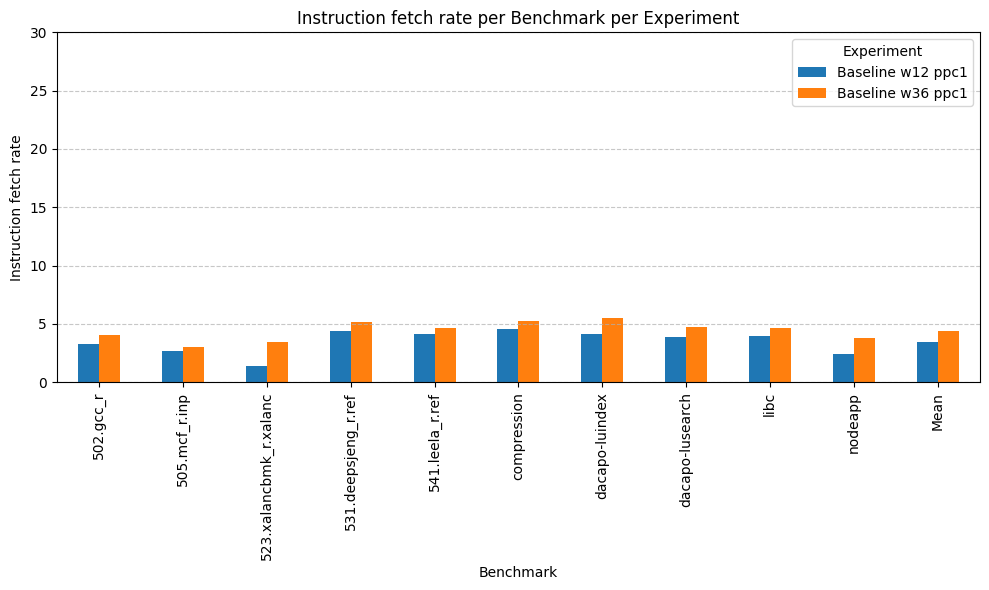

In [205]:
barPlotY(frontend_baseline_df, y = "fetchRate", experiment_like="ppc1", label= "Instruction fetch rate" , only_benchs=considered_benchs , ylim= 30, show_means=True ,  save_as="fetchRate_baseline_w12_vs_w36")

### Frontend bound baseline ppc1

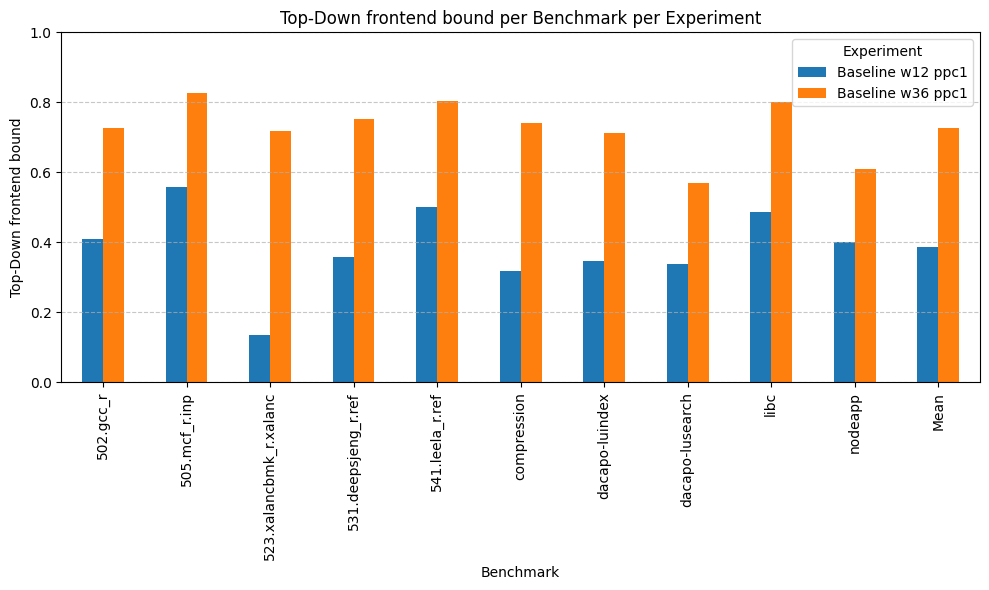

In [206]:
barPlotY(frontend_baseline_df, y = "TopDownL1_frontendBound", experiment_like="ppc1", ylim= 1, label= "Top-Down frontend bound" , only_benchs=considered_benchs,  show_means=True , save_as="TDM_L1_frontendBound_baseline_w12_vs_w36")

### Fetch Rate baseline w36 all ppcs

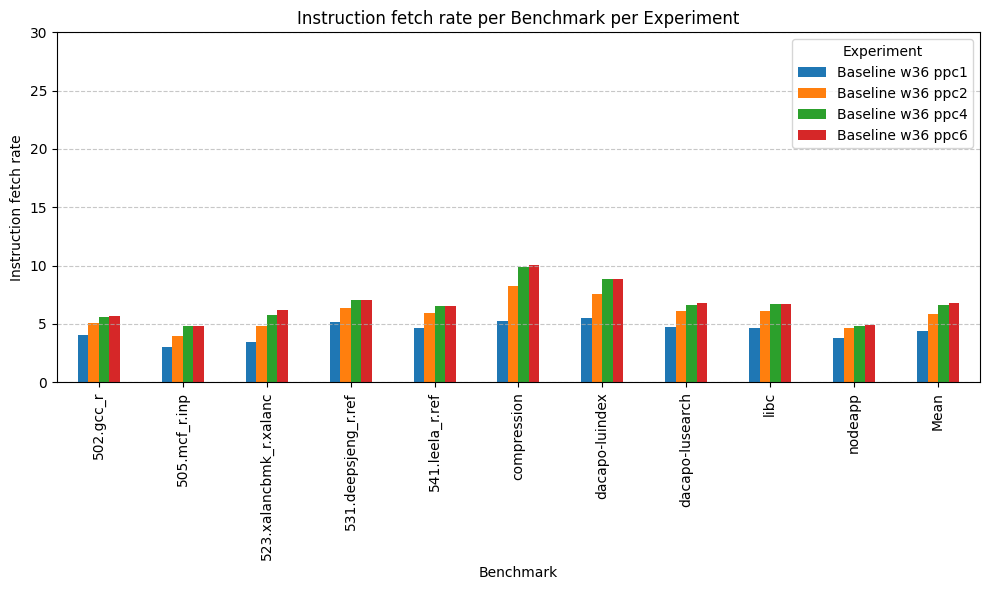

In [207]:
barPlotY(frontend_baseline_df, y = "fetchRate", experiment_like="w36", label= "Instruction fetch rate" , ylim= 30, only_benchs=considered_benchs ,  show_means=True , save_as="fetchRate_baseline_w36")

### Fetch Rate enhanced frontend w36 all ppcs

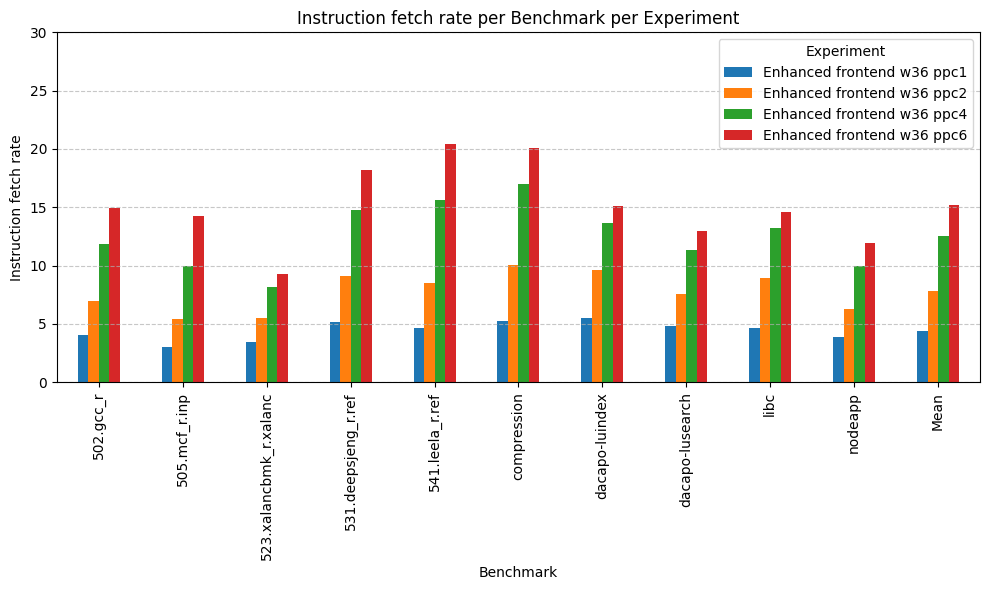

In [208]:
barPlotY(baseline_df, y = "fetchRate", experiment_like="w36", label= "Instruction fetch rate" , ylim= 30, show_means=True ,  only_benchs=considered_benchs, save_as="fetchRate_enhanced_frontend_w36")

### Fetch Rate baseline vs enhanced frontend w36 ppc6

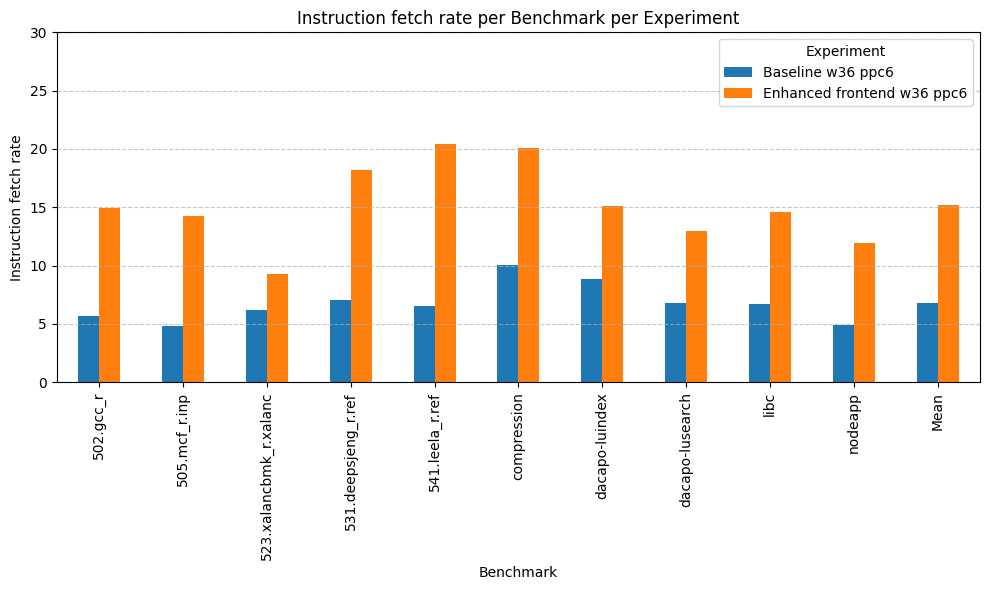

In [209]:
barPlotY(frontend_comparison, y = "fetchRate", experiment_like=r"w36.*ppc6", label= "Instruction fetch rate" , ylim= 30, only_benchs=considered_benchs,  show_means=True , save_as="fetchRate_w36_ppc6_baseline_vs_enhanced_frontend")


### Top-Down frontend bound  enhanced frontend w36 ppcs

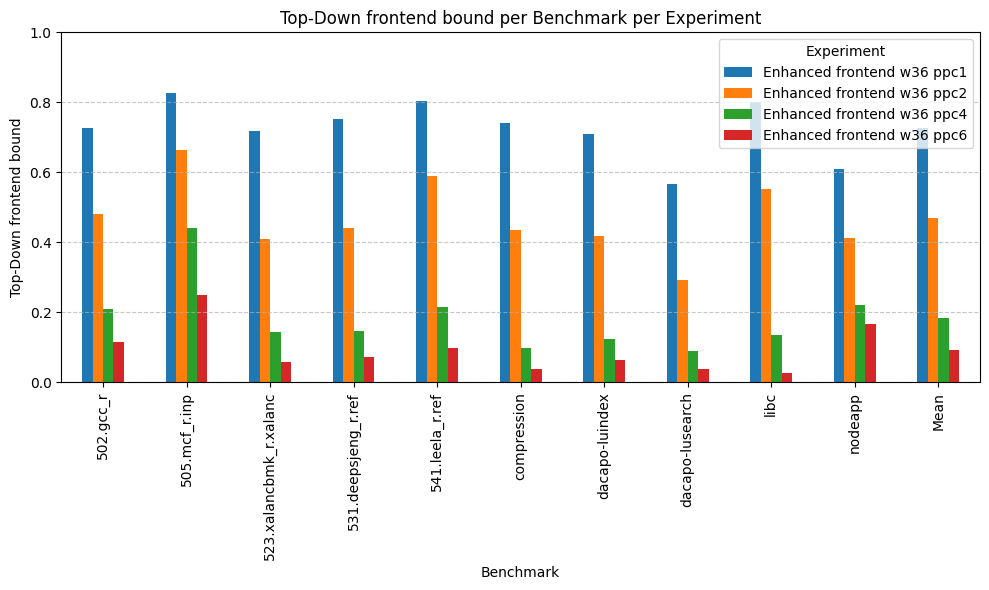

In [210]:
barPlotY(baseline_df, y = "TopDownL1_frontendBound", experiment_like="w36", ylim= 1, label= "Top-Down frontend bound" , only_benchs=considered_benchs, show_means=True , save_as="TDM_L1_frontendBound_enhanced_frontend_w36")


### fetch Rate enhanced frontend w12 ppcs

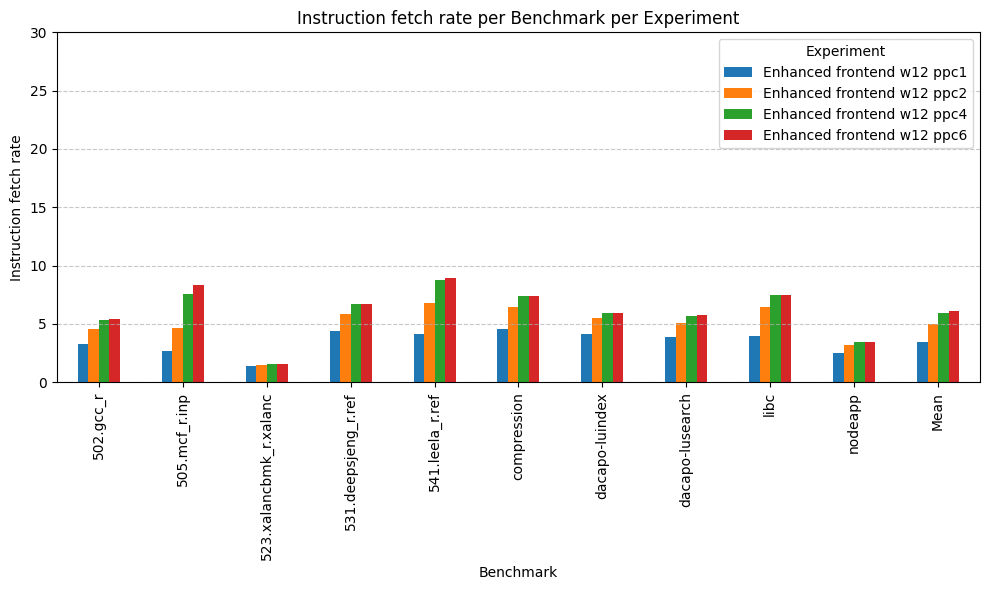

In [211]:
barPlotY(baseline_df, y = "fetchRate", experiment_like="w12", label= "Instruction fetch rate" , ylim= 30, only_benchs=considered_benchs, show_means=True , save_as="fetchRate_enhanced_frontend_w12")

### Top-Down frontend bound  enhanced frontend w12 ppcs

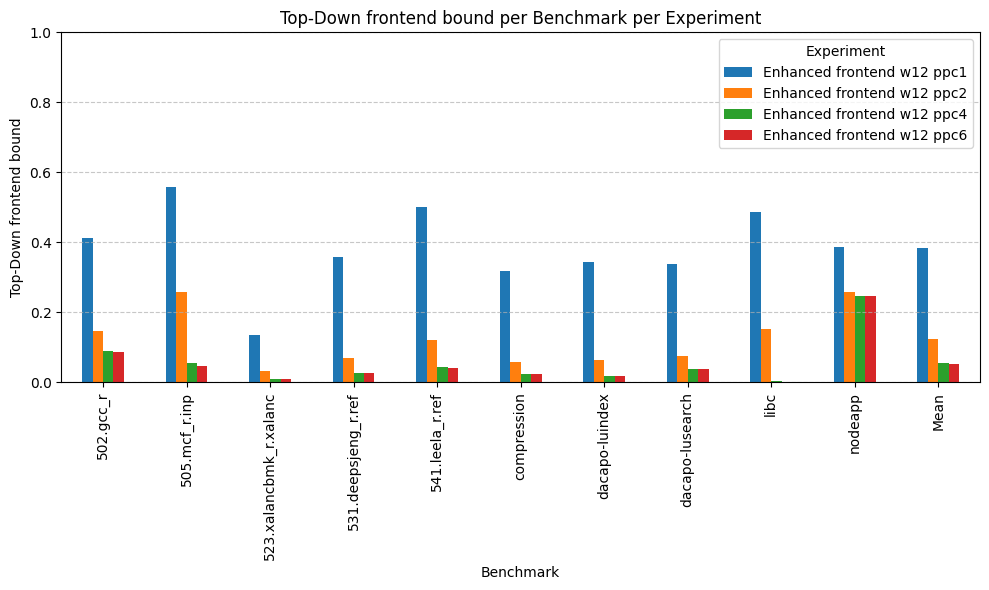

In [212]:
barPlotY(baseline_df, y = "TopDownL1_frontendBound", experiment_like="w12", ylim= 1, label= "Top-Down frontend bound" , only_benchs=considered_benchs,  show_means=True , save_as="TDM_L1_frontendBound_enhanced_frontend_w12")

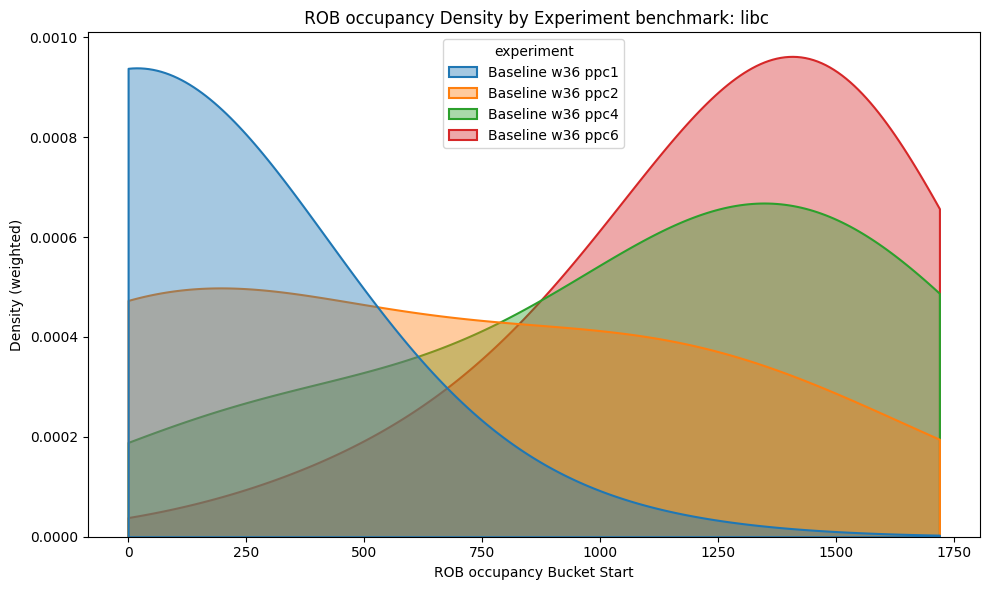

In [214]:
plotYDensity(backend_comparison,y = 'robOccupancy', cores ="1" , experiment_like = r'Baseline', only_benchs=["libc"], label="ROB occupancy" ,  save_as="robOccupancy_libc_w36")

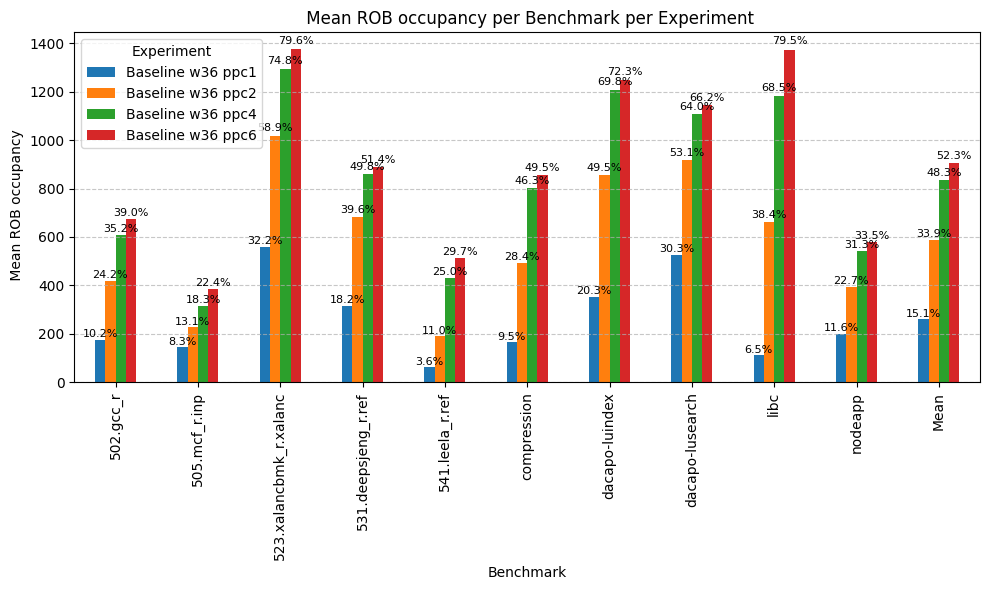

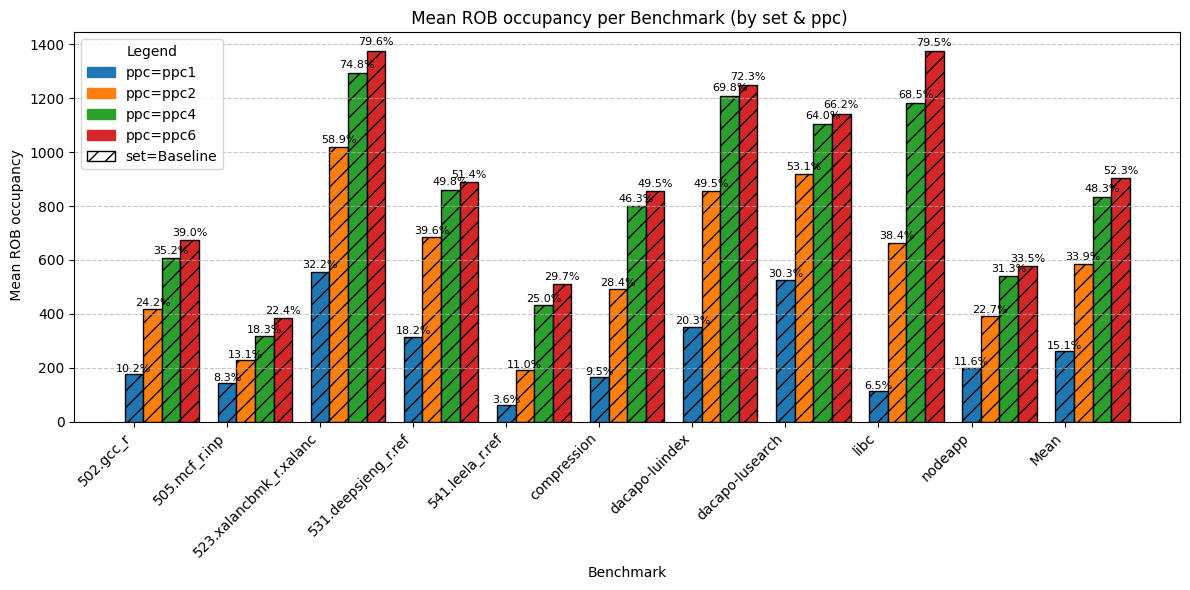

In [274]:
tmp_df = filterBenchExperiment(backend_comparison, experiment_like="Baseline", only_benchs=considered_benchs)

barPlotY(backend_comparison, y = 'ROB mean occupancy', label=" Mean ROB occupancy" , experiment_like = r'Baseline', only_benchs=considered_benchs , save_as="robOccupancy_benchs_w36",  show_means=True ,  ref_value=1728)
barPlotY_B(tmp_df, y = 'ROB mean occupancy', label=" Mean ROB occupancy" , experiment_like = r'', only_benchs=considered_benchs , save_as="",  show_means=True ,  ref_value=1728)


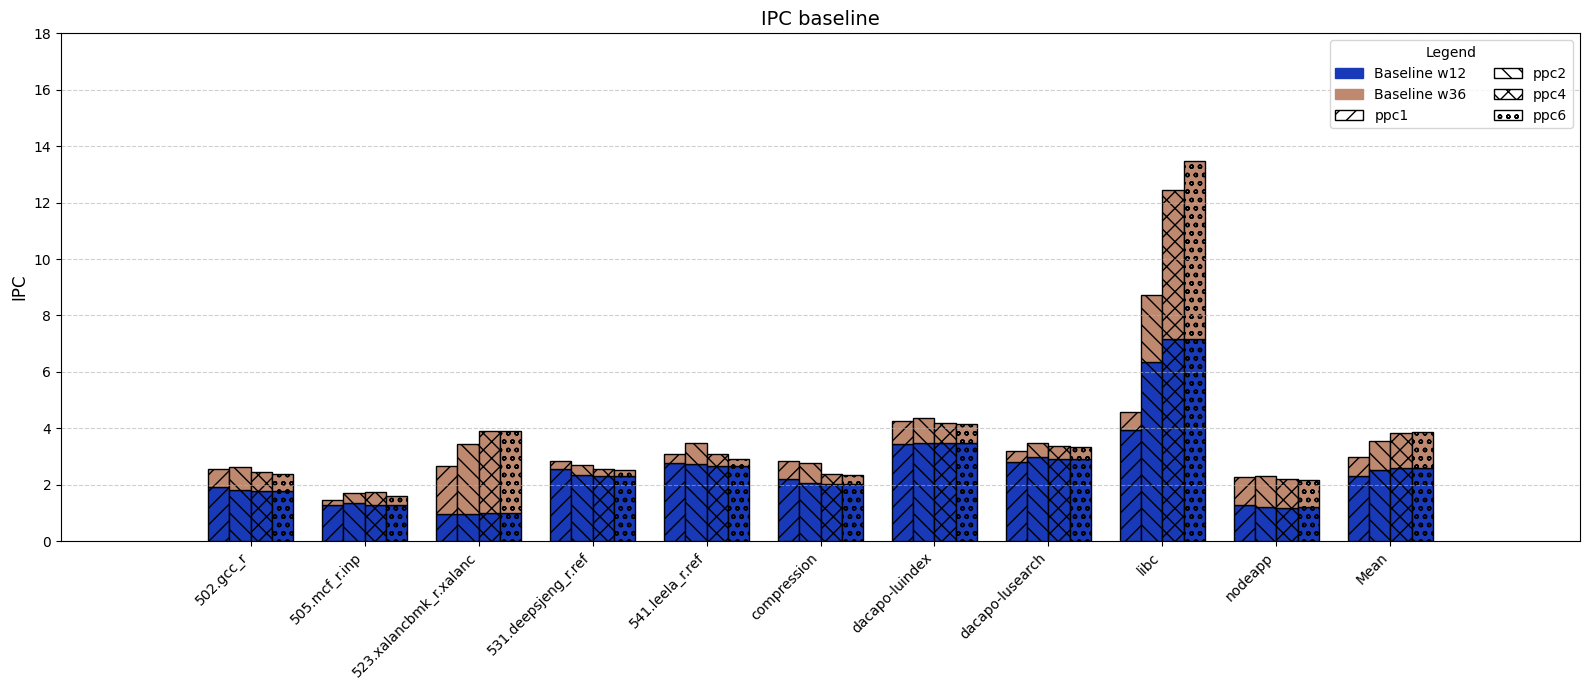

In [203]:
tmp_baseline_w12 = filterBenchExperiment(baseline_df, experiment_like="w12", only_benchs=considered_benchs)
tmp_baseline_w36 = filterBenchExperiment(baseline_df, experiment_like="w36", only_benchs=considered_benchs)


dfs = [tmp_baseline_w12, tmp_baseline_w36]
labels = [ "Baseline w12" , "Baseline w36"]

plot_incremental_from_dfs(dfs, labels, experiment_col="ppc", ylabel="IPC", title="IPC baseline", ymax=18, show_means=True ,  save_as="IPC_baseline")


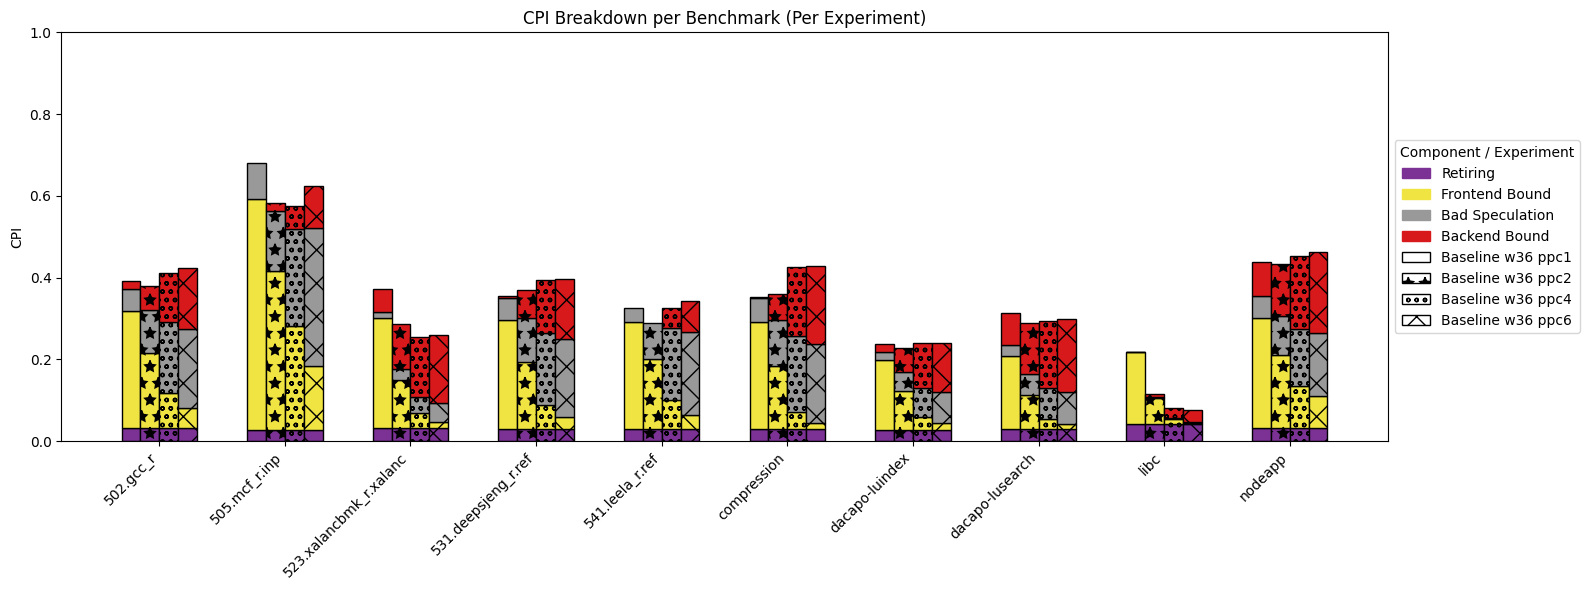

In [86]:
plotCPIStack(backend_comparison, experiment_like = r'Baseline', only_benchs=considered_benchs, mean = True, m_cpi = True, detailed = False, ymax=1,  save_as="L1_cpi_stack_backend_baseline_w36") 


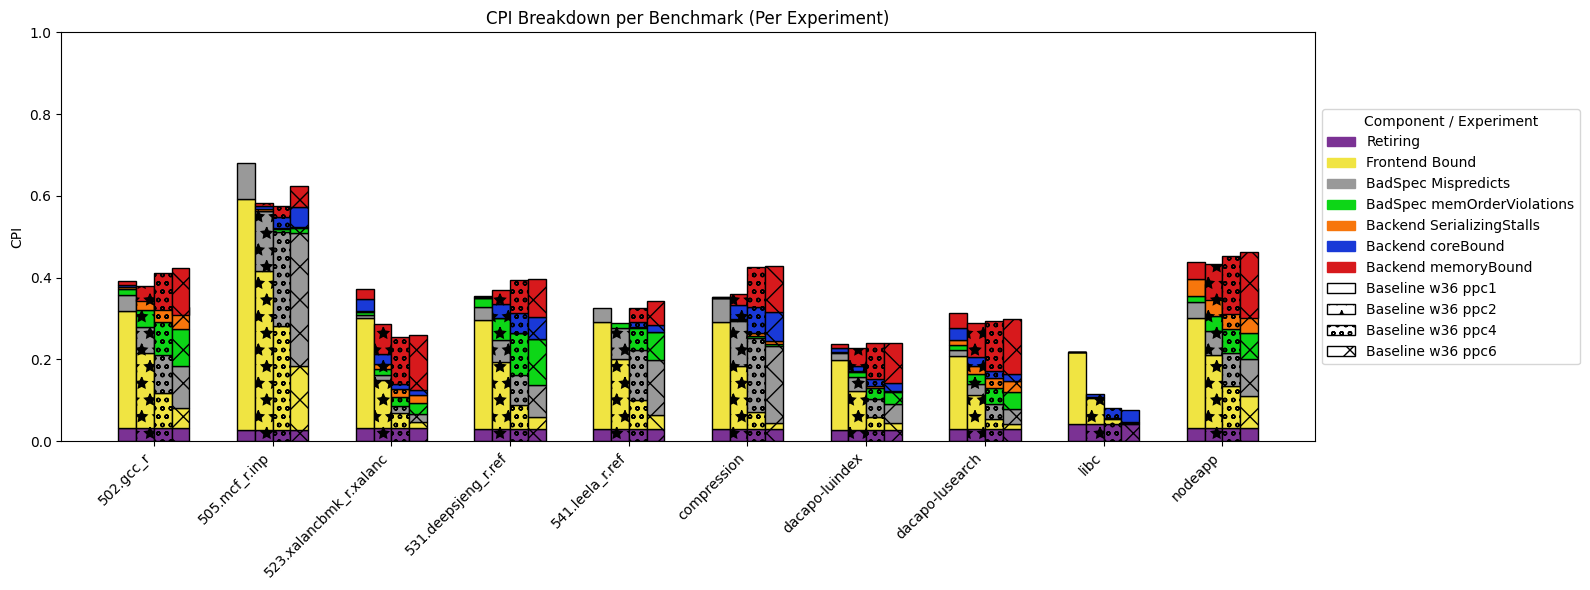

In [87]:
plotCPIStack(backend_comparison, experiment_like = r'Baseline', only_benchs=considered_benchs, mean = True, m_cpi = True, detailed = True, ymax=1,  save_as="L2_cpi_stack_backend_baseline_w36") 


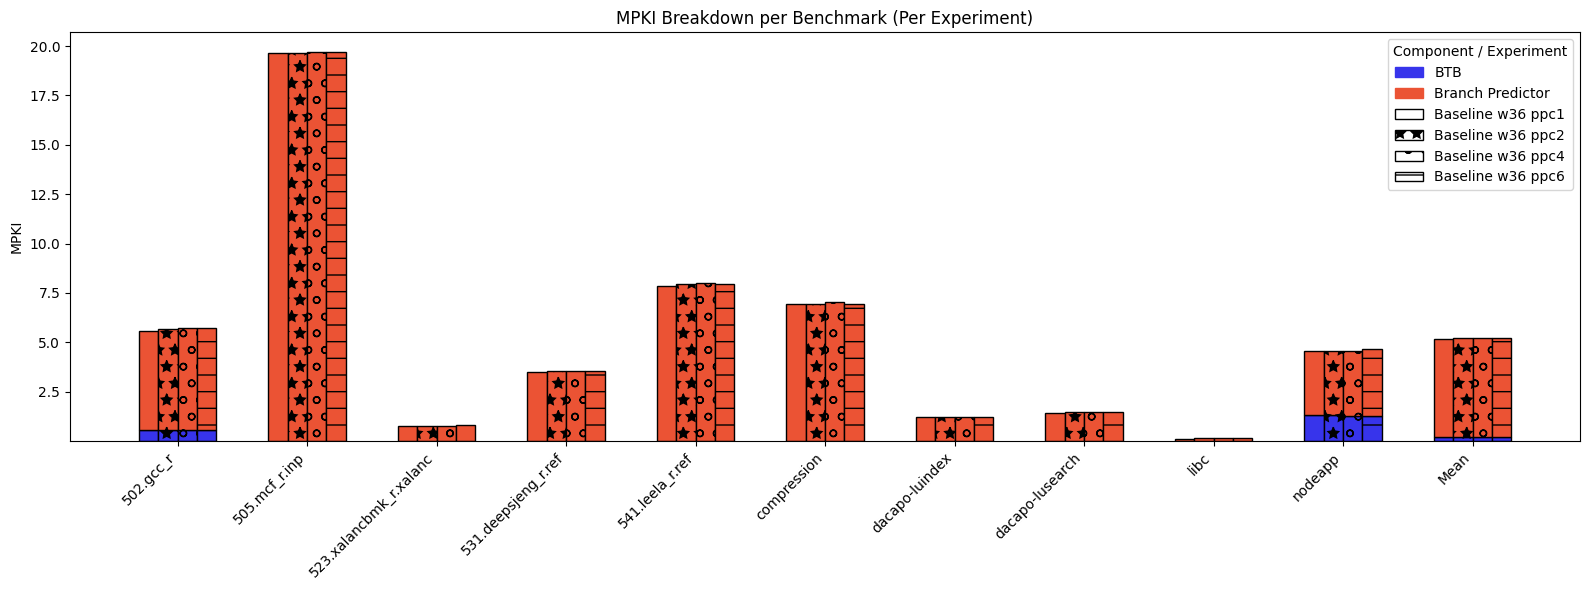

In [231]:
plotMPKIStack(backend_comparison,  experiment_like = r'Baseline', only_benchs=considered_benchs , mean = True, rm_components = ['icache_mpki'], show_means=True , save_as="mpki_backend_baseline_w36")


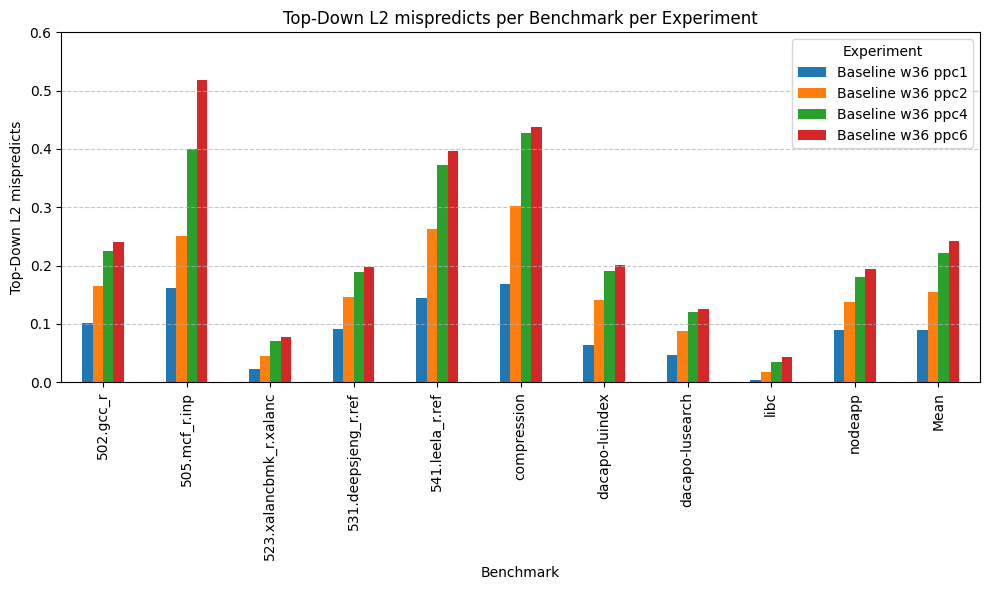

In [233]:
barPlotY(backend_comparison, y = "TopDownL2_Mispredicts", experiment_like="Baseline", label= "Top-Down L2 mispredicts" , only_benchs=considered_benchs , ylim=0.6, show_means=True , save_as="TDM_L2mispredicts_baseline_w36")


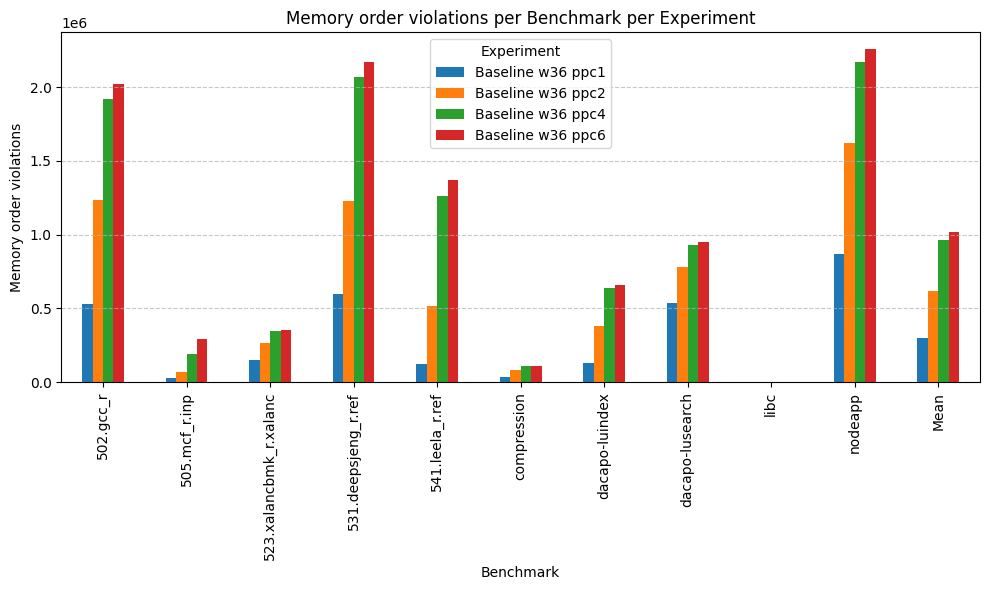

In [234]:
barPlotY(backend_comparison, y = "memOrderViolations", experiment_like="Baseline", label= "Memory order violations" , only_benchs=considered_benchs , show_means=True,   save_as="memOrderViolations_backend_baseline_w36")


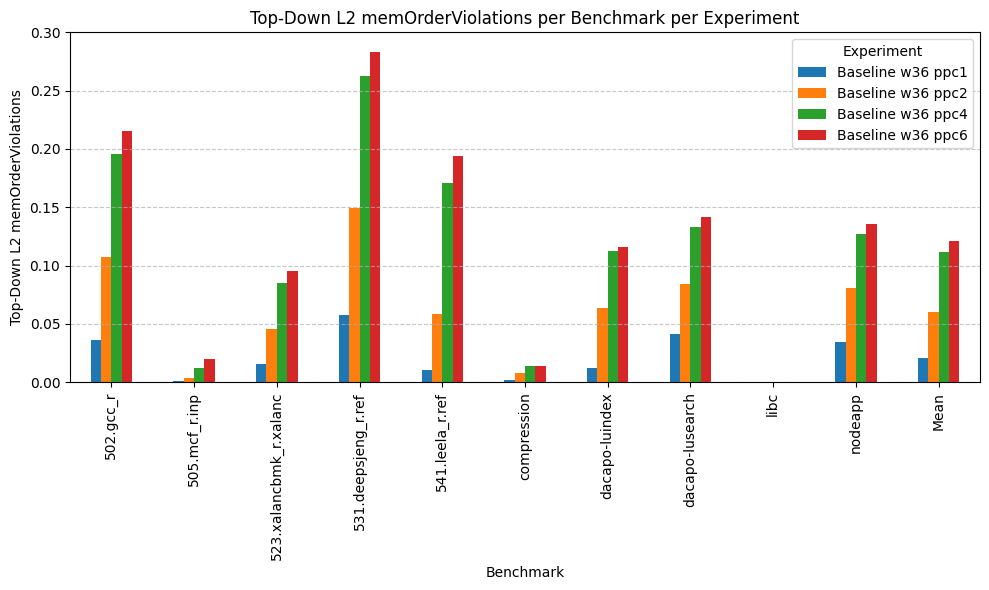

In [235]:
barPlotY(backend_comparison, y = "TopDownL2_machineClears", experiment_like="Baseline", label= "Top-Down L2 memOrderViolations" , only_benchs=considered_benchs , ylim=0.3, show_means=True,  save_as="TDM_L2machineClears_baseline_w36")


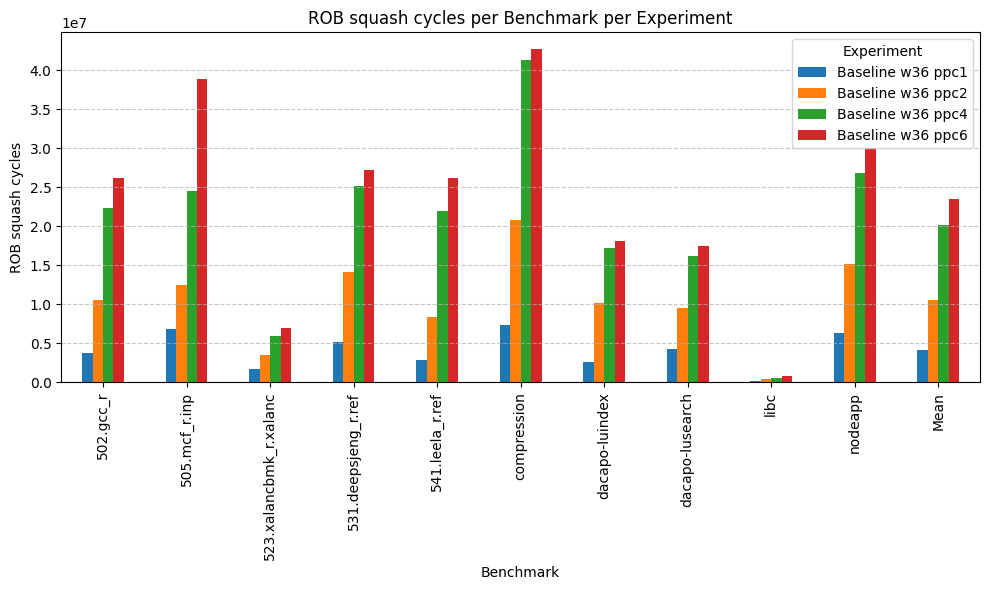

In [236]:
barPlotY(backend_comparison, y = "robSquashCycles", experiment_like="Baseline", label= "ROB squash cycles" , only_benchs=considered_benchs, show_means=True,  save_as="robSquashCycles_backend_baseline_w36")


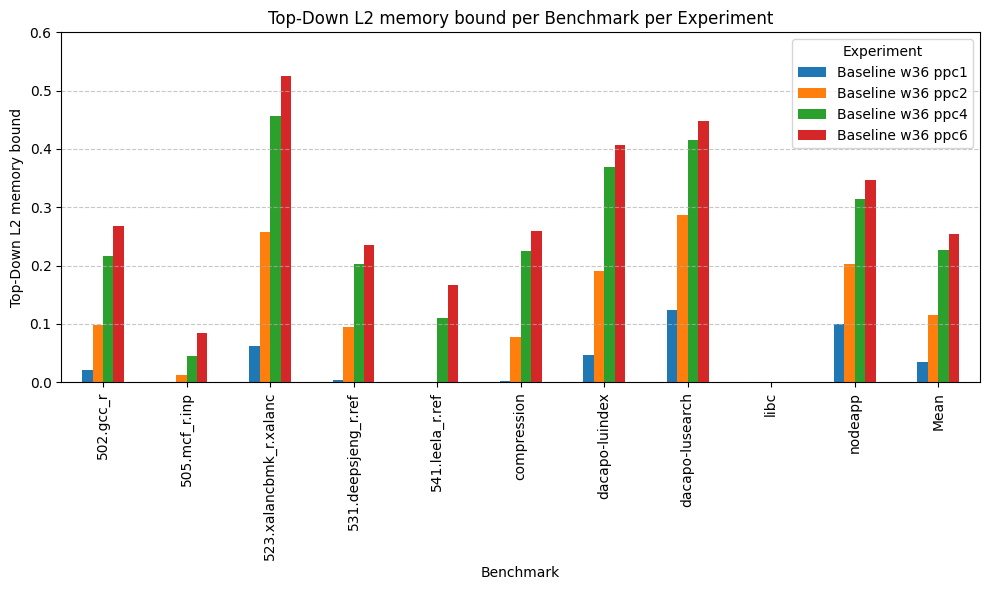

In [237]:
barPlotY(backend_comparison, y = "TopDownL2_memoryBound", experiment_like="Baseline", label= "Top-Down L2 memory bound" , only_benchs=considered_benchs , ylim=0.6 , show_means=True,  save_as="TDM_L2_memoryBound_backend_baseline_w36")


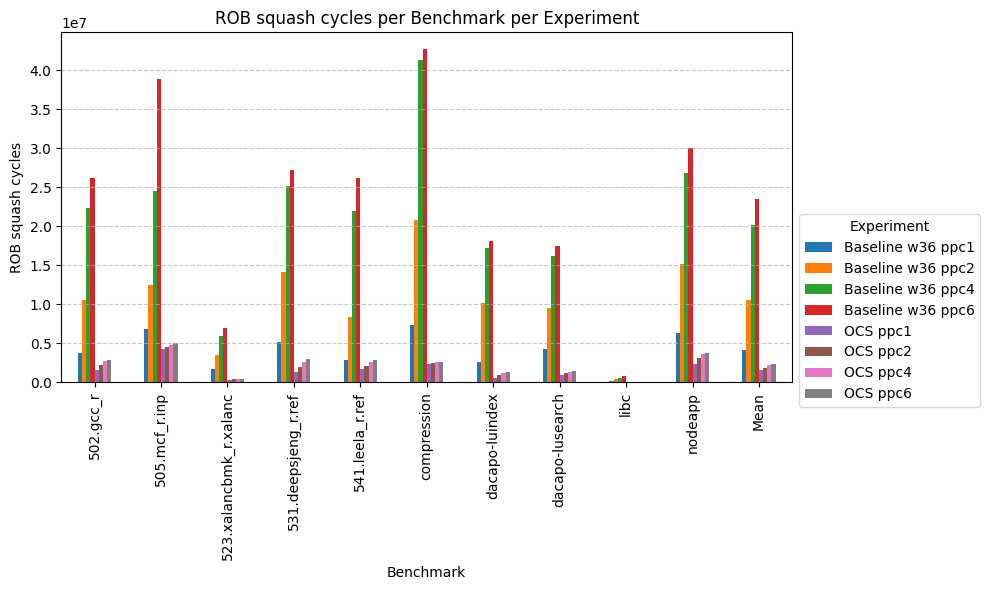

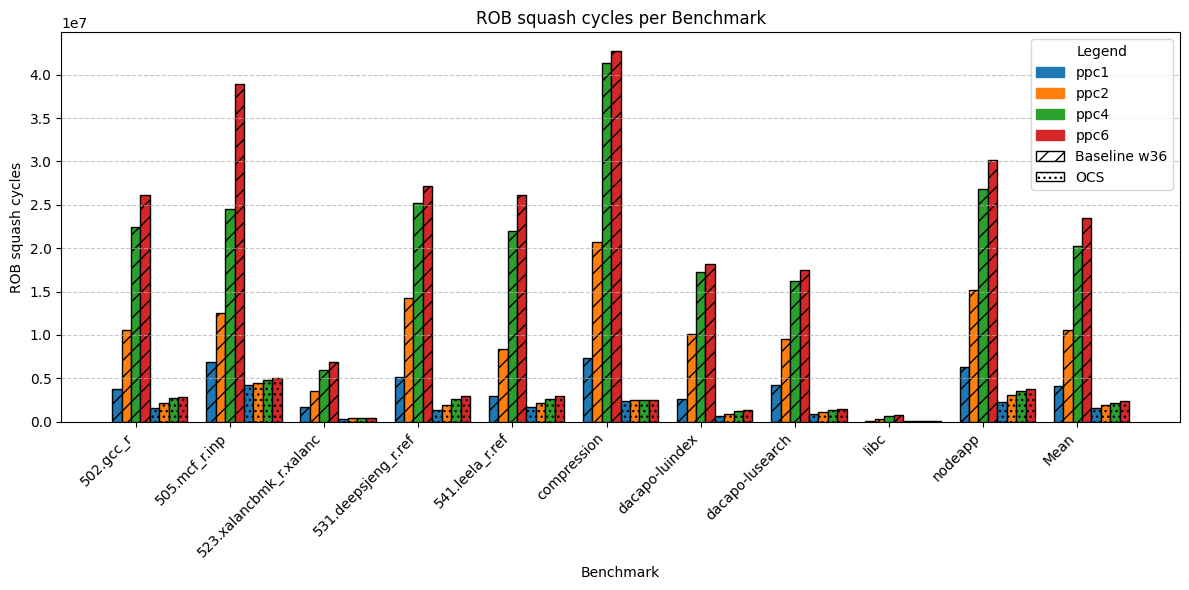

In [302]:
barPlotY(backend_comparison, y = "robSquashCycles", experiment_like=r"Baseline|OCS", label= "ROB squash cycles" , only_benchs=considered_benchs, legend_out=True , show_means=True,  save_as="")

bl_tmp_df = filterBenchExperiment(backend_comparison, experiment_like="Baseline", only_benchs=considered_benchs)
bl_tmp_df["set"] = "Baseline w36"
ocs_tmp_df = filterBenchExperiment(backend_comparison, experiment_like="OCS", only_benchs=considered_benchs)


barPlotY_B([bl_tmp_df, ocs_tmp_df], y = "robSquashCycles", experiment_like=r"", label= "ROB squash cycles" , only_benchs=considered_benchs, legend_out=False , show_means=True,  save_as="robSquashCycles_backend_baseline_vs_ocs_w36")


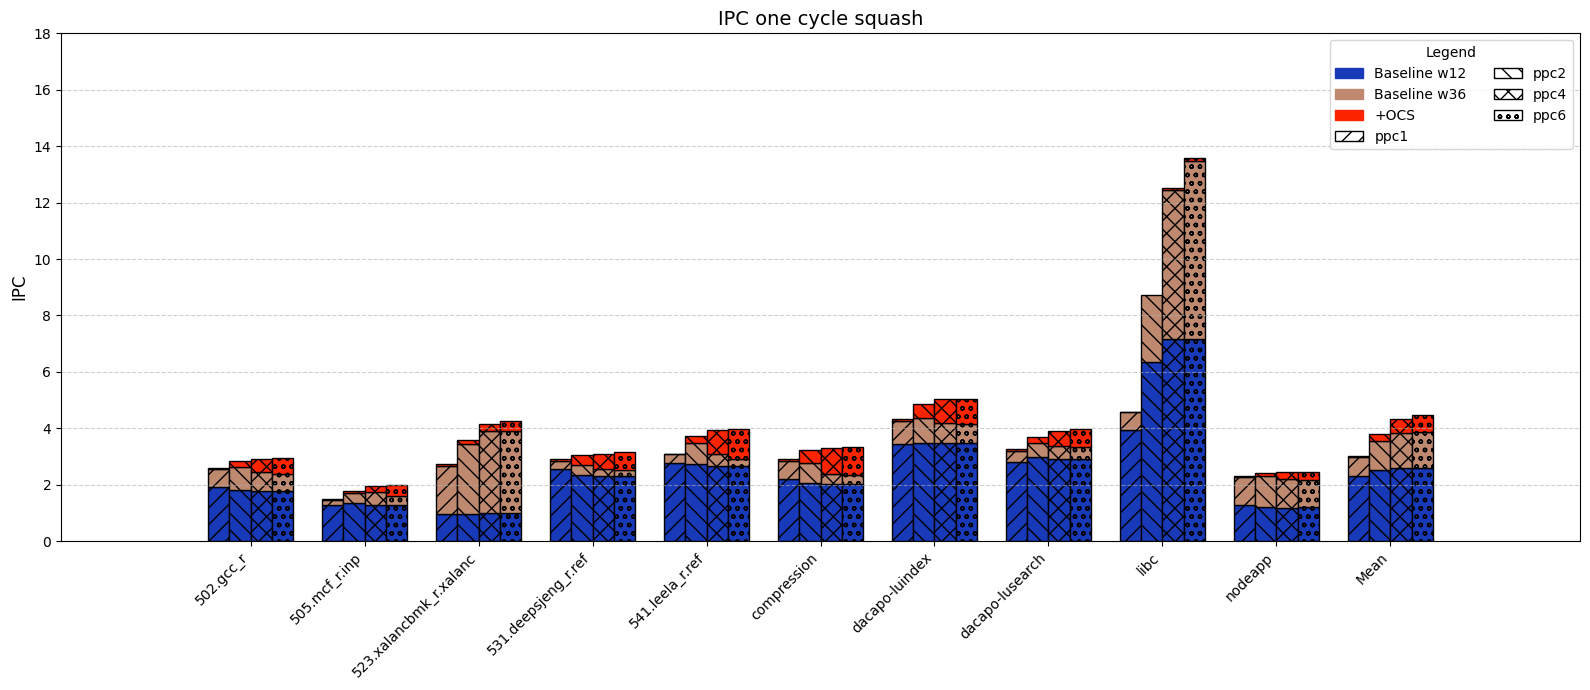

In [202]:
tmp_baseline_w12 = filterBenchExperiment(baseline_df, experiment_like="w12", only_benchs=considered_benchs)
tmp_baseline_w36 = filterBenchExperiment(baseline_df, experiment_like="w36", only_benchs=considered_benchs)
tmp_ocs_df = filterBenchExperiment(big_squash_rs_df, experiment_like="w36", only_benchs=considered_benchs)


dfs = [tmp_baseline_w12, tmp_baseline_w36, tmp_ocs_df]
labels = [ "Baseline w12" , "Baseline w36", "+OCS"]

plot_incremental_from_dfs(dfs, labels, experiment_col="ppc", ylabel="IPC", title="IPC one cycle squash", ymax=18, show_means=True , save_as="IPC_OCS")


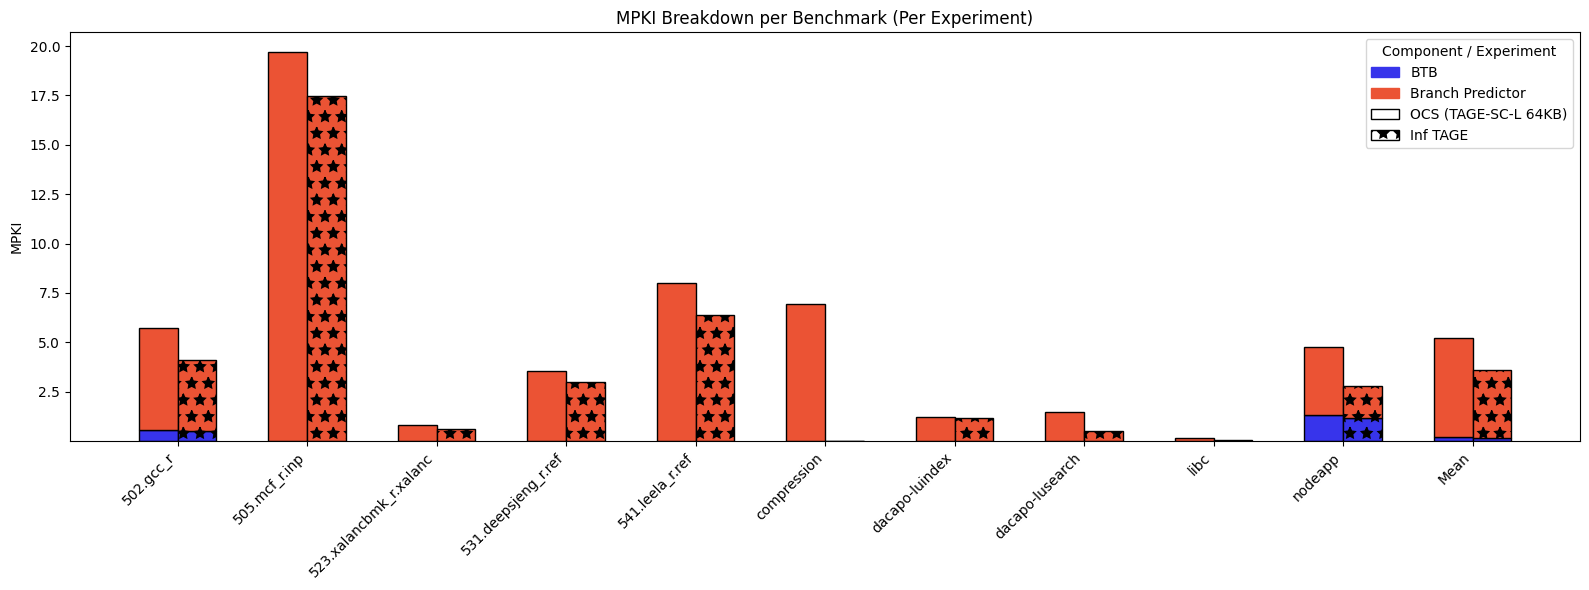

In [307]:
mpki_comp = filterBenchExperiment(comparison_ocs_inf_tage_df, experiment_like = 'w36.*ppc6', exclude_benchs=excluded)
mpki_comp['experiment'] = mpki_comp['experiment'].replace('arm64_one_cycle_squash_w36_f3_ppc6', 'OCS (TAGE-SC-L 64KB)')
mpki_comp['experiment'] = mpki_comp['experiment'].replace('arm64_ocs_inf_tage_w36_f3_ppc6', 'Inf TAGE')


plotMPKIStack(mpki_comp,  experiment_like = r'', only_benchs=considered_benchs , mean = True, rm_components = ['icache_mpki'] , show_means=True, reverse_experiments=True ,   save_as="mpki_stack_inf_tage_vs_one_cycle_squash")



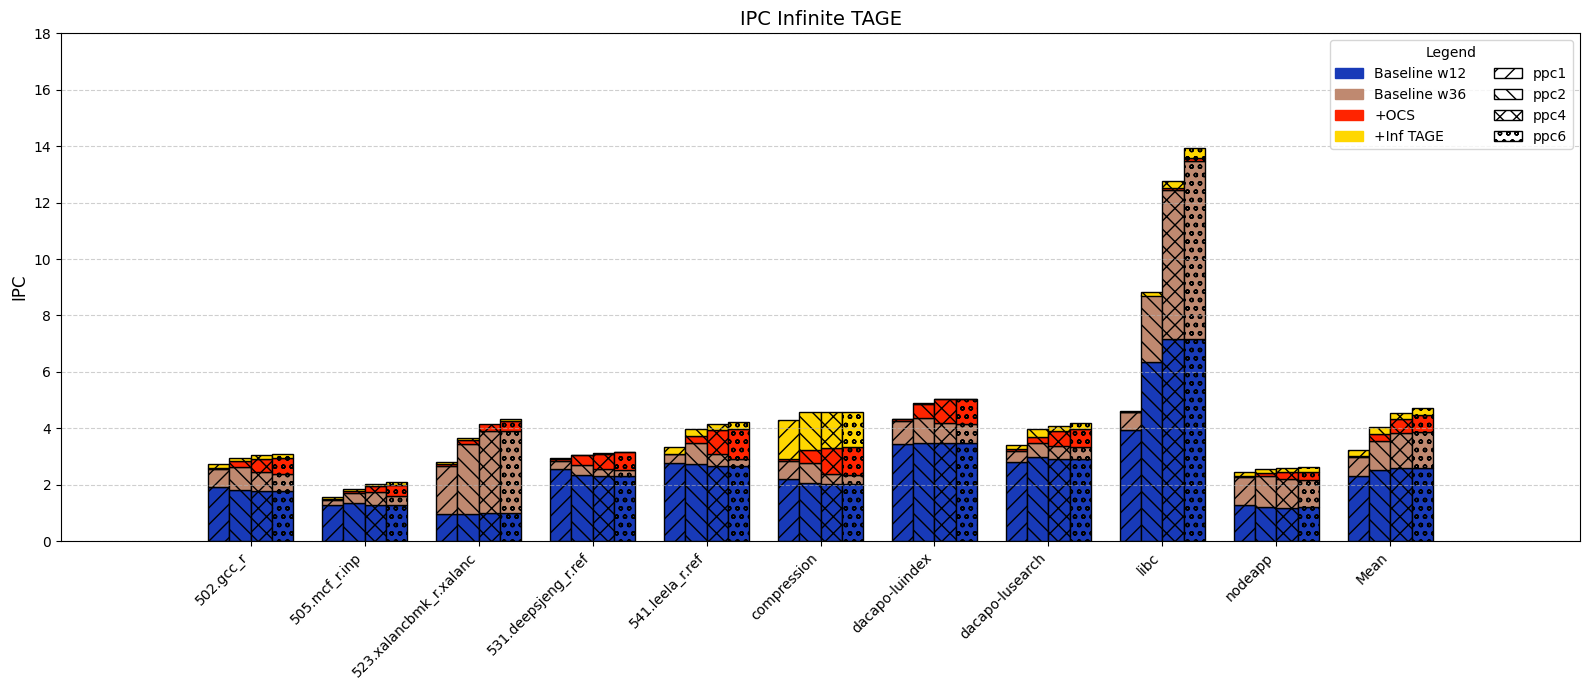

In [201]:

tmp_baseline_w12 = filterBenchExperiment(baseline_df, experiment_like="w12", only_benchs=considered_benchs)
tmp_baseline_w36 = filterBenchExperiment(baseline_df, experiment_like="w36", only_benchs=considered_benchs)
tmp_ocs_df = filterBenchExperiment(big_squash_rs_df, experiment_like="w36", only_benchs=considered_benchs)
tmp_ocs_it_df = filterBenchExperiment(ocs_inf_tage_df, experiment_like="w36", only_benchs=considered_benchs)

dfs = [tmp_baseline_w12, tmp_baseline_w36, tmp_ocs_df, ocs_inf_tage_df]
labels = [ "Baseline w12" , "Baseline w36", "+OCS", "+Inf TAGE"]

plot_incremental_from_dfs(dfs, labels, experiment_col="ppc", ylabel="IPC", title="IPC Infinite TAGE", ymax=18, show_means=True , save_as="IPC_INF_TAGE")




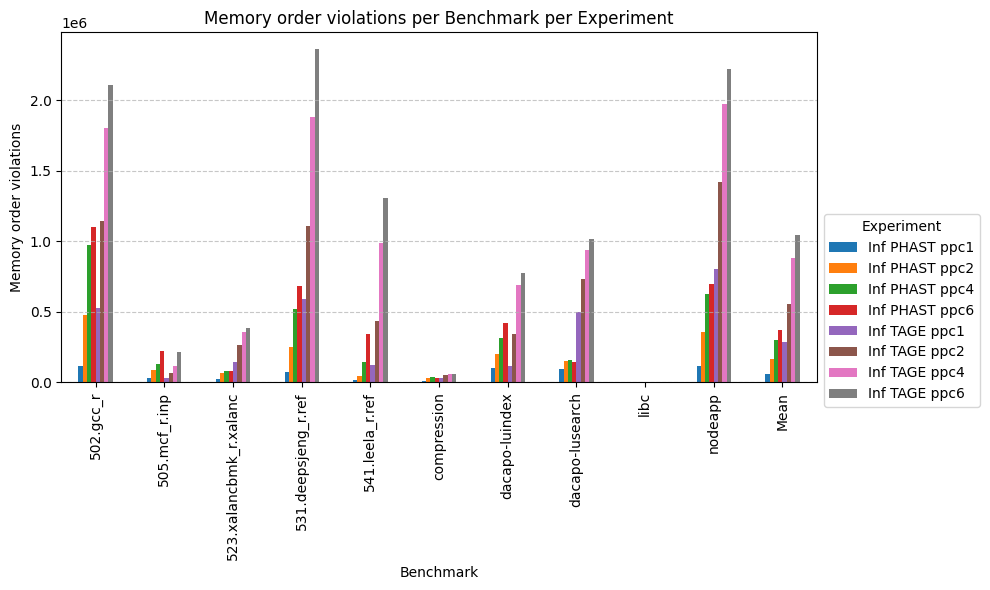

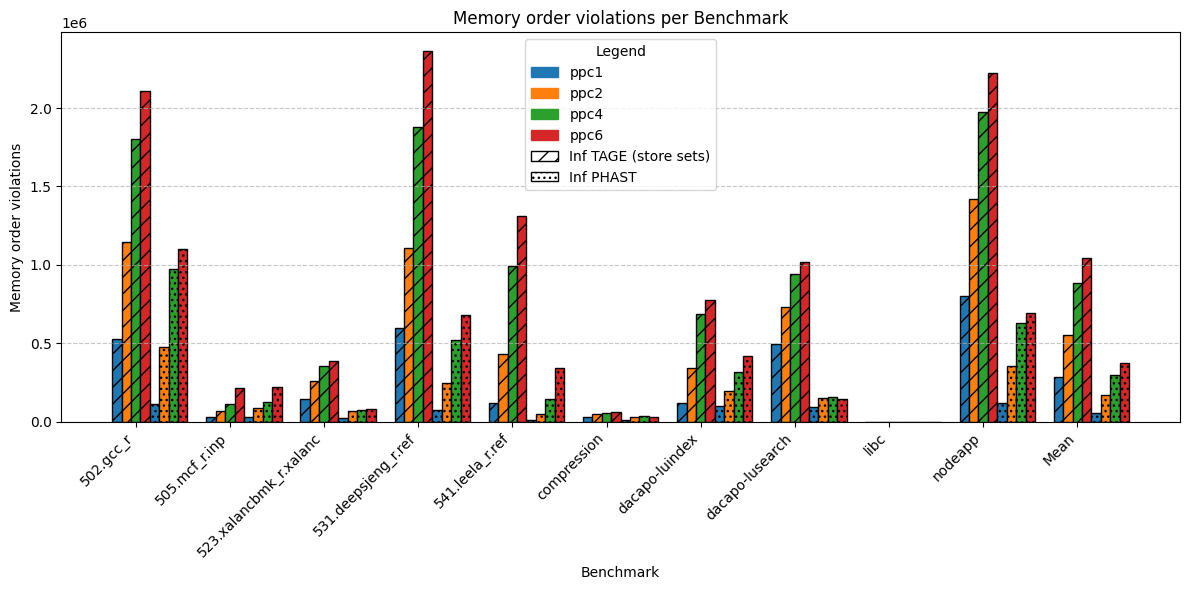

In [301]:
tmp_comparison_ocs_it_inf_phast_df = comparison_ocs_it_inf_phast_df.copy()

tmp_comparison_ocs_it_inf_phast_df['experiment'] = tmp_comparison_ocs_it_inf_phast_df['experiment'].replace('arm64_ocs_inf_tage_w36_f3_ppc1', 'Inf TAGE ppc1')
tmp_comparison_ocs_it_inf_phast_df['experiment'] = tmp_comparison_ocs_it_inf_phast_df['experiment'].replace('arm64_ocs_inf_tage_w36_f3_ppc2', 'Inf TAGE ppc2')
tmp_comparison_ocs_it_inf_phast_df['experiment'] = tmp_comparison_ocs_it_inf_phast_df['experiment'].replace('arm64_ocs_inf_tage_w36_f3_ppc4', 'Inf TAGE ppc4')
tmp_comparison_ocs_it_inf_phast_df['experiment'] = tmp_comparison_ocs_it_inf_phast_df['experiment'].replace('arm64_ocs_inf_tage_w36_f3_ppc6', 'Inf TAGE ppc6')

tmp_comparison_ocs_it_inf_phast_df['experiment'] = tmp_comparison_ocs_it_inf_phast_df['experiment'].replace('arm64_ocs_it_inf_phast_w36_f3_ppc1', 'Inf PHAST ppc1')
tmp_comparison_ocs_it_inf_phast_df['experiment'] = tmp_comparison_ocs_it_inf_phast_df['experiment'].replace('arm64_ocs_it_inf_phast_w36_f3_ppc2', 'Inf PHAST ppc2')
tmp_comparison_ocs_it_inf_phast_df['experiment'] = tmp_comparison_ocs_it_inf_phast_df['experiment'].replace('arm64_ocs_it_inf_phast_w36_f3_ppc4', 'Inf PHAST ppc4')
tmp_comparison_ocs_it_inf_phast_df['experiment'] = tmp_comparison_ocs_it_inf_phast_df['experiment'].replace('arm64_ocs_it_inf_phast_w36_f3_ppc6', 'Inf PHAST ppc6')

it_tmp_df = filterBenchExperiment(tmp_comparison_ocs_it_inf_phast_df, experiment_like="TAGE", only_benchs=considered_benchs)
it_tmp_df["set"] = "Inf TAGE (store sets)"
ip_tmp_df = filterBenchExperiment(tmp_comparison_ocs_it_inf_phast_df, experiment_like="PHAST", only_benchs=considered_benchs)
ip_tmp_df["set"] = "Inf PHAST"



barPlotY(tmp_comparison_ocs_it_inf_phast_df, y = "memOrderViolations", experiment_like="", label= "Memory order violations" , only_benchs=considered_benchs, legend_out=True , show_means=True,  save_as="")
barPlotY_B([it_tmp_df, ip_tmp_df], y = "memOrderViolations", experiment_like="", label= "Memory order violations" , only_benchs=considered_benchs, legend_out=False , show_means=True,  save_as="memOrderViolations_inf_phast_w36")


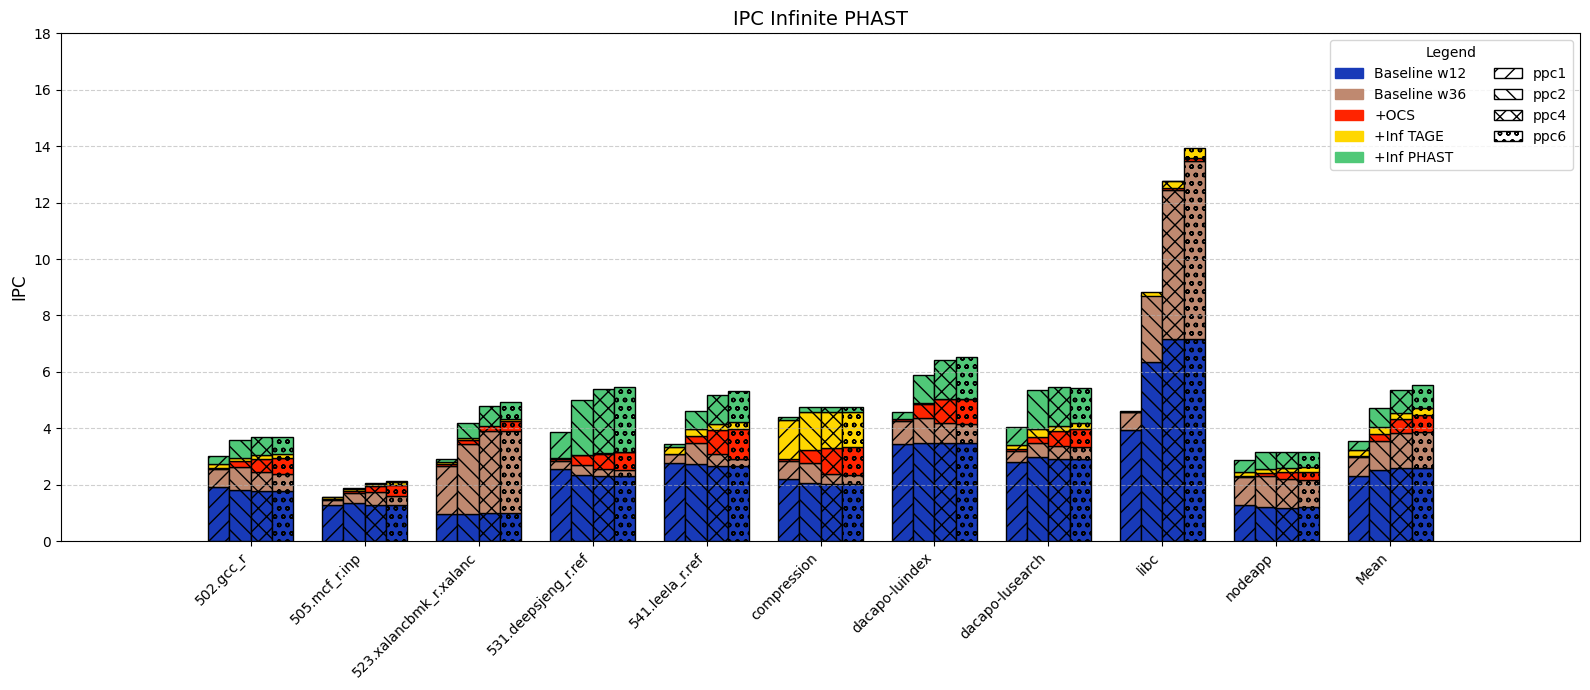

In [200]:
tmp_baseline_w12 = filterBenchExperiment(baseline_df, experiment_like="w12", only_benchs=considered_benchs)
tmp_baseline_w36 = filterBenchExperiment(baseline_df, experiment_like="w36", only_benchs=considered_benchs)
tmp_ocs_df = filterBenchExperiment(big_squash_rs_df, experiment_like="w36", only_benchs=considered_benchs)
tmp_ocs_it_df = filterBenchExperiment(ocs_inf_tage_df, experiment_like="w36", only_benchs=considered_benchs)
tmp_ocs_it_ip_df = filterBenchExperiment(ocs_it_inf_phast_df, experiment_like="w36", only_benchs=considered_benchs)

dfs = [tmp_baseline_w12, tmp_baseline_w36, tmp_ocs_df, ocs_inf_tage_df, tmp_ocs_it_ip_df]
labels = [ "Baseline w12" , "Baseline w36", "+OCS", "+Inf TAGE", "+Inf PHAST"]

plot_incremental_from_dfs(dfs, labels, experiment_col="ppc", ylabel="IPC", title="IPC Infinite PHAST", ymax=18, show_means=True ,  save_as="IPC_INF_PHAST")


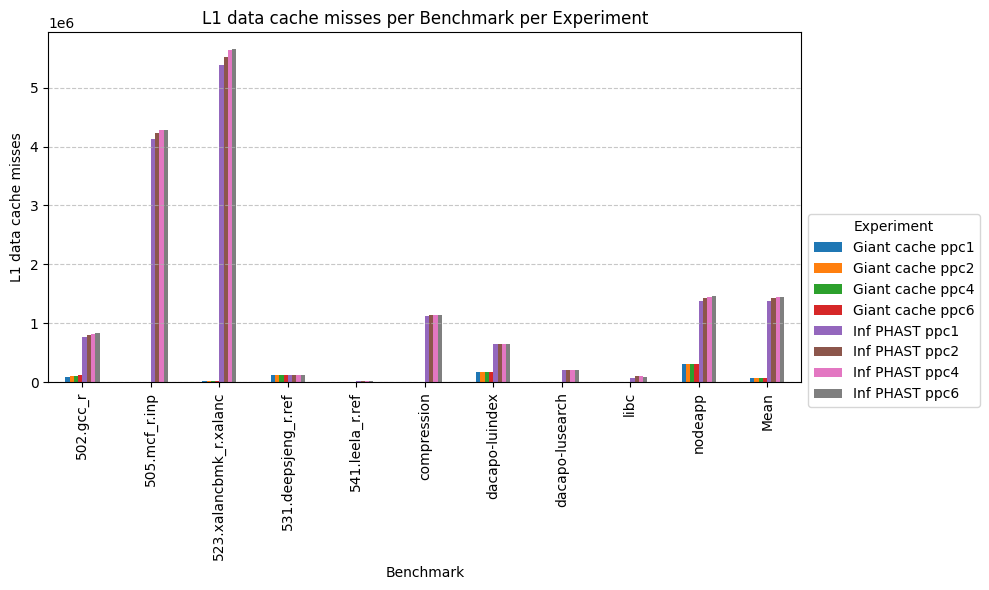

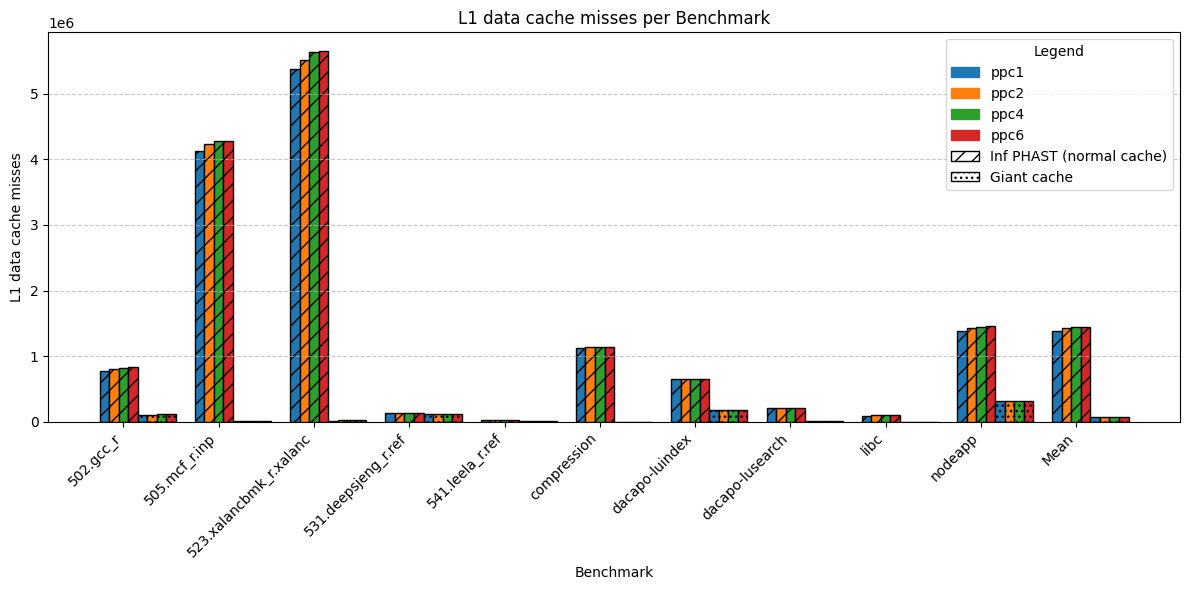

In [300]:
tmp_comparison_giant_cache_df = comparisonocs_it_ip_giant_cache_df.copy()

tmp_comparison_giant_cache_df['experiment'] = tmp_comparison_giant_cache_df['experiment'].replace('arm64_ocs_it_inf_phast_w36_f3_ppc1', 'Inf PHAST ppc1')
tmp_comparison_giant_cache_df['experiment'] = tmp_comparison_giant_cache_df['experiment'].replace('arm64_ocs_it_inf_phast_w36_f3_ppc2', 'Inf PHAST ppc2')
tmp_comparison_giant_cache_df['experiment'] = tmp_comparison_giant_cache_df['experiment'].replace('arm64_ocs_it_inf_phast_w36_f3_ppc4', 'Inf PHAST ppc4')
tmp_comparison_giant_cache_df['experiment'] = tmp_comparison_giant_cache_df['experiment'].replace('arm64_ocs_it_inf_phast_w36_f3_ppc6', 'Inf PHAST ppc6')

tmp_comparison_giant_cache_df['experiment'] = tmp_comparison_giant_cache_df['experiment'].replace('arm64_ocs_it_inf_ip_giant_cache_w36_f3_ppc1', 'Giant cache ppc1')
tmp_comparison_giant_cache_df['experiment'] = tmp_comparison_giant_cache_df['experiment'].replace('arm64_ocs_it_inf_ip_giant_cache_w36_f3_ppc2', 'Giant cache ppc2')
tmp_comparison_giant_cache_df['experiment'] = tmp_comparison_giant_cache_df['experiment'].replace('arm64_ocs_it_inf_ip_giant_cache_w36_f3_ppc4', 'Giant cache ppc4')
tmp_comparison_giant_cache_df['experiment'] = tmp_comparison_giant_cache_df['experiment'].replace('arm64_ocs_it_inf_ip_giant_cache_w36_f3_ppc6', 'Giant cache ppc6')


ip_tmp_df = filterBenchExperiment(tmp_comparison_giant_cache_df, experiment_like="PHAST", only_benchs=considered_benchs)
ip_tmp_df["set"] = "Inf PHAST (normal cache)"
gc_tmp_df = filterBenchExperiment(tmp_comparison_giant_cache_df, experiment_like="Giant", only_benchs=considered_benchs)
gc_tmp_df["set"] = "Giant cache"


barPlotY(tmp_comparison_giant_cache_df, y = "l1dcacheMisses", experiment_like="", label= "L1 data cache misses" , only_benchs=considered_benchs, legend_out=True, show_means=True,  save_as="")
barPlotY_B([ip_tmp_df, gc_tmp_df], y = "l1dcacheMisses", experiment_like="", label= "L1 data cache misses" , only_benchs=considered_benchs, legend_out=False, show_means=True,  save_as="L1Dcachemisses_giant_cache_w36")


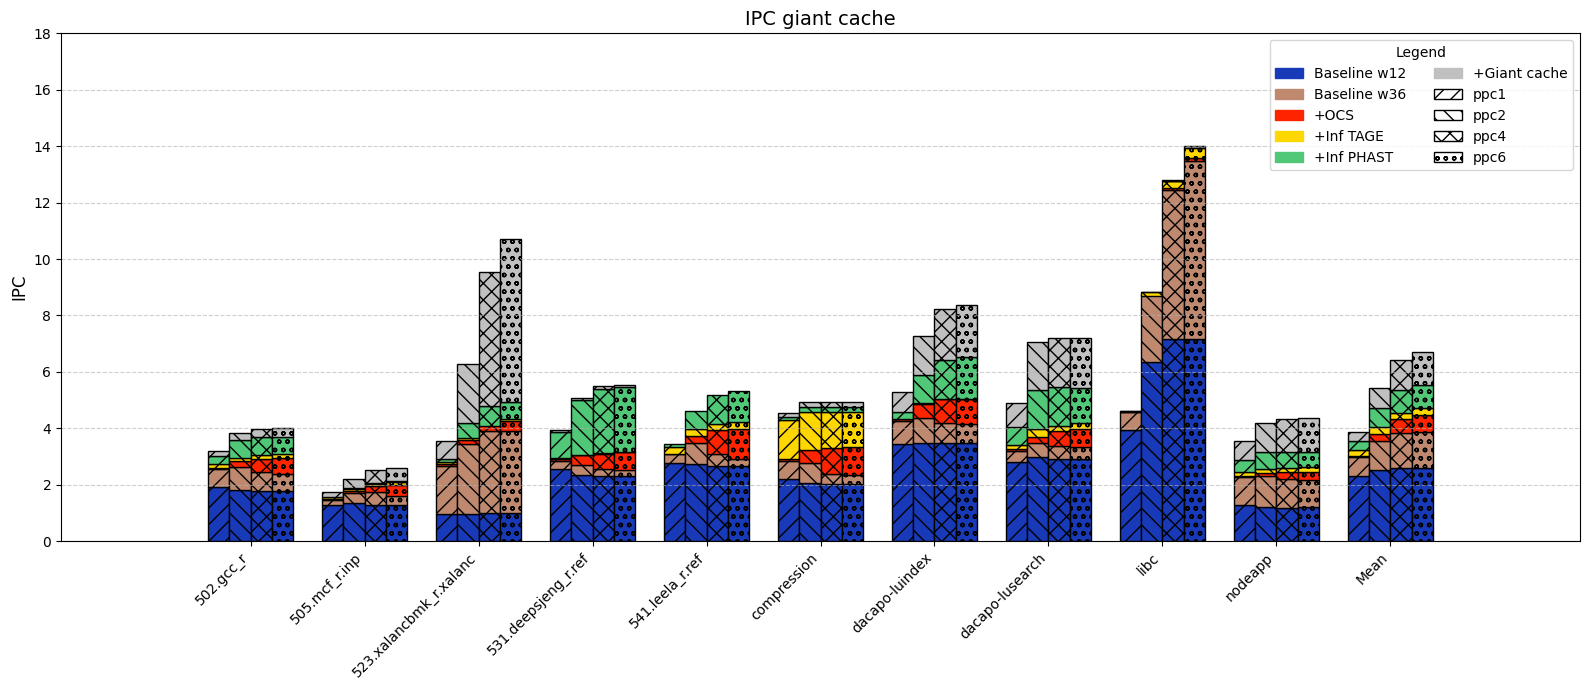

In [199]:
tmp_baseline_w12 = filterBenchExperiment(baseline_df, experiment_like="w12", only_benchs=considered_benchs)
tmp_baseline_w36 = filterBenchExperiment(baseline_df, experiment_like="w36", only_benchs=considered_benchs)
tmp_ocs_df = filterBenchExperiment(big_squash_rs_df, experiment_like="w36", only_benchs=considered_benchs)
tmp_ocs_it_df = filterBenchExperiment(ocs_inf_tage_df, experiment_like="w36", only_benchs=considered_benchs)
tmp_ocs_it_ip_df = filterBenchExperiment(ocs_it_inf_phast_df, experiment_like="w36", only_benchs=considered_benchs)
tmp_ocs_it_ip_gc_df = filterBenchExperiment(ocs_it_ip_giant_cache_df, experiment_like="w36", only_benchs=considered_benchs)


dfs = [tmp_baseline_w12, tmp_baseline_w36, tmp_ocs_df, ocs_inf_tage_df, tmp_ocs_it_ip_df, tmp_ocs_it_ip_gc_df]
labels = [ "Baseline w12" , "Baseline w36", "+OCS", "+Inf TAGE", "+Inf PHAST", "+Giant cache"]

plot_incremental_from_dfs(dfs, labels, experiment_col="ppc", ylabel="IPC", title="IPC giant cache", ymax=18, show_means=True ,  save_as="IPC_GIANT_CACHE")


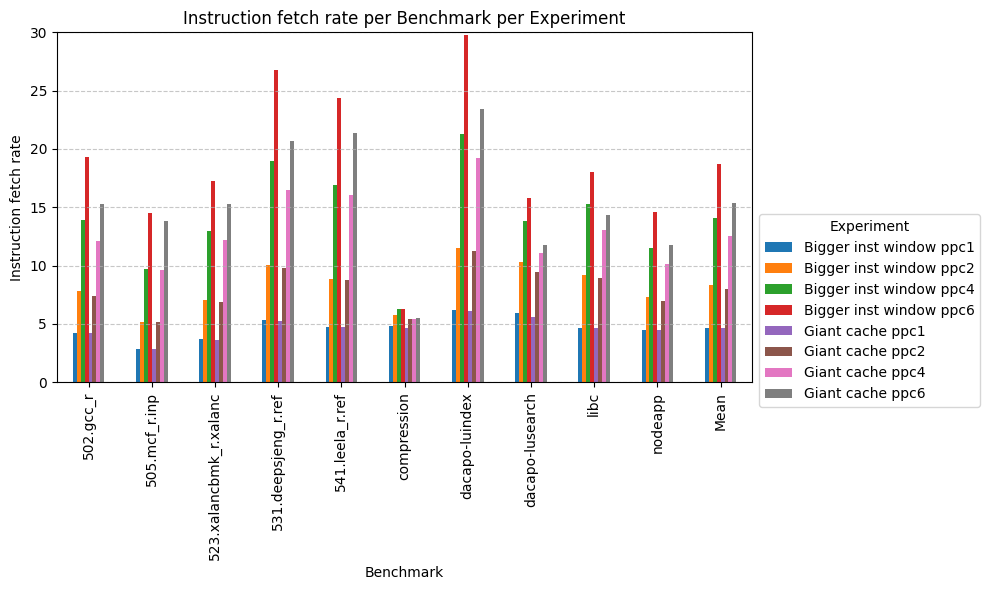

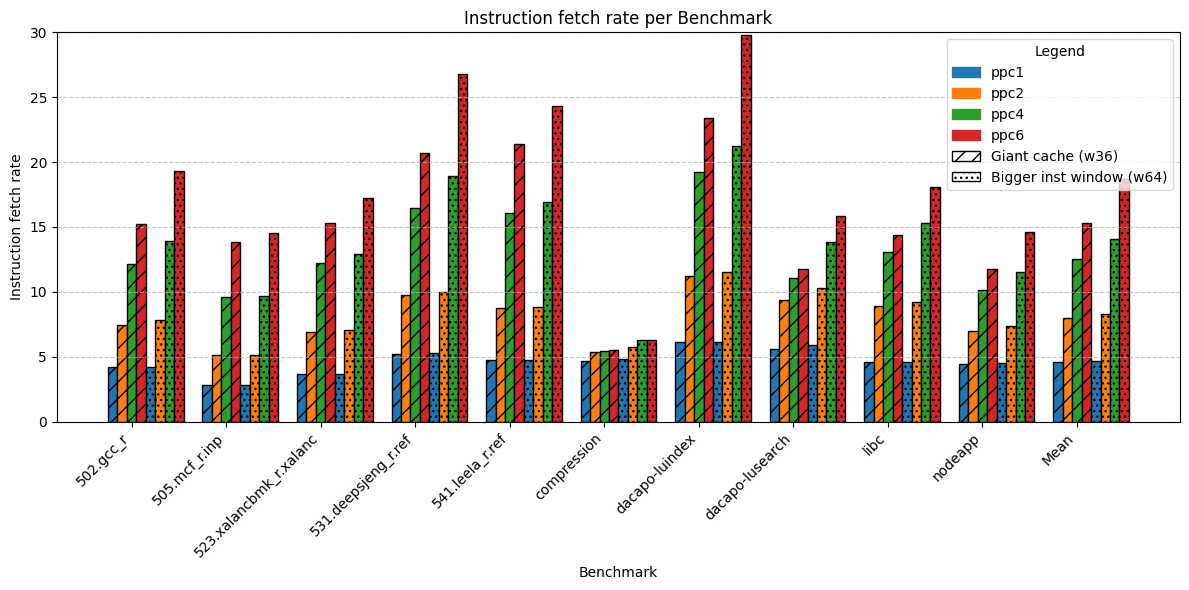

In [299]:
gc_tmp_df = filterBenchExperiment(comparison_bigger_pipeline_df, experiment_like="Giant", only_benchs=considered_benchs)
gc_tmp_df["set"] = "Giant cache (w36)"

big_tmp_df = filterBenchExperiment(comparison_bigger_pipeline_df, experiment_like="inst", only_benchs=considered_benchs)
big_tmp_df["set"] = "Bigger inst window (w64)"

barPlotY(comparison_bigger_pipeline_df, y = "fetchRate", experiment_like="", label= "Instruction fetch rate" , ylim= 30, only_benchs=considered_benchs, legend_out=True , show_means=True, save_as="")
barPlotY_B([gc_tmp_df, big_tmp_df], y = "fetchRate", experiment_like="", label= "Instruction fetch rate" , ylim= 30, only_benchs=considered_benchs, legend_out=False , show_means=True, save_as="fetchRate_bigger_window")

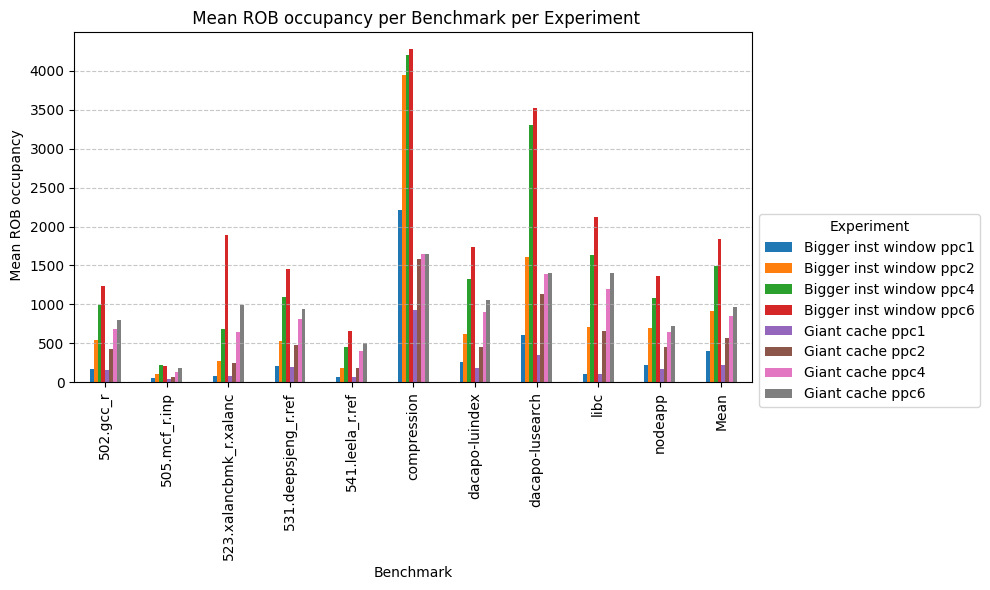

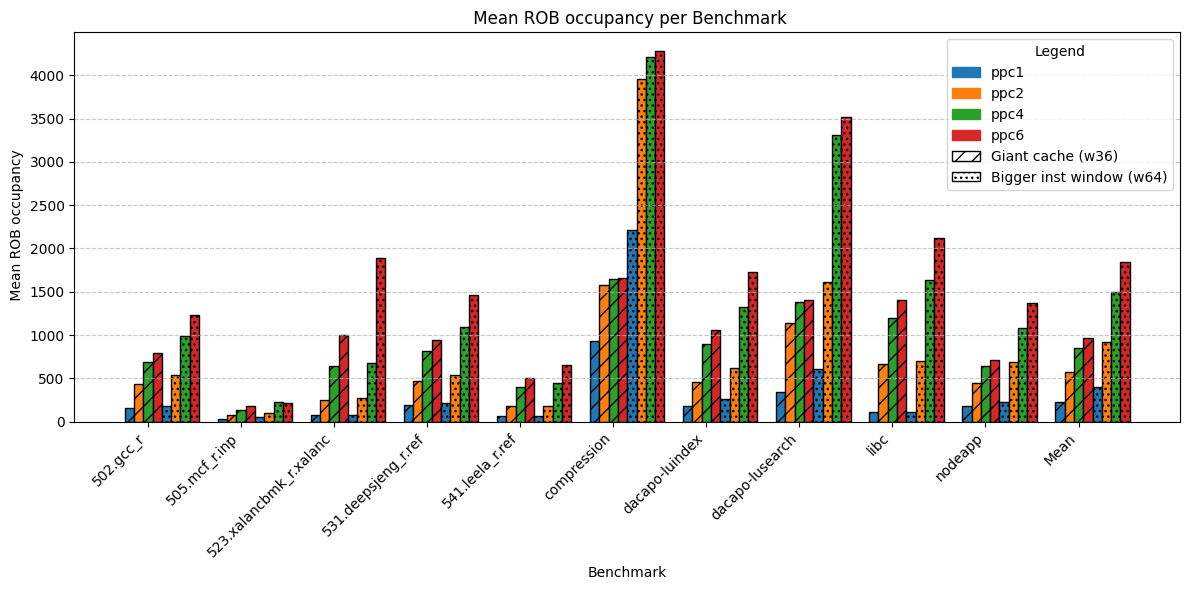

In [298]:
gc_tmp_df = filterBenchExperiment(comparison_bigger_pipeline_df, experiment_like="Giant", only_benchs=considered_benchs)
gc_tmp_df["set"] = "Giant cache (w36)"

big_tmp_df = filterBenchExperiment(comparison_bigger_pipeline_df, experiment_like="inst", only_benchs=considered_benchs)
big_tmp_df["set"] = "Bigger inst window (w64)"

barPlotY(comparison_bigger_pipeline_df, y = "ROB mean occupancy" , label=" Mean ROB occupancy" ,  experiment_like="" , only_benchs=considered_benchs, legend_out=True , show_means=True, save_as="")
barPlotY_B([gc_tmp_df, big_tmp_df], y = "ROB mean occupancy" , label=" Mean ROB occupancy" ,  experiment_like="" , only_benchs=considered_benchs, legend_out=False , show_means=True, save_as="robOccupancy_bigger_window")


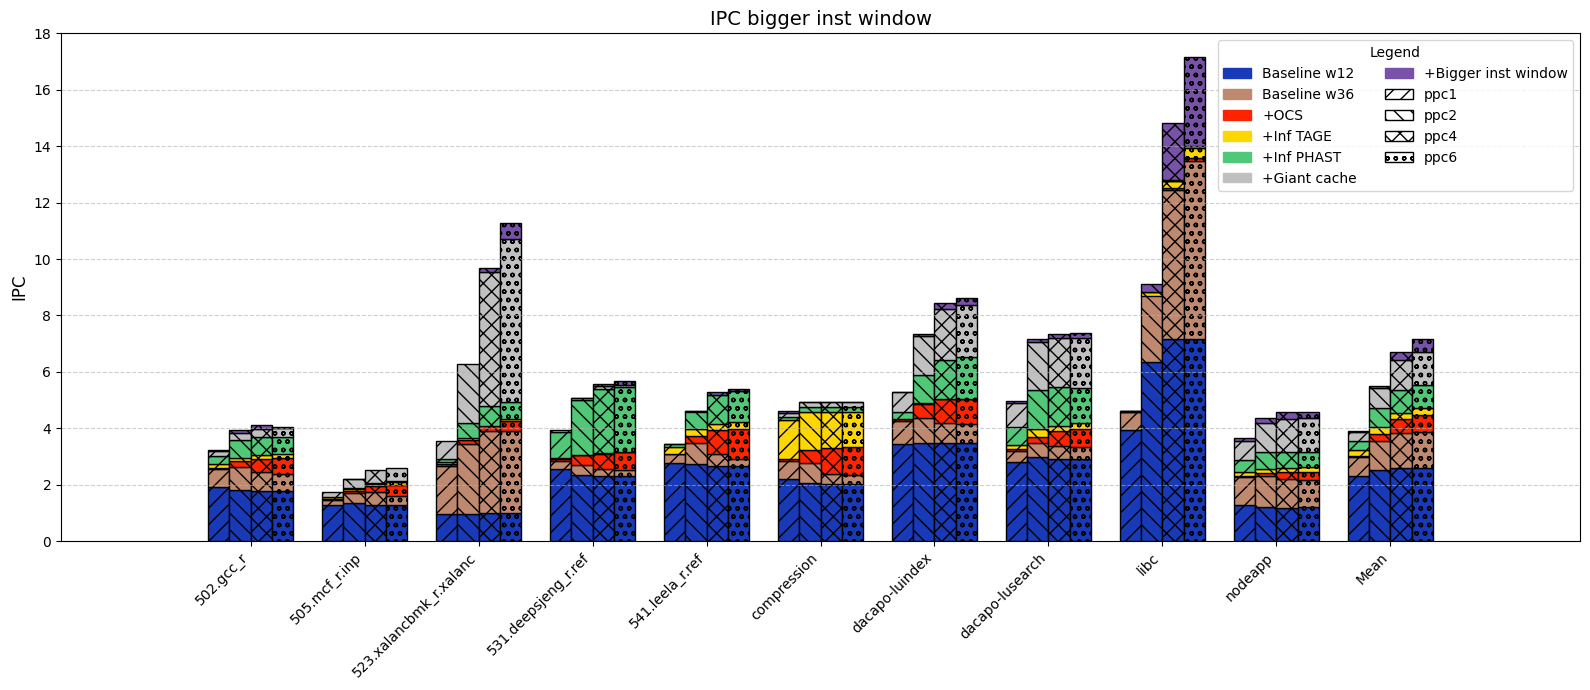

In [198]:
tmp_baseline_w12 = filterBenchExperiment(baseline_df, experiment_like="w12", only_benchs=considered_benchs)
tmp_baseline_w36 = filterBenchExperiment(baseline_df, experiment_like="w36", only_benchs=considered_benchs)
tmp_ocs_df = filterBenchExperiment(big_squash_rs_df, experiment_like="w36", only_benchs=considered_benchs)
tmp_ocs_it_df = filterBenchExperiment(ocs_inf_tage_df, experiment_like="w36", only_benchs=considered_benchs)
tmp_ocs_it_ip_df = filterBenchExperiment(ocs_it_inf_phast_df, experiment_like="w36", only_benchs=considered_benchs)
tmp_ocs_it_ip_gc_df = filterBenchExperiment(ocs_it_ip_giant_cache_df, experiment_like="w36", only_benchs=considered_benchs)
tmp_bigger_pipeline_df = filterBenchExperiment(bigger_pipeline_df, experiment_like="",  only_benchs=considered_benchs)


dfs = [tmp_baseline_w12, tmp_baseline_w36, tmp_ocs_df, ocs_inf_tage_df, tmp_ocs_it_ip_df, tmp_ocs_it_ip_gc_df, tmp_bigger_pipeline_df]
labels = [ "Baseline w12" , "Baseline w36", "+OCS", "+Inf TAGE", "+Inf PHAST", "+Giant cache", "+Bigger inst window"]

plot_incremental_from_dfs(dfs, labels, experiment_col="ppc", ylabel="IPC", title="IPC bigger inst window", ymax=18, show_means=True,  save_as="IPC_Inst_window")


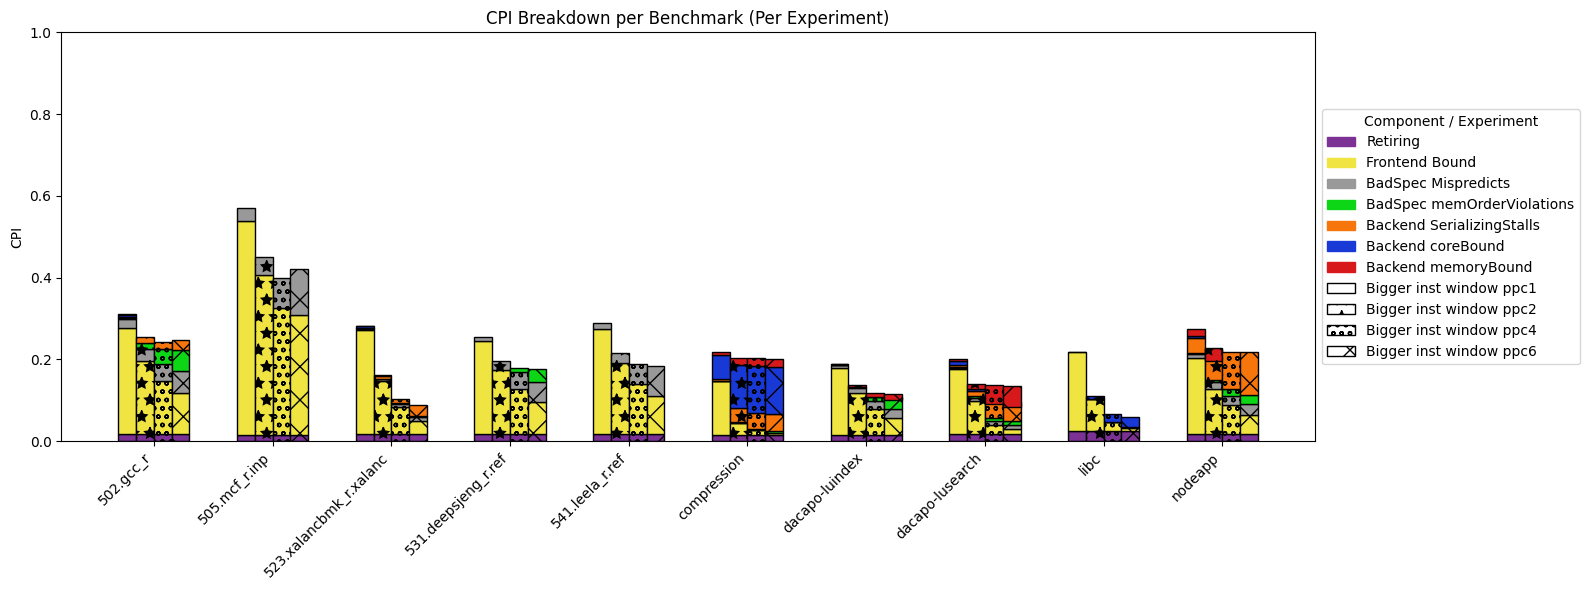

In [144]:
plotCPIStack(bigger_pipeline_df, experiment_like = r'', only_benchs=considered_benchs, mean = True, m_cpi = True, detailed = True, ymax=1,  save_as="L2_cpi_stack_bigger_inst_window") 


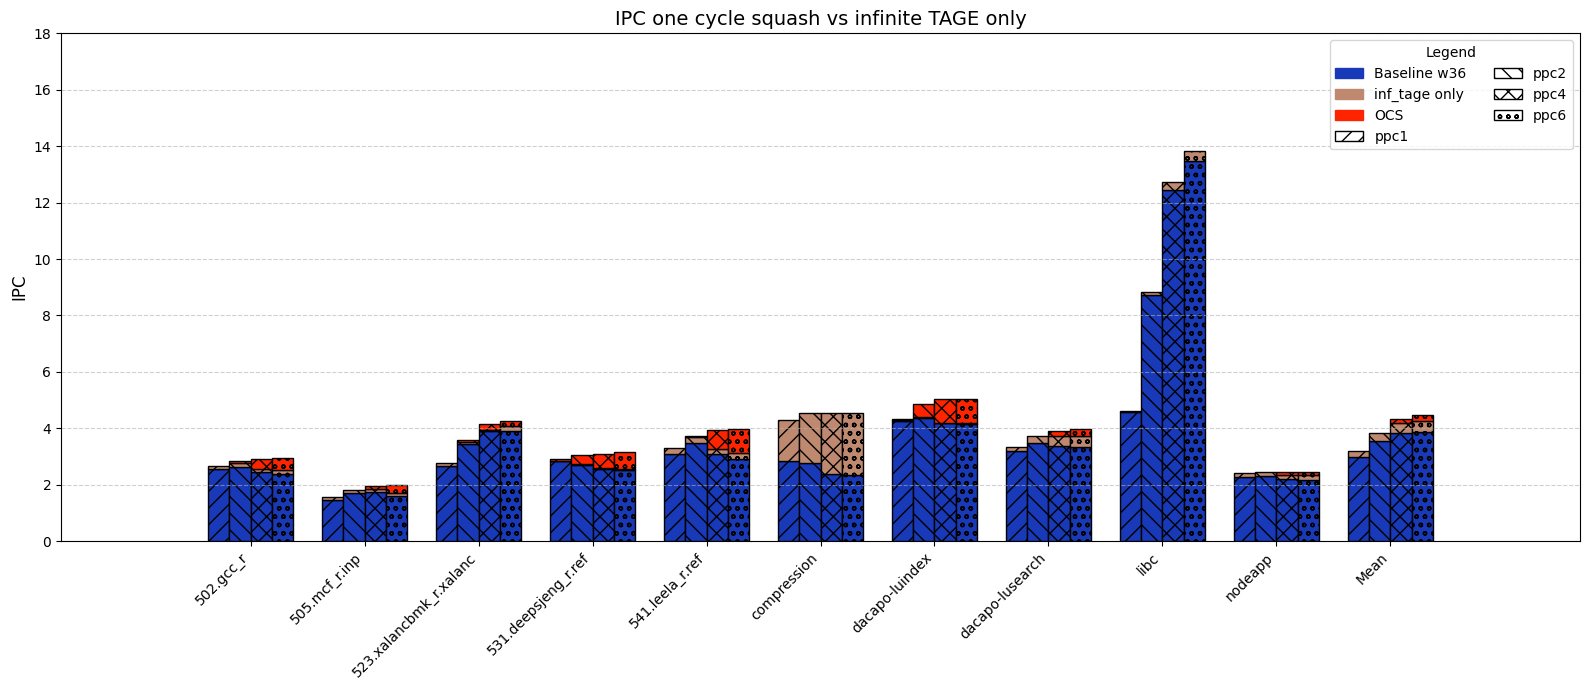

In [223]:
tmp_baseline_w36 = filterBenchExperiment(baseline_df, experiment_like="w36", only_benchs=considered_benchs)
tmp_inf_tage_no_big_squash_df =  filterBenchExperiment(inf_tage_no_big_squash_df, experiment_like="w36", only_benchs=considered_benchs)
tmp_ocs_df = filterBenchExperiment(big_squash_rs_df, experiment_like="w36",only_benchs=considered_benchs)

dfs = [tmp_baseline_w36, tmp_inf_tage_no_big_squash_df , tmp_ocs_df ]
labels = [ "Baseline w36",  "inf_tage only" , "OCS" ]

plot_incremental_from_dfs(dfs, labels, experiment_col="ppc", ylabel="IPC", title="IPC one cycle squash vs infinite TAGE only", ymax=18, show_means=True , save_as="IPC_OCS_VS_INF_TAGE_ONLY")


### IPC Stack

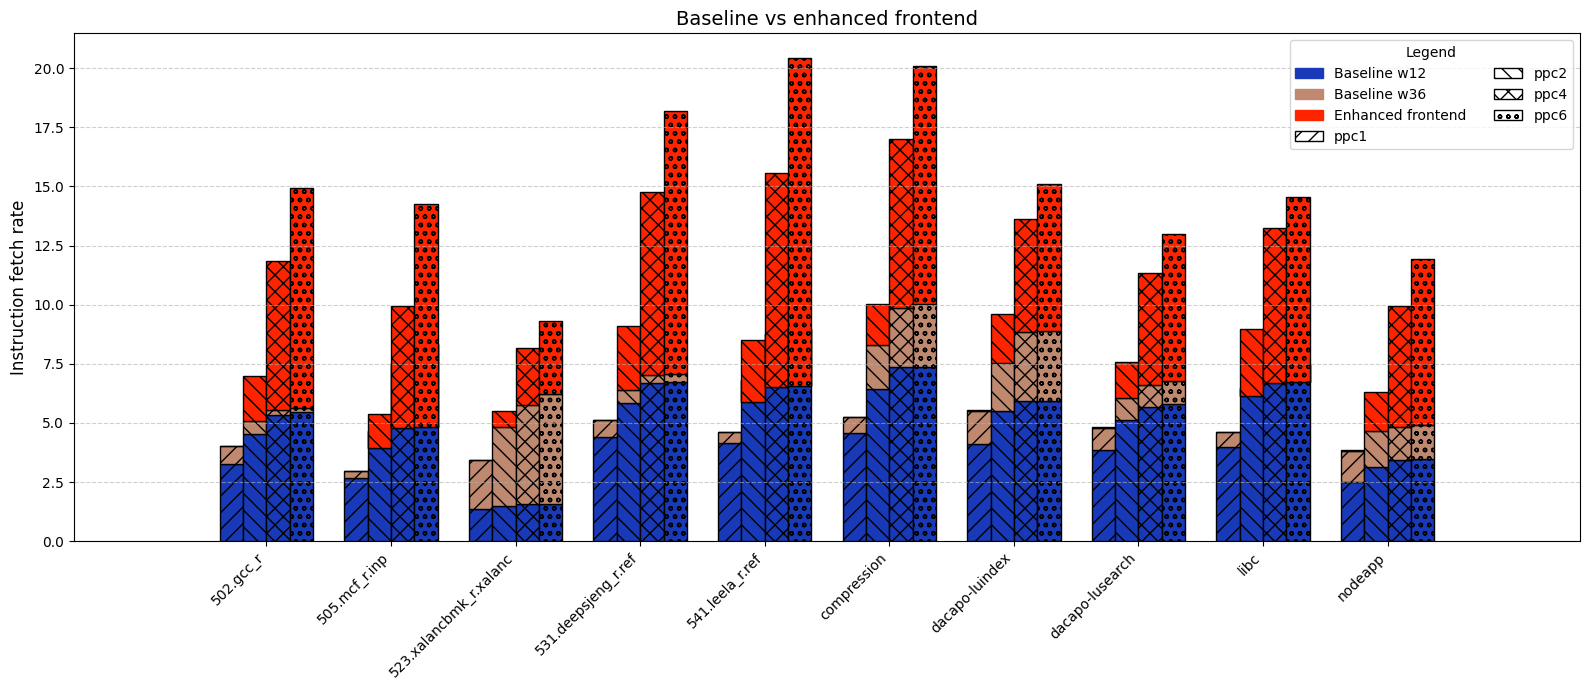

In [194]:
tmp_baseline_w12 = filterBenchExperiment(baseline_df, experiment_like="w12", exclude_benchs=excluded)
tmp_baseline_df = filterBenchExperiment(baseline_df, experiment_like="w36", exclude_benchs=excluded)
tmp_frontend_baseline_df = filterBenchExperiment(frontend_baseline_df, experiment_like="w36", exclude_benchs=excluded)


dfs = [tmp_baseline_w12, tmp_frontend_baseline_df, tmp_baseline_df]
labels = [ "Baseline w12", "Baseline w36" , "Enhanced frontend"]
plot_incremental_from_dfs(dfs, labels, experiment_col="ppc", value_col = "fetchRate",  ylabel="Instruction fetch rate", title="Baseline vs enhanced frontend", save_as="")


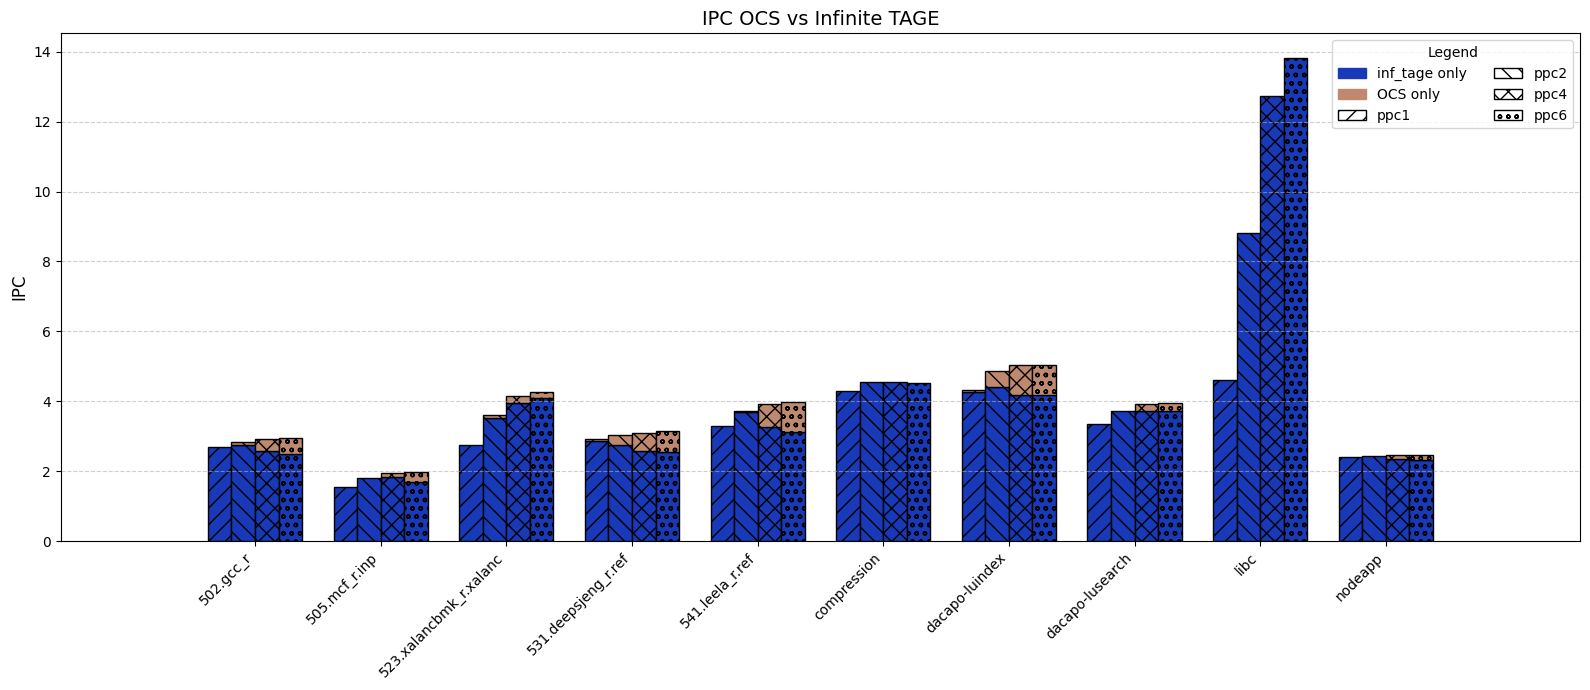

In [228]:
tmp_baseline_w12 = filterBenchExperiment(baseline_df, experiment_like="w12", exclude_benchs=excluded)
tmp_baseline_df = filterBenchExperiment(baseline_df, experiment_like="w36", exclude_benchs=excluded)
tmp_inf_tage_no_big_squash_df =  filterBenchExperiment(inf_tage_no_big_squash_df, experiment_like="w36", exclude_benchs=excluded)
tmp_ocs_df = filterBenchExperiment(big_squash_rs_df, experiment_like="w36", exclude_benchs=excluded)

dfs = [tmp_inf_tage_no_big_squash_df , tmp_ocs_df ]
labels = [  "inf_tage only" , "OCS only" ]

plot_incremental_from_dfs(dfs, labels, experiment_col="ppc", ylabel="IPC", title="IPC OCS vs Infinite TAGE", save_as="IPC_OCS_VS_INF_TAGE_ONLY")


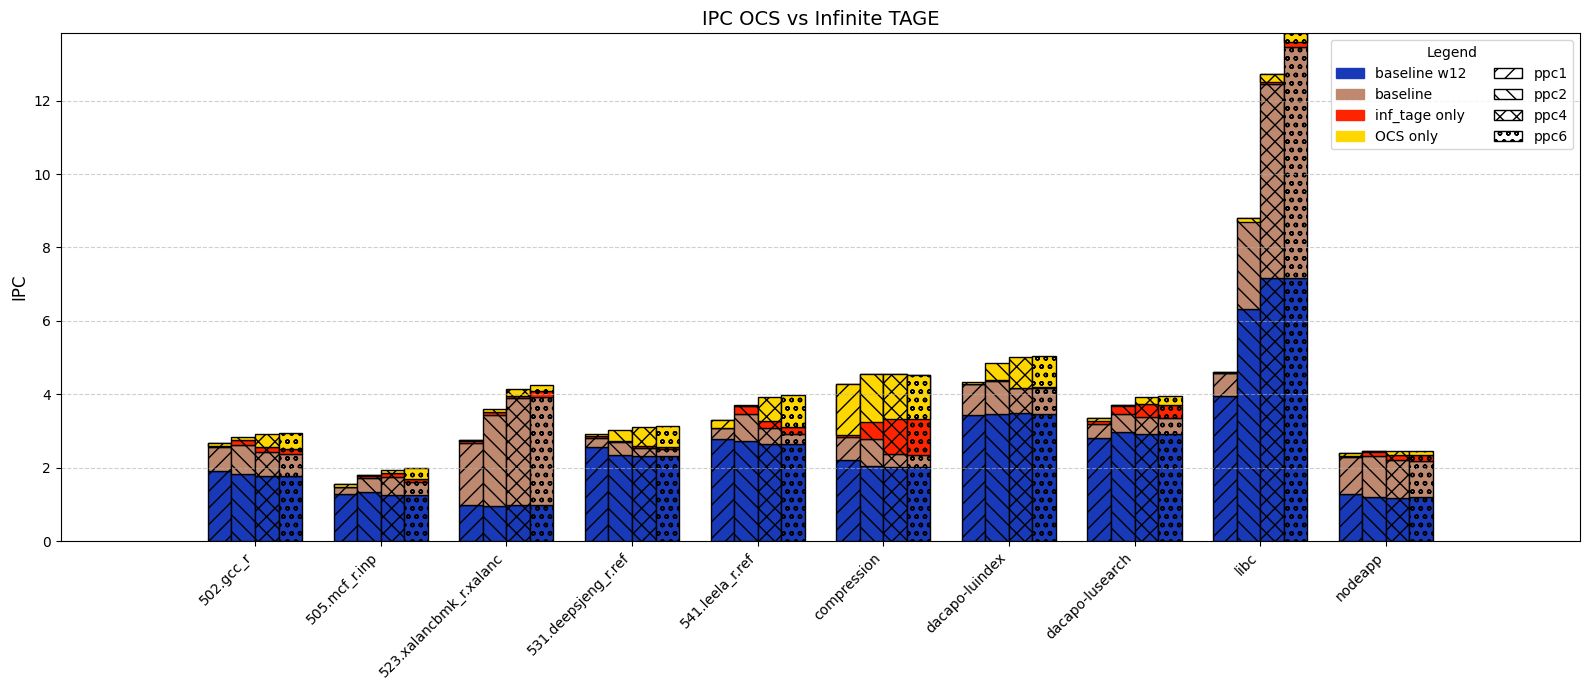

In [216]:
tmp_baseline_w12 = filterBenchExperiment(baseline_df, experiment_like="w12", exclude_benchs=excluded)
tmp_baseline_df = filterBenchExperiment(baseline_df, experiment_like="w36", exclude_benchs=excluded)
tmp_inf_tage_no_big_squash_df =  filterBenchExperiment(inf_tage_no_big_squash_df, experiment_like="w36", exclude_benchs=excluded)
tmp_ocs_df = filterBenchExperiment(big_squash_rs_df, experiment_like="w36", exclude_benchs=excluded)

dfs = [ tmp_baseline_w12, tmp_baseline_df, tmp_inf_tage_no_big_squash_df , tmp_ocs_df ]
labels = [ "baseline w12", "baseline" , "inf_tage only" , "OCS only" ]

plot_incremental_from_dfs(dfs, labels, experiment_col="ppc", ylabel="IPC", title="IPC OCS vs Infinite TAGE", save_as="")


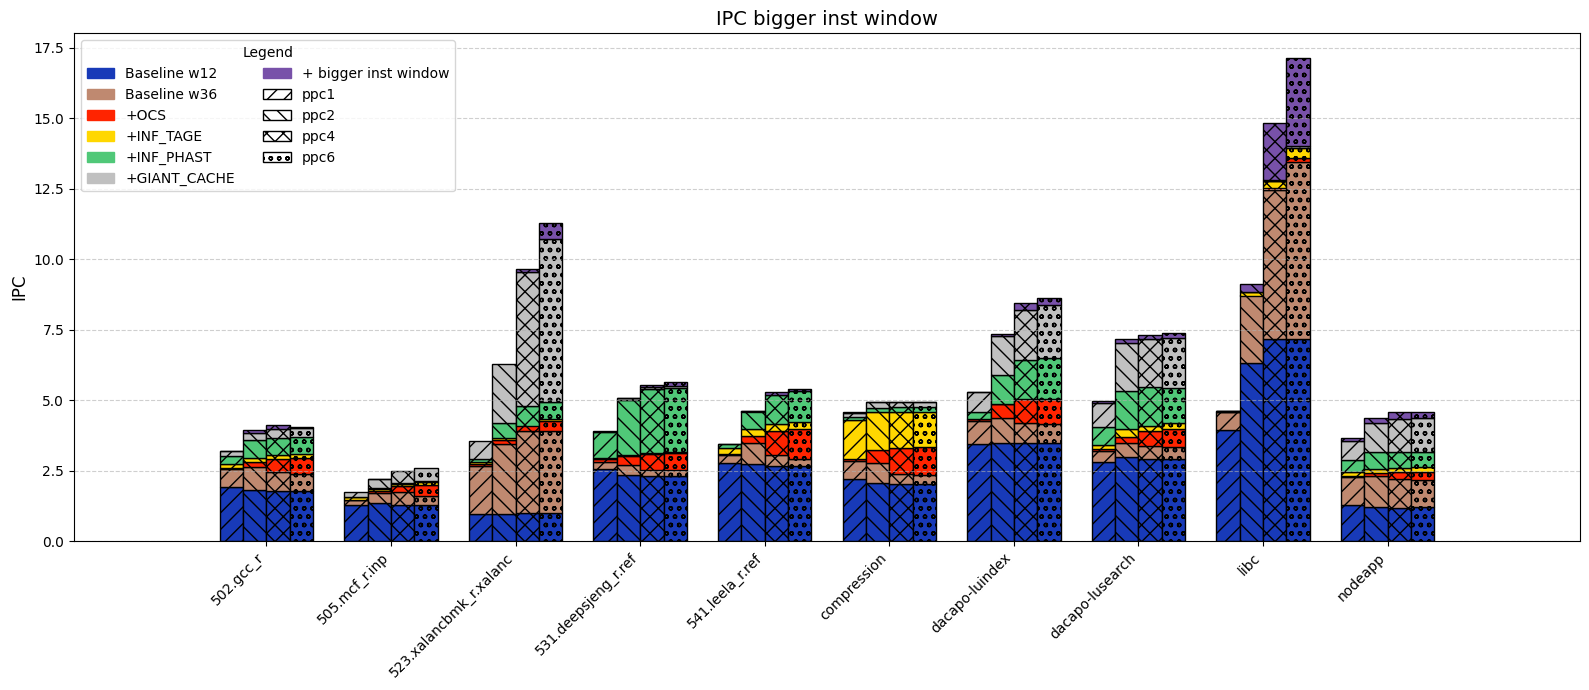

In [219]:
tmp_baseline_w12 = filterBenchExperiment(baseline_df, experiment_like="w12", exclude_benchs=excluded)
tmp_baseline_df = filterBenchExperiment(baseline_df, experiment_like="w36", exclude_benchs=excluded)
tmp_ocs_df = filterBenchExperiment(big_squash_rs_df, experiment_like="w36", exclude_benchs=excluded)
tmp_ocs_it_df = filterBenchExperiment(ocs_inf_tage_df, experiment_like="w36", exclude_benchs=excluded)
tmp_ocs_it_ip_df = filterBenchExperiment(ocs_it_inf_phast_df, experiment_like="w36", exclude_benchs=excluded)
tmp_ocs_it_ip_gc_df = filterBenchExperiment(ocs_it_ip_giant_cache_df, experiment_like="w36", exclude_benchs=excluded)
tmp_bigger_window_df = filterBenchExperiment(bigger_window_df, experiment_like="w36" , exclude_benchs=excluded)
tmp_bigger_pipeline_df = filterBenchExperiment(bigger_pipeline_df, experiment_like="" , exclude_benchs=excluded)

dfs = [tmp_baseline_w12, tmp_baseline_df, tmp_ocs_df , tmp_ocs_it_df, tmp_ocs_it_ip_df, tmp_ocs_it_ip_gc_df, tmp_bigger_pipeline_df]
labels = [ "Baseline w12" , "Baseline w36", "+OCS" , "+INF_TAGE", "+INF_PHAST", "+GIANT_CACHE", "+ bigger inst window" ]

plot_incremental_from_dfs(dfs, labels, experiment_col="ppc", ylabel="IPC", title="IPC bigger inst window", save_as="")


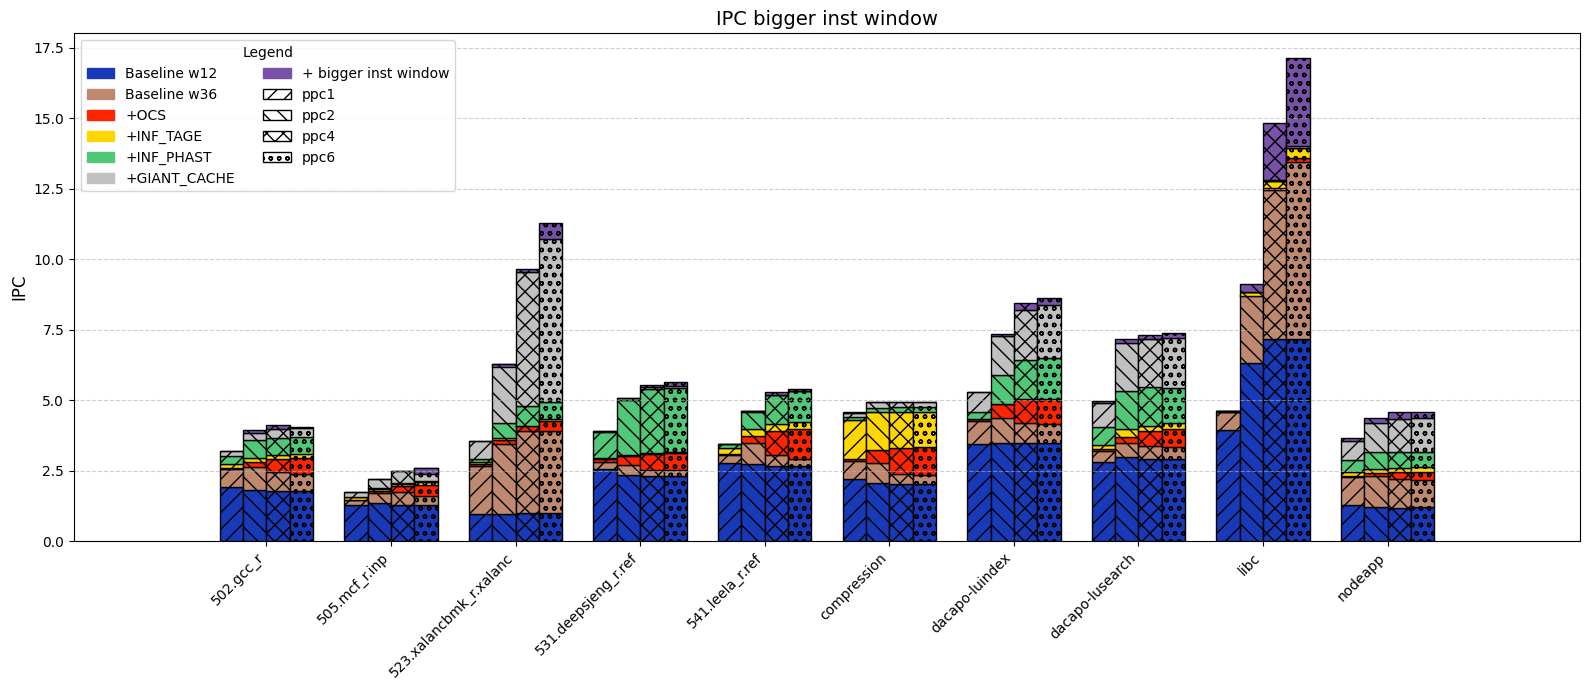

In [212]:
tmp_baseline_w12 = filterBenchExperiment(baseline_df, experiment_like="w12", exclude_benchs=excluded)
tmp_baseline_df = filterBenchExperiment(baseline_df, experiment_like="w36", exclude_benchs=excluded)
tmp_ocs_df = filterBenchExperiment(big_squash_rs_df, experiment_like="w36", exclude_benchs=excluded)
tmp_ocs_it_df = filterBenchExperiment(ocs_inf_tage_df, experiment_like="w36", exclude_benchs=excluded)
tmp_ocs_it_ip_df = filterBenchExperiment(ocs_it_inf_phast_df, experiment_like="w36", exclude_benchs=excluded)
tmp_ocs_it_ip_gc_df = filterBenchExperiment(ocs_it_ip_giant_cache_df, experiment_like="w36", exclude_benchs=excluded)
tmp_bigger_window_df = filterBenchExperiment(bigger_window_df, experiment_like="w36" , exclude_benchs=excluded)
tmp_bigger_pipeline_df = filterBenchExperiment(bigger_pipeline_df, experiment_like="" , exclude_benchs=excluded)

dfs = [tmp_baseline_w12, tmp_baseline_df, tmp_ocs_df , tmp_ocs_it_df, tmp_ocs_it_ip_df, tmp_ocs_it_ip_gc_df, tmp_bigger_pipeline_df]
labels = [ "Baseline w12" , "Baseline w36", "+OCS" , "+INF_TAGE", "+INF_PHAST", "+GIANT_CACHE", "+ bigger inst window" ]

plot_incremental_from_dfs(dfs, labels, experiment_col="ppc", ylabel="IPC", title="IPC bigger inst window", save_as="IPC_Inst_window")


### CPI Stack

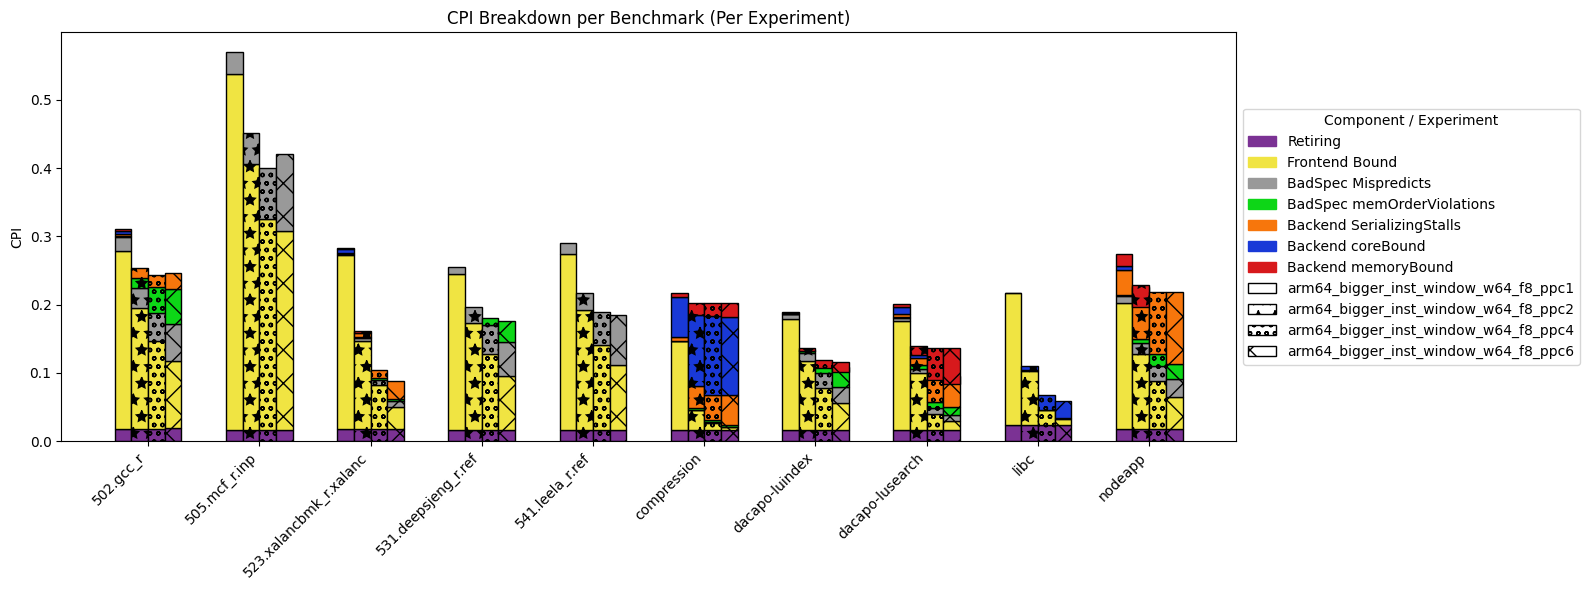

In [170]:
#plotCPIStack(ocs_inf_tage_df, experiment_like = r'', exclude_benchs = excluded, mean = True, m_cpi = True, detailed = True, save_as="") 
#plotCPIStack(big_squash_df, experiment_like = r'', exclude_benchs = excluded, mean = True, m_cpi = True, detailed = True) 
plotCPIStack(bigger_pipeline_df, experiment_like = r'', exclude_benchs = excluded, mean = True, m_cpi = True, detailed = True, save_as="L2_cpi_stack_bigger_inst_window") 

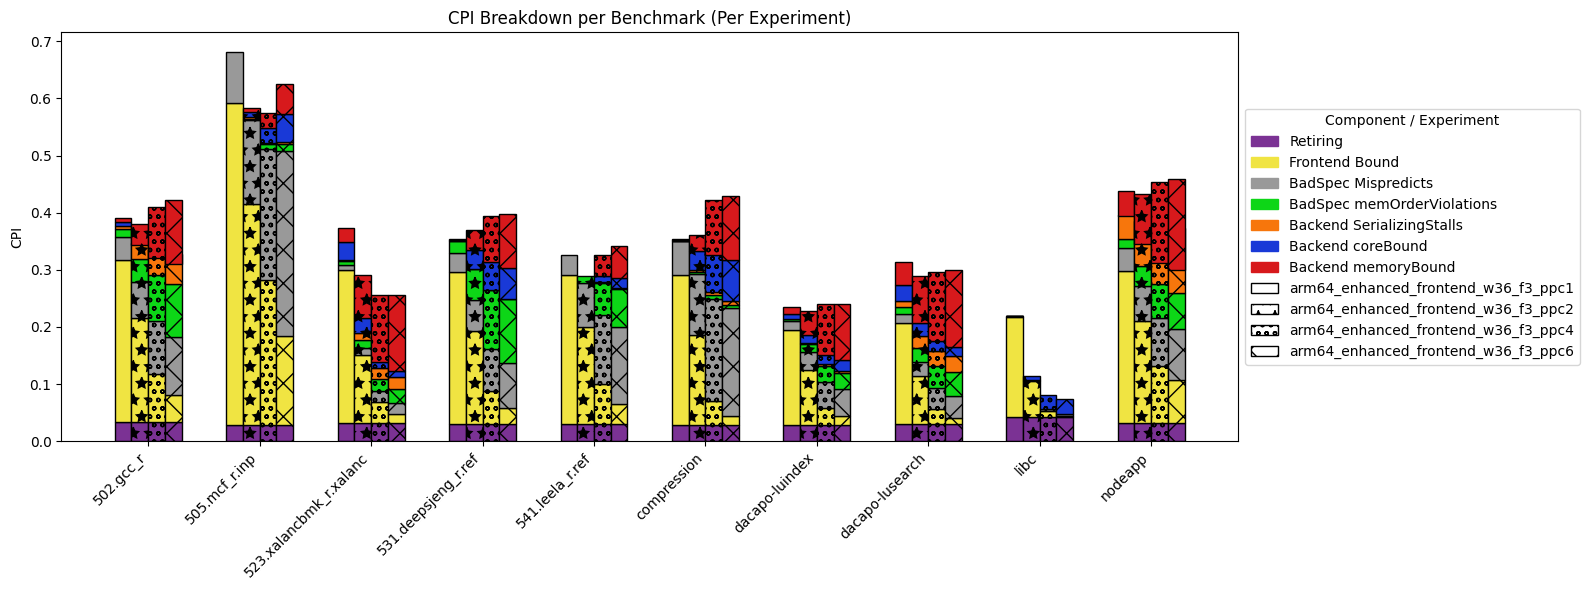

In [160]:
#plotCPIStack(ocs_inf_tage_df, experiment_like = r'', exclude_benchs = excluded, mean = True, m_cpi = True, detailed = True, save_as="") 
#plotCPIStack(big_squash_df, experiment_like = r'', exclude_benchs = excluded, mean = True, m_cpi = True, detailed = True) 
plotCPIStack(baseline_df, experiment_like = r'w36', exclude_benchs = excluded, mean = True, m_cpi = True, detailed = True) 

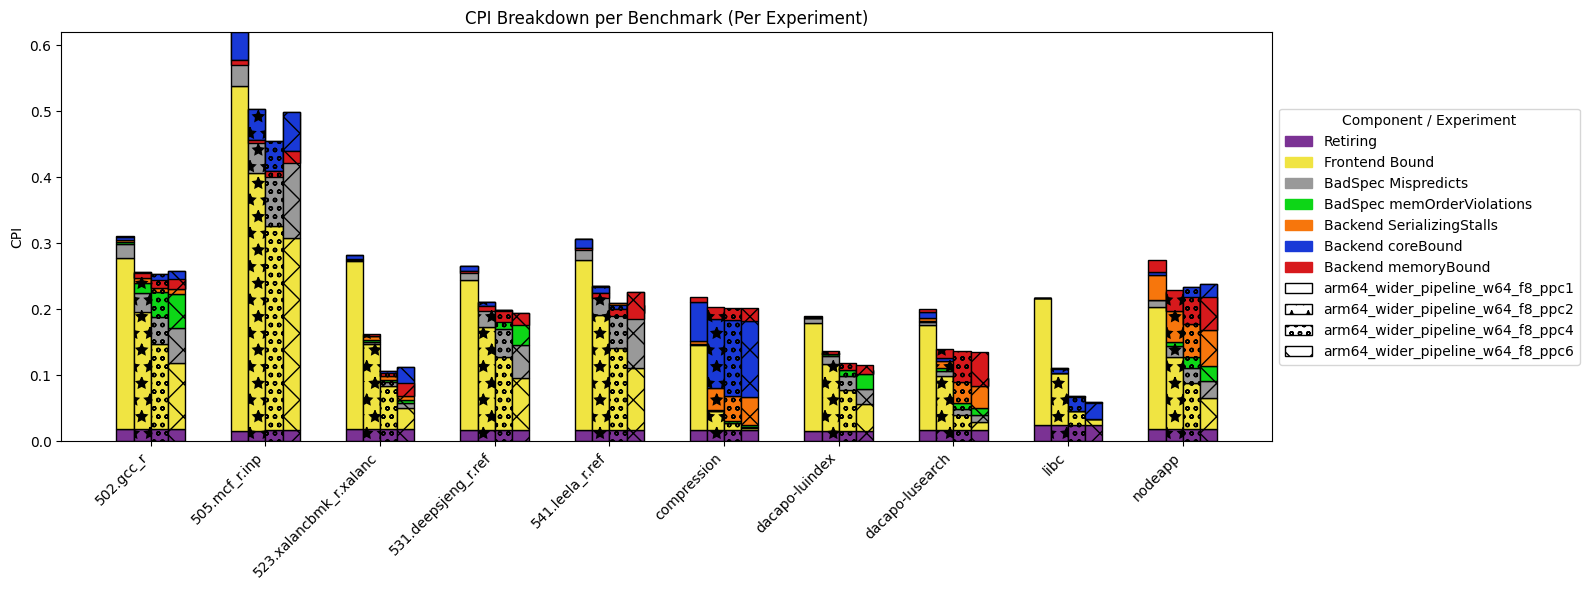

In [142]:
#plotCPIStack(ocs_inf_tage_df, experiment_like = r'', exclude_benchs = excluded, mean = True, m_cpi = True, detailed = True, save_as="") 
#plotCPIStack(big_squash_df, experiment_like = r'', exclude_benchs = excluded, mean = True, m_cpi = True, detailed = True) 
plotCPIStack(bigger_pipeline_df, experiment_like = r'', exclude_benchs = excluded, mean = True, m_cpi = True, detailed = True) 

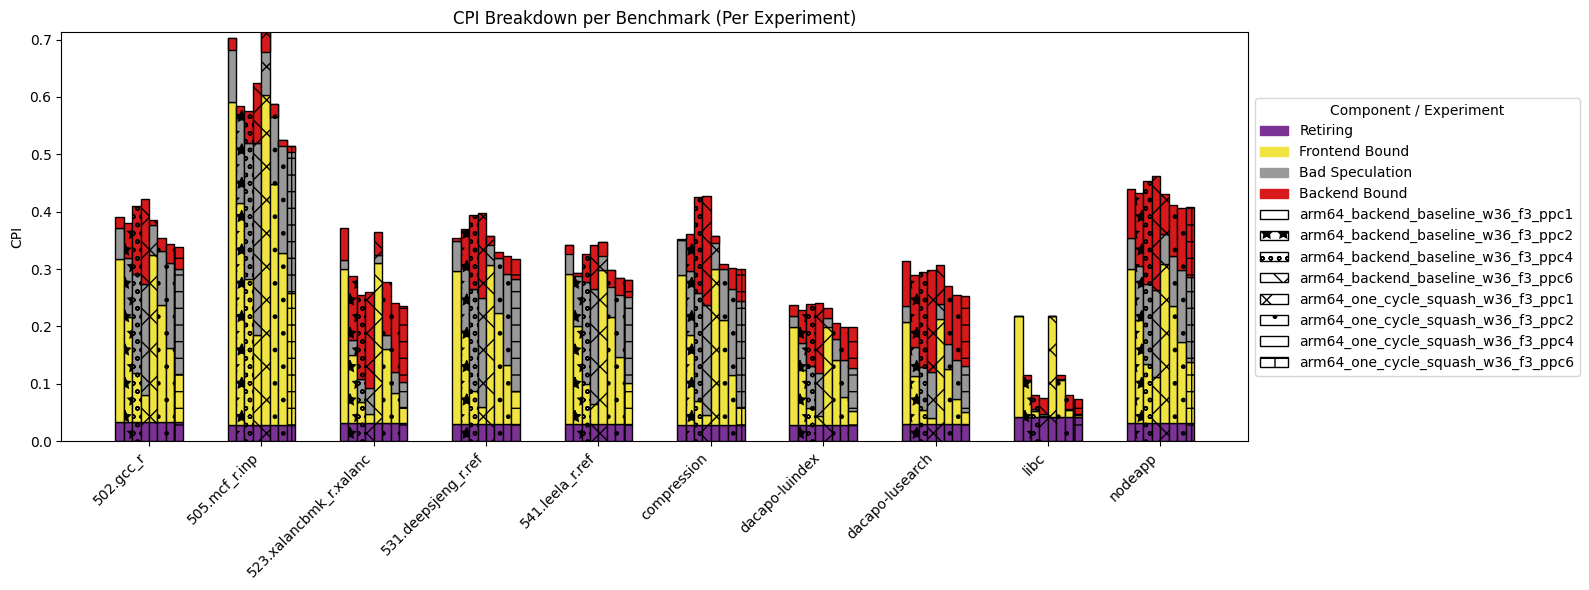

In [50]:
plotCPIStack(backend_comparison, experiment_like = r'w36', exclude_benchs = excluded, mean = False, m_cpi = True, detailed = False, save_as="") 
#plotCPIStack(big_squash_df, experiment_like = r'w36', exclude_benchs = excluded, mean = True, m_cpi = True, detailed = True) 

### Change of TopDown metrics

In [40]:
tmp_df = baseline_df[["experiment", "benchmark", "TopDownL1_frontendBound"]]
tmp_df = filterBenchExperiment(tmp_df, experiment_like=r'w36_f3_ppc1|w36_f3_ppc6', exclude_benchs=excluded)
change_df = tmp_df.groupby("benchmark").agg(
    pct_change=("TopDownL1_frontendBound",
                lambda x: (-x.iloc[-1] + x.iloc[0]) / x.iloc[0] * 100)
)
#print(change_df)
#print(change_df.mean())


In [48]:

exp1 = "arm64_ocs_it_inf_phast_w36_f3_ppc6"
exp2 = "arm64_ocs_it_inf_ip_giant_cache_w36_f3_ppc6"
var = "l1dcacheMisses"
tmp_df = comparisonocs_it_ip_giant_cache_df[["experiment", "benchmark", var]]
tmp_df = filterBenchExperiment(tmp_df, experiment_like=fr'{exp1}|{exp2}', exclude_benchs=excluded)

print(tmp_df["experiment"].unique())
result = (
    tmp_df
    .pivot(index="benchmark", columns="experiment", values=var)
    .assign(pct_change=lambda df: (-df[exp2] + df[exp1]) / df[exp1] * 100)
    [["pct_change"]]
    .reset_index()
)
print(result)
result["pct_change"].mean()

['arm64_ocs_it_inf_ip_giant_cache_w36_f3_ppc6'
 'arm64_ocs_it_inf_phast_w36_f3_ppc6']
experiment               benchmark  pct_change
0                        502.gcc_r   86.039894
1                    505.mcf_r.inp   99.760174
2           523.xalancbmk_r.xalanc   99.615621
3              531.deepsjeng_r.ref    5.673667
4                  541.leela_r.ref   57.394156
5                      compression   99.996230
6                   dacapo-luindex   73.247315
7                  dacapo-lusearch   96.313476
8                             libc   99.931142
9                          nodeapp   78.450585


np.float64(79.6422261474381)

In [55]:
tmp_df = baseline_df[["experiment", "benchmark", "TopDownL1_frontendBound"]]
tmp_df = filterBenchExperiment(tmp_df, experiment_like=r'w36_f3_ppc1|w36_f3_ppc6', exclude_benchs=excluded)
exp1 = "arm64_enhanced_frontend_w36_f3_ppc1"
exp2 = "arm64_enhanced_frontend_w36_f3_ppc6"
print(tmp_df["experiment"].unique())
result = (
    tmp_df
    .pivot(index="benchmark", columns="experiment", values="TopDownL1_frontendBound")
    .assign(pct_change=lambda df: (-df[exp2] + df[exp1]) / df[exp1] * 100)
    [["pct_change"]]
    .reset_index()
)
print(result)
result["pct_change"].mean()

['arm64_enhanced_frontend_w36_f3_ppc1'
 'arm64_enhanced_frontend_w36_f3_ppc6']
experiment               benchmark  pct_change
0                        502.gcc_r   84.327794
1                    505.mcf_r.inp   69.704293
2           523.xalancbmk_r.xalanc   91.830591
3              531.deepsjeng_r.ref   90.382942
4                  541.leela_r.ref   87.658044
5                      compression   94.911495
6                   dacapo-luindex   91.148222
7                  dacapo-lusearch   93.234755
8                             libc   96.781496
9                          nodeapp   72.763891


np.float64(87.27435230167157)

In [56]:
tmp_df = baseline_df[["experiment", "benchmark", "TopDownL1_frontendBound"]]
tmp_df = filterBenchExperiment(tmp_df, experiment_like=r'w12_f1_ppc1|w12_f1_ppc6', exclude_benchs=excluded)
exp1 = "arm64_enhanced_frontend_w12_f1_ppc1"
exp2 = "arm64_enhanced_frontend_w12_f1_ppc6"
print(tmp_df["experiment"].unique())
result = (
    tmp_df
    .pivot(index="benchmark", columns="experiment", values="TopDownL1_frontendBound")
    .assign(pct_change=lambda df: (-df[exp2] + df[exp1]) / df[exp1] * 100)
    [["pct_change"]]
    .reset_index()
)
print(result)
result["pct_change"].mean()

['arm64_enhanced_frontend_w12_f1_ppc1'
 'arm64_enhanced_frontend_w12_f1_ppc6']
experiment               benchmark  pct_change
0                        502.gcc_r   78.945350
1                    505.mcf_r.inp   91.482197
2           523.xalancbmk_r.xalanc   94.124598
3              531.deepsjeng_r.ref   92.927106
4                  541.leela_r.ref   91.632842
5                      compression   92.629563
6                   dacapo-luindex   95.109576
7                  dacapo-lusearch   89.055643
8                             libc   99.717246
9                          nodeapp   36.191030


np.float64(86.18151507111351)

In [56]:
tmp_df = frontend_baseline_df[["experiment", "benchmark", "TopDownL1_frontendBound"]]
tmp_df = filterBenchExperiment(tmp_df, experiment_like=r'w36_f3_ppc1|w36_f3_ppc6', exclude_benchs=excluded)
change_df = tmp_df.groupby("benchmark").agg(
    pct_change=("TopDownL1_frontendBound",
                lambda x: (-x.iloc[-1] + x.iloc[0]) / x.iloc[0] * 100)
)

print(change_df)
print(change_df.max())
print(change_df.mean())


                        pct_change
benchmark                         
502.gcc_r                20.789951
505.mcf_r.inp            15.136229
523.xalancbmk_r.xalanc   54.339134
531.deepsjeng_r.ref      20.189697
541.leela_r.ref          13.432236
compression              41.721765
dacapo-luindex           33.163873
dacapo-lusearch          36.236825
libc                     11.472905
nodeapp                  14.172121
pct_change    54.339134
dtype: float64
pct_change    26.065474
dtype: float64


### Speed ups

#### fetch Rate

In [59]:
tmp_df = frontend_baseline_df[["experiment", "benchmark", "fetchRate"]]
tmp_df = filterBenchExperiment(tmp_df, experiment_like=r'w36_f3_ppc1|w36_f3_ppc6', exclude_benchs=excluded)
change_df = tmp_df.groupby("benchmark").agg(
    pct_change=("fetchRate",
                lambda x: x.iloc[-1] / x.iloc[0])
)
print(change_df)
change_df.mean()

                        pct_change
benchmark                         
502.gcc_r                 1.408262
505.mcf_r.inp             1.615729
523.xalancbmk_r.xalanc    1.815622
531.deepsjeng_r.ref       1.375478
541.leela_r.ref           1.419793
compression               1.907027
dacapo-luindex            1.609633
dacapo-lusearch           1.419426
libc                      1.457497
nodeapp                   1.279439


pct_change    1.530791
dtype: float64

In [60]:
tmp_df = frontend_comparison[["experiment", "benchmark", "fetchRate"]]
tmp_df = filterBenchExperiment(tmp_df, experiment_like=r'w36_f3_ppc6', exclude_benchs=excluded)
print(tmp_df)
change_df = tmp_df.groupby("benchmark").agg(
    pct_change=("fetchRate",
                lambda x: x.iloc[-1] / x.iloc[0])
)
print(change_df)
change_df.mean()

                              experiment               benchmark  fetchRate
35            arm64_baseline_w36_f3_ppc6               502.gcc_r   5.650835
36            arm64_baseline_w36_f3_ppc6           505.mcf_r.inp   4.825420
37            arm64_baseline_w36_f3_ppc6  523.xalancbmk_r.xalanc   6.220872
38            arm64_baseline_w36_f3_ppc6     531.deepsjeng_r.ref   7.062360
39            arm64_baseline_w36_f3_ppc6         541.leela_r.ref   6.563395
75            arm64_baseline_w36_f3_ppc6                 nodeapp   4.896772
76            arm64_baseline_w36_f3_ppc6          dacapo-luindex   8.884444
77            arm64_baseline_w36_f3_ppc6         dacapo-lusearch   6.774766
78            arm64_baseline_w36_f3_ppc6             compression  10.030990
79            arm64_baseline_w36_f3_ppc6                    libc   6.730610
195  arm64_enhanced_frontend_w36_f3_ppc6               502.gcc_r  14.933750
199  arm64_enhanced_frontend_w36_f3_ppc6           505.mcf_r.inp  14.255696
200  arm64_e

pct_change    2.301492
dtype: float64

In [54]:
tmp_df = baseline_df[["experiment", "benchmark", "fetchRate"]]
tmp_df = filterBenchExperiment(tmp_df, experiment_like=r'w36_f3_ppc1|w36_f3_ppc6', exclude_benchs=excluded)
change_df = tmp_df.groupby("benchmark").agg(
    pct_change=("fetchRate",
                lambda x: x.iloc[-1] / x.iloc[0])
)
print(change_df)
change_df.mean()

                        pct_change
benchmark                         
502.gcc_r                 3.723660
505.mcf_r.inp             4.774057
523.xalancbmk_r.xalanc    2.712070
531.deepsjeng_r.ref       3.546027
541.leela_r.ref           4.426717
compression               3.819498
dacapo-luindex            2.725884
dacapo-lusearch           2.695868
libc                      3.153351
nodeapp                   3.108407


pct_change    3.468554
dtype: float64

#### IPC

In [122]:
var = "IPC"
tmp_df = comparison_bigger_pipeline_df[["experiment", "benchmark", var]]
exp1 = "arm64_wider_pipeline_w64_f8_ppc1"
exp2 = "arm64_wider_pipeline_w64_f8_ppc6"
#print(tmp_df["experiment"].unique())
tmp_df = filterBenchExperiment(tmp_df, experiment_like=fr'', exclude_benchs=excluded)
print(tmp_df["experiment"].unique())
result = (
    tmp_df
    .pivot(index="benchmark", columns="experiment", values=var)
    .assign(speedup=lambda df: df[exp2] / df[exp1])
    [["speedup"]]
    .reset_index()
)
print(result)
result["speedup"].mean()

['arm64_wider_pipeline_w64_f8_ppc1' 'arm64_wider_pipeline_w64_f8_ppc2'
 'arm64_wider_pipeline_w64_f8_ppc4' 'arm64_wider_pipeline_w64_f8_ppc6'
 'arm64_ocs_it_inf_ip_giant_cache_w36_f3_ppc1'
 'arm64_ocs_it_inf_ip_giant_cache_w36_f3_ppc2'
 'arm64_ocs_it_inf_ip_giant_cache_w36_f3_ppc4'
 'arm64_ocs_it_inf_ip_giant_cache_w36_f3_ppc6']
experiment               benchmark   speedup
0                        502.gcc_r  1.263600
1                    505.mcf_r.inp  1.355176
2           523.xalancbmk_r.xalanc  3.184217
3              531.deepsjeng_r.ref  1.444693
4                  541.leela_r.ref  1.568150
5                      compression  1.076686
6                   dacapo-luindex  1.634154
7                  dacapo-lusearch  1.478655
8                             libc  3.727855
9                          nodeapp  1.258392


np.float64(1.7991579541418283)

In [120]:
var = "IPC"
tmp_df = backend_comparison[["experiment", "benchmark", var]]
exp1 = "arm64_one_cycle_squash_w36_f3_ppc1"
exp2 = "arm64_one_cycle_squash_w36_f3_ppc6"
#print(tmp_df["experiment"].unique())
tmp_df = filterBenchExperiment(tmp_df, experiment_like=fr'w36', exclude_benchs=excluded)
print(tmp_df["experiment"].unique())
result = (
    tmp_df
    .pivot(index="benchmark", columns="experiment", values=var)
    .assign(speedup=lambda df: df[exp2] / df[exp1])
    [["speedup"]]
    .reset_index()
)
print(result)
result["speedup"].mean()

['arm64_backend_baseline_w36_f3_ppc1' 'arm64_backend_baseline_w36_f3_ppc2'
 'arm64_backend_baseline_w36_f3_ppc4' 'arm64_backend_baseline_w36_f3_ppc6'
 'arm64_one_cycle_squash_w36_f3_ppc1' 'arm64_one_cycle_squash_w36_f3_ppc2'
 'arm64_one_cycle_squash_w36_f3_ppc4' 'arm64_one_cycle_squash_w36_f3_ppc6']
experiment               benchmark   speedup
0                        502.gcc_r  1.134873
1                    505.mcf_r.inp  1.344320
2           523.xalancbmk_r.xalanc  1.555410
3              531.deepsjeng_r.ref  1.075953
4                  541.leela_r.ref  1.286914
5                      compression  1.152237
6                   dacapo-luindex  1.164726
7                  dacapo-lusearch  1.214409
8                             libc  2.965900
9                          nodeapp  1.057780


np.float64(1.3952521300124627)


#### Means

In [234]:
tmp_front_baseline_w12 = filterBenchExperiment(frontend_baseline_df, experiment_like="w12", exclude_benchs=excluded)
tmp_front_baseline_df = filterBenchExperiment(frontend_baseline_df, experiment_like="w36", exclude_benchs=excluded)

tmp_baseline_w12 = filterBenchExperiment(baseline_df, experiment_like="w12", exclude_benchs=excluded)
tmp_baseline_df = filterBenchExperiment(baseline_df, experiment_like="w36", exclude_benchs=excluded)

print(f"frontend baseline w12 fetchRate mean: {tmp_front_baseline_w12.groupby("ppc")["fetchRate"].mean()}")
print(f"frontend baseline w36 fetchRate mean: {tmp_front_baseline_df.groupby("ppc")["fetchRate"].mean()}")

print(f"enhanced frontend w12 fetchRate mean: {tmp_baseline_w12.groupby("ppc")["fetchRate"].mean()}")
print(f"enhanced frontend w36 fetchRate mean: {tmp_baseline_df.groupby("ppc")["fetchRate"].mean()}")


frontend baseline w12 fetchRate mean: ppc
ppc1    3.480725
ppc2    4.045768
ppc4    4.198698
ppc6    4.198400
Name: fetchRate, dtype: float64
frontend baseline w36 fetchRate mean: ppc
ppc1    4.418038
ppc2    5.886362
ppc4    6.640587
ppc6    6.764046
Name: fetchRate, dtype: float64
enhanced frontend w12 fetchRate mean: ppc
ppc1    3.485776
ppc2    4.996839
ppc4    5.976668
ppc6    6.114412
Name: fetchRate, dtype: float64
enhanced frontend w36 fetchRate mean: ppc
ppc1     4.427466
ppc2     7.798039
ppc4    12.549440
ppc6    15.188496
Name: fetchRate, dtype: float64


In [236]:
tmp_baseline_w12 = filterBenchExperiment(baseline_df, experiment_like="w12", exclude_benchs=excluded)
tmp_baseline_df = filterBenchExperiment(baseline_df, experiment_like="w36", exclude_benchs=excluded)

print(f"baseline w12 IPC mean: {tmp_baseline_w12.groupby("ppc")["IPC"].mean()}")
print(f"baseline w36 IPC mean: {tmp_baseline_df.groupby("ppc")["IPC"].mean()}")
print(f"One cycle squash IPC mean: {big_squash_rs_df.groupby("ppc")["IPC"].mean()}")
print(f"+Inf TAGE IPC mean: {ocs_inf_tage_df.groupby("ppc")["IPC"].mean()}")
print(f"+Inf PHAST IPC mean: {ocs_it_inf_phast_df.groupby("ppc")["IPC"].mean()}")
print(f"+Giant Cache IPC mean: {ocs_it_ip_giant_cache_df.groupby("ppc")["IPC"].mean()}")
print(f"+bigger inst window IPC mean: {bigger_pipeline_df.groupby("ppc")["IPC"].mean()}")

baseline w12 IPC mean: ppc
ppc1    2.316063
ppc2    2.522453
ppc4    2.577825
ppc6    2.576380
Name: IPC, dtype: float64
baseline w36 IPC mean: ppc
ppc1    2.975368
ppc2    3.562031
ppc4    3.827200
ppc6    3.881108
Name: IPC, dtype: float64
One cycle squash IPC mean: ppc
ppc1    3.021138
ppc2    3.787684
ppc4    4.325707
ppc6    4.469423
Name: IPC, dtype: float64
+Inf TAGE IPC mean: ppc
ppc1    3.245084
ppc2    4.031213
ppc4    4.550758
ppc6    4.729061
Name: IPC, dtype: float64
+Inf PHAST IPC mean: ppc
ppc1    3.535396
ppc2    4.723352
ppc4    5.368695
ppc6    5.534666
Name: IPC, dtype: float64
+Giant Cache IPC mean: ppc
ppc1    3.874646
ppc2    5.427403
ppc4    6.421139
ppc6    6.706345
Name: IPC, dtype: float64
+bigger inst window IPC mean: ppc
ppc1    3.898661
ppc2    5.498979
ppc4    6.721028
ppc6    7.148130
Name: IPC, dtype: float64


### Pipeline

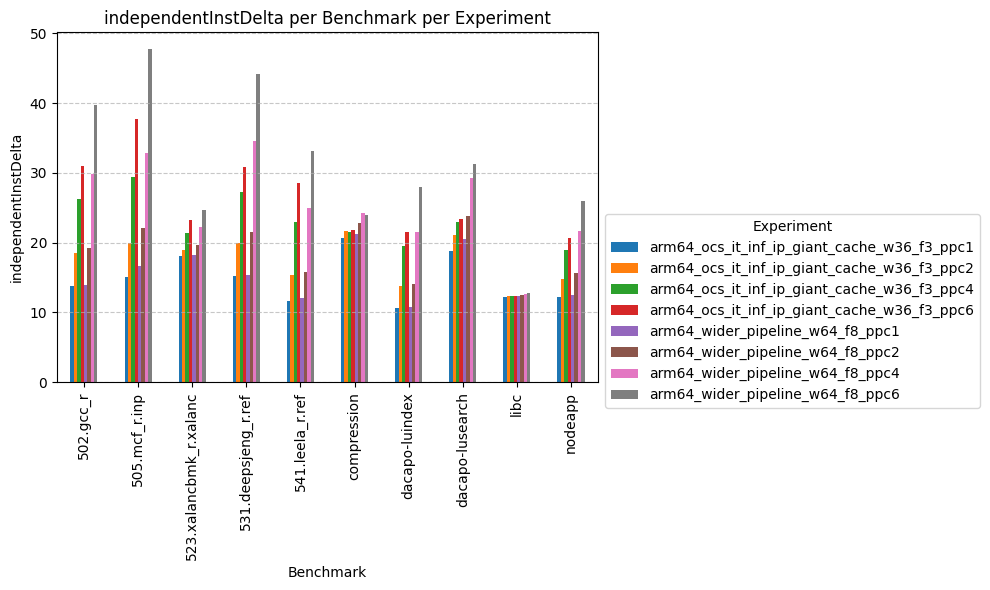

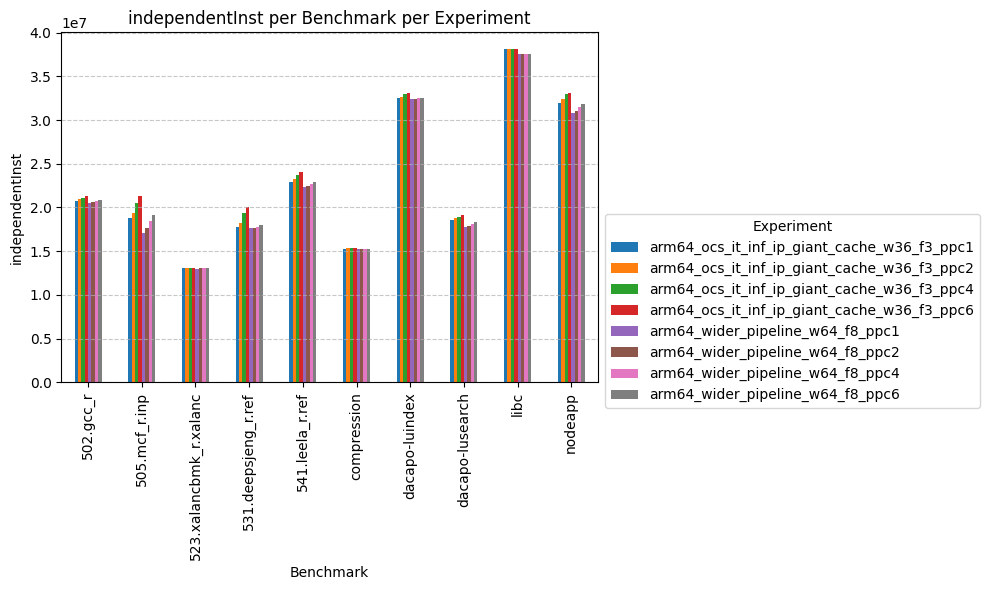

In [117]:
#barPlotY(backend_comparison, y = 'robSquashCycles', experiment_like=r"baseline.*w36", exclude_benchs=excluded, save_as="robSquashCycles_backend_baseline_w36")
#barPlotY(backend_comparison, y = 'IPC', experiment_like=r"cycle.*w36", exclude_benchs=excluded, save_as="IPC_one_cycle_squash_w36")
#barPlotY(ocs_inf_tage_df, y = 'fetchRate', experiment_like=r"", exclude_benchs=excluded, save_as="")
#barPlotY(big_squash_df, y = 'fetchRate', experiment_like=r"w36", exclude_benchs=excluded)
#barPlotY(comparisonocs_it_ip_giant_cache_df, y = 'IPC', experiment_like=r"w36", exclude_benchs=excluded)
#barPlotY(comparisonocs_it_ip_giant_cache_df, y = 'lsqBlockebByCache', experiment_like=r"w36", exclude_benchs=excluded)
#barPlotY(comparisonocs_it_ip_giant_cache_df, y = 'l1dcacheMisses', experiment_like=r"w36", exclude_benchs=excluded)
#barPlotY(comparison_ocs_inf_tage_df, y = 'IPC', experiment_like=r"w36", exclude_benchs=excluded, save_as="IPC_comparison_inf_tage_w36")
barPlotY(comparison_bigger_pipeline_df, y = 'independentInstDelta', experiment_like=r"", exclude_benchs=excluded, save_as="")
barPlotY(comparison_bigger_pipeline_df, y = 'independentInst', experiment_like=r"", exclude_benchs=excluded, save_as="")
#barPlotY(comparison_ocs_it_inf_phast_df, y = 'IPC', experiment_like=r"w36", exclude_benchs=excluded, save_as="IPC_comparison_inf_phast_w36")
#barPlotY(comparisonocs_it_ip_giant_cache_df, y = 'robSquashCycles', experiment_like=r"", exclude_benchs=excluded)
#barPlotY(backend_comparison, y = 'fetchRate', experiment_like=r"w36", exclude_benchs=excluded)
#barPlotY(big_squash_rs_df, y = 'robSquashCycles', experiment_like="", exclude_benchs=excluded)

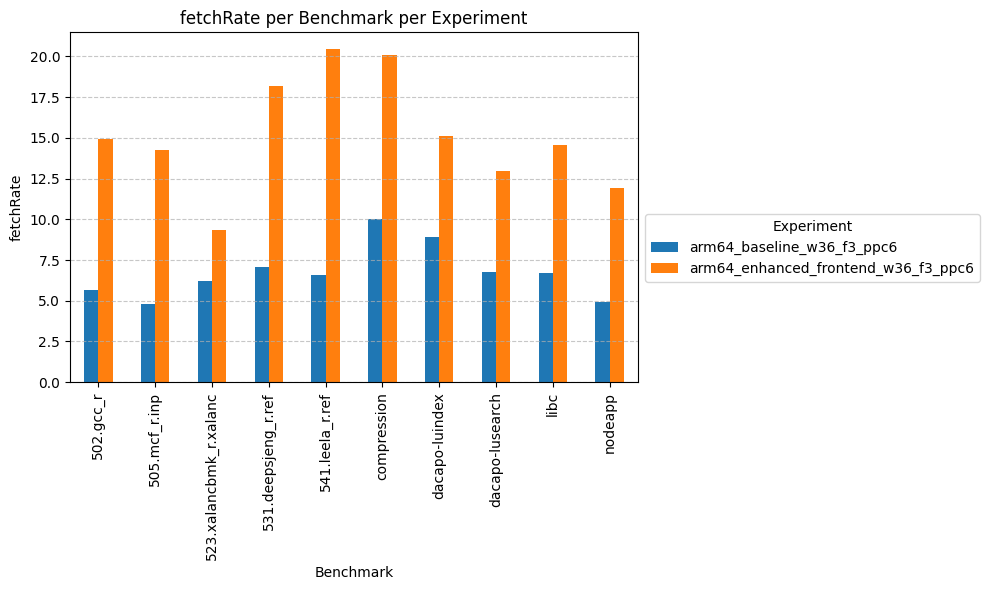

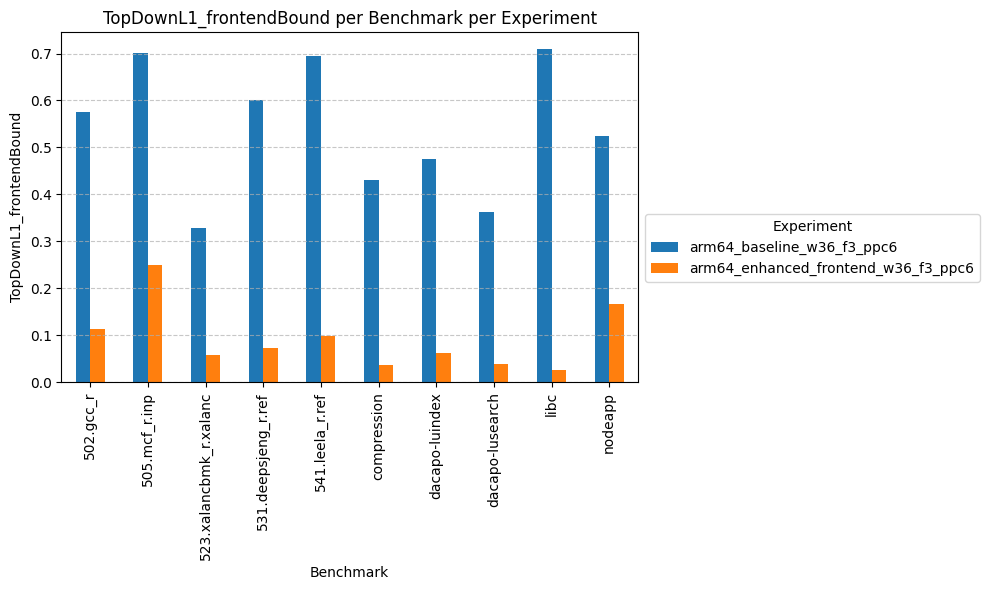

In [41]:
filter = r'w36_f3_ppc6'

#barPlotY(frontend_baseline_df, y = 'TopDownL1_frontendBound', experiment_like = r'w36', exclude_benchs=excluded, save_as="TDM_L1_frontendBound_baseline_w36")
#barPlotY(frontend_baseline_df, y = 'fetchRate', experiment_like = r'w36', exclude_benchs=excluded, save_as="fetchRate_baseline_w36")

#barPlotY(baseline_df, y = 'fetchRate', experiment_like = r'w12', exclude_benchs=excluded, save_as="fetchRate_enhanced_frontend_w12")
#barPlotY(baseline_df, y = 'TopDownL1_frontendBound', experiment_like = r'w12', exclude_benchs=excluded, save_as="TDM_L1_frontendBound_enhanced_frontend_w12")

barPlotY(frontend_comparison, y = 'fetchRate', experiment_like = filter, exclude_benchs=excluded, save_as="fetchRate_w36_ppc6_baseline_vs_enhanced_frontend")
barPlotY(frontend_comparison, y = 'TopDownL1_frontendBound', experiment_like = filter, exclude_benchs=excluded, save_as="")
#barPlotY(baseline_df, y = 'serializingStallCycleRate', experiment_like = filter, exclude_benchs=excluded, save_as="")
#barPlotY(baseline_df, y = 'IPC', experiment_like = filter, exclude_benchs=excluded, save_as="")

### Basic block size Density

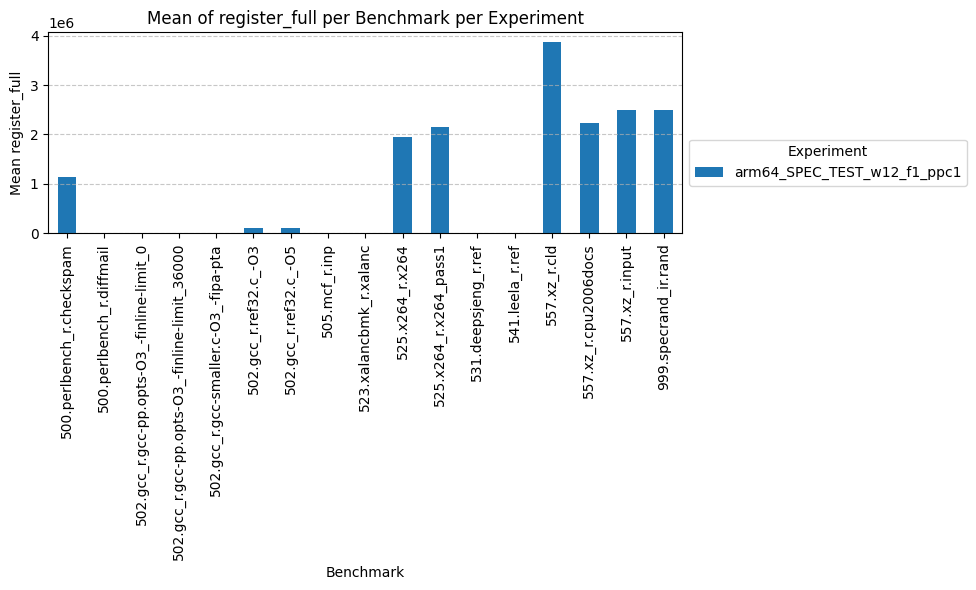

In [29]:
plotMeanY(basic_config_df, y = 'register_full', experiment_like = '')

### ROB Occupancy

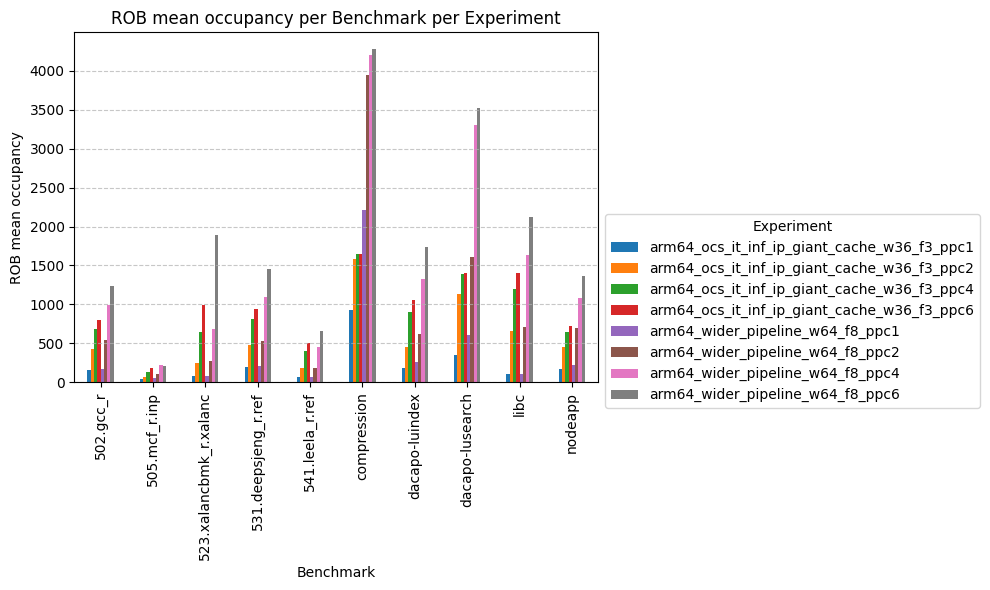

In [90]:
barPlotY(comparison_bigger_pipeline_df, y = 'ROB mean occupancy', exclude_benchs=excluded ,  experiment_like = r'', save_as="robOccupancy_bigger_window")
#barPlotY(baseline_df, y = 'ROB mean occupancy', exclude_benchs=excluded ,  experiment_like = r'baseline', save_as="rob_occupancy_benchs_w36")
#barPlotY(basic_config_df, y = 'issueRate',  experiment_like = r'enhanced.*w36')
#plotMeanY(basic_config_df, y = 'board.cache_hierarchy.l1dcaches1.demandMisses::total',  experiment_like = 'w36')

#plotMeanY(spec_df, y = 'ROB_meanOccupancy',  experiment_like = 'w36')

### ROB Occupancy Density

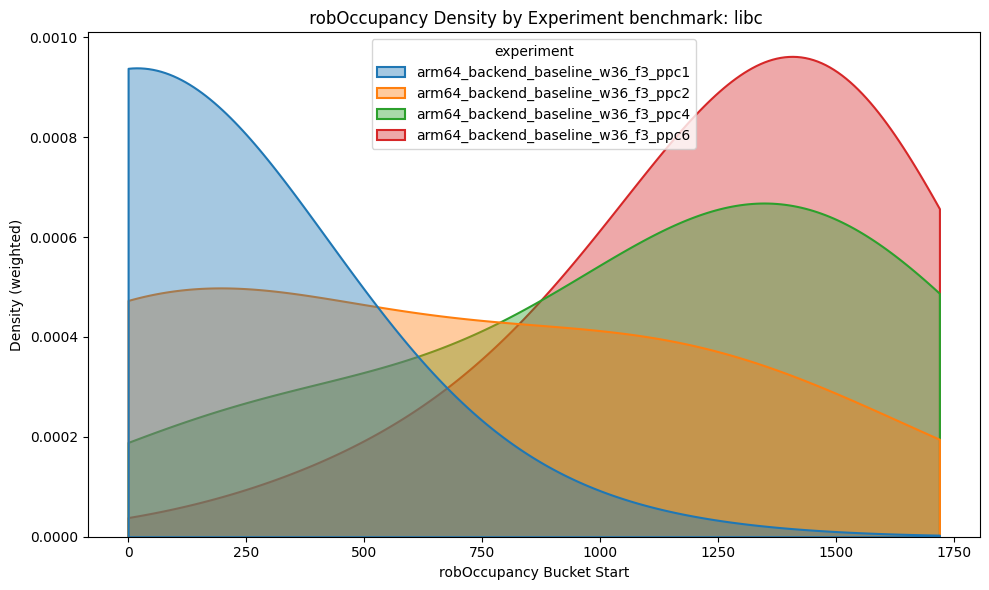

In [60]:
#plotYDensity(spec_df,y = 'robOccupancy', cores ="" , experiment_like = r'w36', only_benchs=["500.perlbench_r.checkspam", "502.gcc_r.gcc-smaller.c-O3_-fipa-pta", ""])
plotYDensity(backend_comparison,y = 'robOccupancy', cores ="1" , experiment_like = r'baseline', only_benchs=["libc"], save_as="robOccupancy_libc_w36")


### Backend Bottlnecks

In [171]:
mpki_comp =   filterBenchExperiment(comparison_ocs_inf_tage_df, experiment_like = 'w36.*ppc6', exclude_benchs=excluded)
mpki_comp['experiment'] = mpki_comp['experiment'].replace('arm64_one_cycle_squash_rs_w36_f3_ppc6', 'arm64_one_cycle_squash_w36_f3')
mpki_comp['experiment'] = mpki_comp['experiment'].replace('arm64_ocs_inf_tage_w36_f3_ppc6', 'arm64_ocs_inf_tage_w36_f3')

In [176]:
var = 'mpki'
tmp_df = mpki_comp[["experiment", "benchmark", var]]
print(tmp_df)
tmp_df = filterBenchExperiment(tmp_df, experiment_like=r'', exclude_benchs=excluded)
exp1 = "arm64_one_cycle_squash_w36_f3"
exp2 = "arm64_ocs_inf_tage_w36_f3"
print(tmp_df["experiment"].unique())
result = (
    tmp_df
    .pivot(index="benchmark", columns="experiment", values=var)
    .assign(pct_change=lambda df: (-df[exp2] + df[exp1]) / df[exp1] * 100)
    [["pct_change"]]
    .reset_index()
)
print(result)
result["pct_change"].mean()

                       experiment               benchmark       mpki
15      arm64_ocs_inf_tage_w36_f3               502.gcc_r   4.122629
16      arm64_ocs_inf_tage_w36_f3           505.mcf_r.inp  17.459839
17      arm64_ocs_inf_tage_w36_f3  523.xalancbmk_r.xalanc   0.606373
18      arm64_ocs_inf_tage_w36_f3     531.deepsjeng_r.ref   3.001114
19      arm64_ocs_inf_tage_w36_f3         541.leela_r.ref   6.386556
35      arm64_ocs_inf_tage_w36_f3                 nodeapp   2.780202
36      arm64_ocs_inf_tage_w36_f3             compression   0.009508
37      arm64_ocs_inf_tage_w36_f3         dacapo-lusearch   0.501752
38      arm64_ocs_inf_tage_w36_f3                    libc   0.057076
39      arm64_ocs_inf_tage_w36_f3          dacapo-luindex   1.173422
15  arm64_one_cycle_squash_w36_f3               502.gcc_r   5.724001
16  arm64_one_cycle_squash_w36_f3           505.mcf_r.inp  19.707109
17  arm64_one_cycle_squash_w36_f3  523.xalancbmk_r.xalanc   0.800413
18  arm64_one_cycle_squash_w36_f3 

np.float64(38.0227046048316)

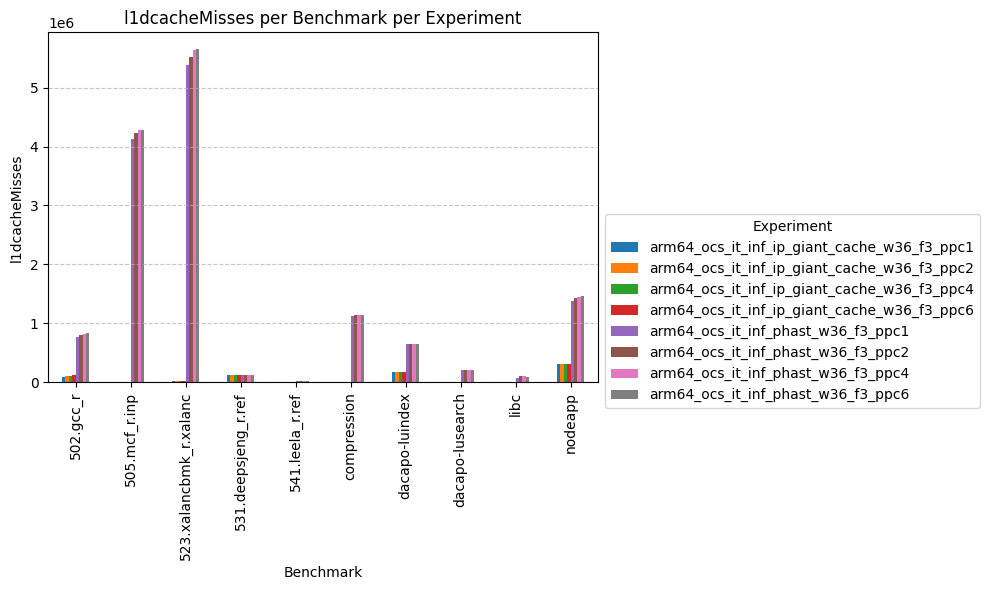

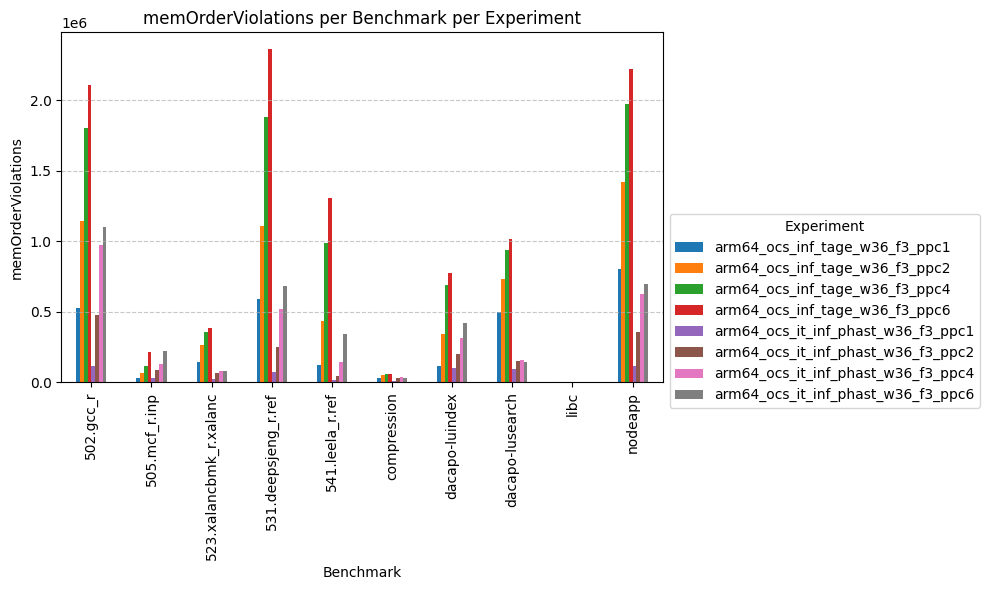

In [42]:
#plotMPKIStack(mpki_comp,  experiment_like = '', exclude_benchs=excluded , mean = True, rm_components = ['icache_mpki'], save_as="mpki_stack_inf_tage_vs_one_cycle_squash")
#plotMPKIStack(comparison_ocs_inf_tage_df,  experiment_like = 'w36.*ppc2', exclude_benchs=excluded , mean = True, rm_components = ['icache_mpki'], save_as="")
barPlotY(comparisonocs_it_ip_giant_cache_df, y="l1dcacheMisses" , experiment_like = 'w36', exclude_benchs=excluded,  save_as="L1Dcachemisses_giant_cache_w36")
barPlotY(comparison_ocs_it_inf_phast_df, y="memOrderViolations" , experiment_like = 'w36', exclude_benchs=excluded,  save_as="")
#barPlotY(baseline_df, y="TopDownL2_memoryBound" , experiment_like = 'w36', exclude_benchs=excluded,  save_as="TDM_L2_memoryBound_backend_baseline_w36")
#barPlotY(baseline_df, y="TopDownL2_Mispredicts" , experiment_like = 'w36', exclude_benchs=excluded,  save_as="TDM_L2mispredicts_baseline_w36")
#barPlotY(baseline_df, y="TopDownL2_machineClears" , label = "TopDownL2_memOrderViolations" ,  experiment_like = 'w36', exclude_benchs=excluded,  save_as="TDM_L2machineClears_baseline_w36")